# Introduction

- **session_id** - the ID of the session the event took place in
- **index** - the index of the event for the session
- **elapsed_time** - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
- **event_name** - the name of the event type
- **name** - the event name (e.g. identifies whether a notebook_click is opening or closing the notebook)
- **level** - what level of the game the event occurred in (0 to 22)
- **page** - the page number of the event (only for notebook-related events)
- **room_coor_x** - the coordinates of the click in reference to the in-game room (only for click events)
- **room_coor_y** - the coordinates of the click in reference to the in-game room (only for click events)
- **screen_coor_x** - the coordinates of the click in reference to the player’s screen (only for click events)
- **screen_coor_y** - the coordinates of the click in reference to the player’s screen (only for click events)
- **hover_duration** - how long (in milliseconds) the hover happened for (only for hover events)
- **text** - the text the player sees during this event
- **fqid** - the fully qualified ID of the event
- **room_fqid** - the fully qualified ID of the room the event took place in
- **text_fqid** - the fully qualified ID of the
- **fullscreen** - whether the player is in fullscreen mode
- **hq** - whether the game is in high-quality
- **music** - whether the game music is on or off
- **level_group** - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Train

## Data

In [3]:
# Reference: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/384359
dtypes={
    'elapsed_time': np.int32,
    'event_name': 'category',
    'name': 'category',
    'level': np.uint8,
    'room_coor_x': np.float32,
    'room_coor_y': np.float32,
    'screen_coor_x': np.float32,
    'screen_coor_y': np.float32,
    'hover_duration': np.float32,
    'text': 'category',
    'fqid': 'category',
    'room_fqid': 'category',
    'text_fqid': 'category',
    'fullscreen': 'category',
    'hq': 'category',
    'music': 'category',
    'level_group': 'category'
}

train_data = pd.read_csv('../data/train.csv', dtype=dtypes)

In [4]:
## Reference: https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data?scriptVersionId=118573291&cellId=15
def summarize_data_info(df: pd.DataFrame) -> pd.DataFrame:
    summary = pd.DataFrame(df.dtypes, columns=['data_type'])
    
    summary['perc_missing'] = df.isnull().sum().values * 100
    summary['perc_missing'] = df.isnull().sum().values / len(df)
    summary['n_unique'] = df.nunique().values
    
    summary['first_value'] = df.loc[0].values
    summary['second_value'] = df.loc[1].values
    summary['third_value'] = df.loc[2].values
    
    df_describe = pd.DataFrame(df.describe(include='all').transpose())
    summary['min'] = df_describe['min'].values
    summary['max'] = df_describe['max'].values
    
    print(f'Data Shape: {df.shape}')
    
    return summary

In [5]:
summary = summarize_data_info(train_data)
summary

Data Shape: (26296946, 20)


data_type  perc_missing  n_unique  \
session_id         int64      0.000000     23562   
index              int64      0.000000     20348   
elapsed_time       int32      0.000000   5042639   
event_name      category      0.000000        11   
name            category      0.000000         6   
level              uint8      0.000000        23   
page             float64      0.978532         7   
room_coor_x      float32      0.078841  12538215   
room_coor_y      float32      0.078841   9551136   
screen_coor_x    float32      0.078841     57477   
screen_coor_y    float32      0.078841    102591   
hover_duration   float32      0.923860     24101   
text            category      0.634287       597   
fqid            category      0.314653       128   
room_fqid       category      0.000000        19   
text_fqid       category      0.634283       126   
fullscreen      category      0.000000         2   
hq              category      0.000000         2   
music           category      0.000000         2   
level_group     category      0.000000         3   

                                         first_value  \
session_id                         20090312431273200   
index                                              0   
elapsed_time                                       0   
event_name                            cutscene_click   
name                                           basic   
level                                              0   
page                                             NaN   
room_coor_x                              -413.991394   
room_coor_y                              -159.314682   
screen_coor_x                                  380.0   
screen_coor_y                                  494.0   
hover_duration                                   NaN   
text                                       undefined   
fqid                                           intro   
room_fqid             tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.intro   
fullscreen                                         0   
hq                                                 0   
music                                              1   
level_group                                      0-4   

                                                     second_value  \
session_id                                      20090312431273200   
index                                                           1   
elapsed_time                                                 1323   
event_name                                           person_click   
name                                                        basic   
level                                                           0   
page                                                          NaN   
room_coor_x                                           -413.991394   
room_coor_y                                           -159.314682   
screen_coor_x                                               380.0   
screen_coor_y                                               494.0   
hover_duration                                                NaN   
text                                Whatcha doing over there, Jo?   
fqid                                                       gramps   
room_fqid                          tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.gramps.intro_0_...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
level_group                                                   0-4   

                                                      third_value  \
session_id                                      20090312431273200   
index                                                           2   
elapsed_time                                                  831   
event_name         

In [6]:
# Reduce Memory Usage
# reference : https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 @ARJANGROEN

def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [7]:
train_data = reduce_memory_usage(train_data)

Memory usage of dataframe is 1529.83 MB
Memory usage became:  1053.3384094238281  MB


In [8]:
summary = summarize_data_info(train_data)
summary

Data Shape: (26296946, 20)


data_type  perc_missing  n_unique  \
session_id         int64      0.000000     23562   
index              int16      0.000000     20348   
elapsed_time       int32      0.000000   5042639   
event_name      category      0.000000        11   
name            category      0.000000         6   
level            float16      0.000000        23   
page             float16      0.978532         7   
room_coor_x      float16      0.078841     29854   
room_coor_y      float16      0.078841     27847   
screen_coor_x    float16      0.078841      6866   
screen_coor_y    float16      0.078841      5188   
hover_duration   float32      0.923860     24101   
text            category      0.634287       597   
fqid            category      0.314653       128   
room_fqid       category      0.000000        19   
text_fqid       category      0.634283       126   
fullscreen      category      0.000000         2   
hq              category      0.000000         2   
music           category      0.000000         2   
level_group     category      0.000000         3   

                                         first_value  \
session_id                         20090312431273200   
index                                              0   
elapsed_time                                       0   
event_name                            cutscene_click   
name                                           basic   
level                                            0.0   
page                                             NaN   
room_coor_x                                   -414.0   
room_coor_y                                 -159.375   
screen_coor_x                                  380.0   
screen_coor_y                                  494.0   
hover_duration                                   NaN   
text                                       undefined   
fqid                                           intro   
room_fqid             tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.intro   
fullscreen                                         0   
hq                                                 0   
music                                              1   
level_group                                      0-4   

                                                     second_value  \
session_id                                      20090312431273200   
index                                                           1   
elapsed_time                                                 1323   
event_name                                           person_click   
name                                                        basic   
level                                                         0.0   
page                                                          NaN   
room_coor_x                                                -414.0   
room_coor_y                                              -159.375   
screen_coor_x                                               380.0   
screen_coor_y                                               494.0   
hover_duration                                                NaN   
text                                Whatcha doing over there, Jo?   
fqid                                                       gramps   
room_fqid                          tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.gramps.intro_0_...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
level_group                                                   0-4   

                                                      third_value  \
session_id                                      20090312431273200   
index                                                           2   
elapsed_time                                                  831   
event_name         

### `Text` Field Preprocessing

In [9]:
from typing import Dict

def preprocess_text_str(text_str: str) -> str:
    s = str(text_str).replace("\\", "")
    text_str_ = "undefined" if s.startswith("u0") or (s in ["undefined", "nan"]) else s
    
    text_str__clean = text_str_.split("u0")[0] if "u0" in text_str_ else text_str_ 
    
    return text_str__clean

def create_text_field__clean_dict(data: pd.DataFrame(), text_field: str) -> Dict:
    text_values = list(data[text_field].unique())
    text_values_ = [preprocess_text_str(s) for s in text_values]
    
    text_field__clean_dict = dict(zip(text_values, text_values_))
    
    return text_field__clean_dict

def map_text_field(data: pd.DataFrame, text_field: str, text_field__clean_dict: Dict) -> pd.DataFrame:
    data[text_field] = data[text_field].map(text_values__clean_dict).fillna("undefined")
    
    return data

def recategorize_category_typed_fields(data: pd.DataFrame) -> pd.DataFrame:
    for field_name, dtype in data.dtypes.items():
        if dtype == "category":
            data[field_name] = data[field_name].astype(str).astype("category")
            
    return data

In [10]:
text_values = list(train_data["text"].unique())
text_values[:20]

['undefined',
 'Whatcha doing over there, Jo?',
 'Just talking to Teddy.',
 'I gotta run to my meeting!',
 'Can I come, Gramps?',
 'Sure thing, Jo. Grab your notebook and come upstairs!',
 'See you later, Teddy.',
 "I get to go to Gramps's meeting!",
 'Now where did I put my notebook?',
 '\\u00f0\\u0178\\u02dc\\u00b4',
 nan,
 'I love these photos of me and Teddy!',
 'Found it!',
 'Gramps is in trouble for losing papers?',
 "This can't be right!",
 'Gramps is a great historian!',
 "Hmm. Button's still not working.",
 "Let's get started. The Wisconsin Wonders exhibit opens tomorrow!",
 'Who wants to investigate the shirt artifact?',
 "Not Leopold here. He's been losing papers lately."]

In [11]:
text_values_ = [preprocess_text_str(s) for s in text_values]
text_values_[:20]

['undefined',
 'Whatcha doing over there, Jo?',
 'Just talking to Teddy.',
 'I gotta run to my meeting!',
 'Can I come, Gramps?',
 'Sure thing, Jo. Grab your notebook and come upstairs!',
 'See you later, Teddy.',
 "I get to go to Gramps's meeting!",
 'Now where did I put my notebook?',
 'undefined',
 'undefined',
 'I love these photos of me and Teddy!',
 'Found it!',
 'Gramps is in trouble for losing papers?',
 "This can't be right!",
 'Gramps is a great historian!',
 "Hmm. Button's still not working.",
 "Let's get started. The Wisconsin Wonders exhibit opens tomorrow!",
 'Who wants to investigate the shirt artifact?',
 "Not Leopold here. He's been losing papers lately."]

In [12]:
text_field__clean_dict = dict(zip(text_values, text_values_))
train_data["text"] = train_data["text"].map(text_field__clean_dict).fillna("undefined").astype('category')

In [13]:
summary = summarize_data_info(train_data)
summary

Data Shape: (26296946, 20)


data_type  perc_missing  n_unique  \
session_id         int64      0.000000     23562   
index              int16      0.000000     20348   
elapsed_time       int32      0.000000   5042639   
event_name      category      0.000000        11   
name            category      0.000000         6   
level            float16      0.000000        23   
page             float16      0.978532         7   
room_coor_x      float16      0.078841     29854   
room_coor_y      float16      0.078841     27847   
screen_coor_x    float16      0.078841      6866   
screen_coor_y    float16      0.078841      5188   
hover_duration   float32      0.923860     24101   
text            category      0.000000       587   
fqid            category      0.314653       128   
room_fqid       category      0.000000        19   
text_fqid       category      0.634283       126   
fullscreen      category      0.000000         2   
hq              category      0.000000         2   
music           category      0.000000         2   
level_group     category      0.000000         3   

                                         first_value  \
session_id                         20090312431273200   
index                                              0   
elapsed_time                                       0   
event_name                            cutscene_click   
name                                           basic   
level                                            0.0   
page                                             NaN   
room_coor_x                                   -414.0   
room_coor_y                                 -159.375   
screen_coor_x                                  380.0   
screen_coor_y                                  494.0   
hover_duration                                   NaN   
text                                       undefined   
fqid                                           intro   
room_fqid             tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.intro   
fullscreen                                         0   
hq                                                 0   
music                                              1   
level_group                                      0-4   

                                                     second_value  \
session_id                                      20090312431273200   
index                                                           1   
elapsed_time                                                 1323   
event_name                                           person_click   
name                                                        basic   
level                                                         0.0   
page                                                          NaN   
room_coor_x                                                -414.0   
room_coor_y                                              -159.375   
screen_coor_x                                               380.0   
screen_coor_y                                               494.0   
hover_duration                                                NaN   
text                                Whatcha doing over there, Jo?   
fqid                                                       gramps   
room_fqid                          tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.gramps.intro_0_...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
level_group                                                   0-4   

                                                      third_value  \
session_id                                      20090312431273200   
index                                                           2   
elapsed_time                                                  831   
event_name         

### Train Labels

In [14]:
train_labels = pd.read_csv("../data/train_labels.csv")

In [15]:
summary = summarize_data_info(train_labels)
summary

Data Shape: (424116, 2)


data_type  perc_missing  n_unique           first_value  \
session_id    object           0.0    424116  20090312431273200_q1   
correct        int64           0.0         2                     1   

                    second_value           third_value  min  max  
session_id  20090312433251036_q1  20090312455206810_q1  NaN  NaN  
correct                        0                     1  0.0  1.0

In [16]:
train_labels['question_no'] = train_labels['session_id'].apply(lambda x: int(x.split('_')[-1][1:]))
train_labels['session_id'] = train_labels['session_id'].apply(lambda x: int(x.split('_')[0]) )

train_labels["session_id"].nunique()

23562

In [17]:
summary = summarize_data_info(train_labels)
summary

Data Shape: (424116, 3)


data_type  perc_missing  n_unique        first_value  \
session_id      int64           0.0     23562  20090312431273200   
correct         int64           0.0         2                  1   
question_no     int64           0.0        18                  1   

                  second_value        third_value           min           max  
session_id   20090312433251036  20090312455206810  2.009031e+16  2.210022e+16  
correct                      0                  1  0.000000e+00  1.000000e+00  
question_no                  1                  1  1.000000e+00  1.800000e+01

#### Validity check >>> Train Labels

In [18]:
train_labels.groupby("session_id")["question_no"].nunique().value_counts()

18    23562
Name: question_no, dtype: int64

In [19]:
question_no__list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
len(train_labels[~train_labels["question_no"].isin(question_no__list)])

0

In [20]:
len(train_labels) == (23562 * 18)

True

#### Validity check >>> Session ids in datasets

In [21]:
train_data__session_id_unique_vals = train_data["session_id"].drop_duplicates().sort_values().reset_index(drop=True)
train_labels__session_id_unique_vals = train_labels["session_id"].drop_duplicates().sort_values().reset_index(drop=True)

pd.testing.assert_series_equal(train_data__session_id_unique_vals, train_labels__session_id_unique_vals)

### Downsampling

In [22]:
session_ids = sorted(train_labels["session_id"].unique())

np.random.seed(42)
np.random.shuffle(session_ids)

session_ids[:5]

[22010107585684490,
 20100413373831344,
 21000409261644490,
 20110314164224844,
 21080621495509370]

In [23]:
N_CHUNKS = 10

np.random.seed(42)
chunk_ids = np.random.randint(N_CHUNKS, size=len(session_ids))

session_chunk_df = pd.DataFrame({"session_id": session_ids, "chunk_id": chunk_ids})
session_chunk_df["chunk_id"].value_counts()

0    2418
9    2407
5    2395
6    2360
1    2358
2    2350
3    2347
7    2320
8    2311
4    2296
Name: chunk_id, dtype: int64

In [24]:
session_chunk_df["chunk_id"].nunique()

10

## Filter Data

### `level_group` == `"0-4"`

In [25]:
level_group = "0-4"
train_data__lg_filtered = train_data[train_data["level_group"] == level_group].drop(labels="level_group", axis=1).reset_index(drop=True)
train_data__lg_filtered.head()

session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312431273200      0             0  cutscene_click  basic    0.0   NaN   
1  20090312431273200      1          1323    person_click  basic    0.0   NaN   
2  20090312431273200      2           831    person_click  basic    0.0   NaN   
3  20090312431273200      3          1147    person_click  basic    0.0   NaN   
4  20090312431273200      4          1863    person_click  basic    0.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0       -414.0     -159.375          380.0          494.0             NaN   
1       -414.0     -159.375          380.0          494.0             NaN   
2       -414.0     -159.375          380.0          494.0             NaN   
3       -414.0     -159.375          380.0          494.0             NaN   
4       -413.0     -159.375          381.0          494.0             NaN   

                            text    fqid                       room_fqid  \
0                      undefined   intro  tunic.historicalsociety.closet   
1  Whatcha doing over there, Jo?  gramps  tunic.historicalsociety.closet   
2         Just talking to Teddy.  gramps  tunic.historicalsociety.closet   
3     I gotta run to my meeting!  gramps  tunic.historicalsociety.closet   
4            Can I come, Gramps?  gramps  tunic.historicalsociety.closet   

                                           text_fqid fullscreen hq music  
0               tunic.historicalsociety.closet.intro          0  0     1  
1  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1  
2  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1  
3  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1  
4  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1

In [26]:
summary = summarize_data_info(train_data__lg_filtered)
summary

Data Shape: (3981005, 19)


data_type  perc_missing  n_unique  \
session_id         int64      0.000000     23562   
index              int16      0.000000      3538   
elapsed_time       int32      0.000000    553618   
event_name      category      0.000000        11   
name            category      0.000000         6   
level            float16      0.000000         5   
page             float16      0.979469         2   
room_coor_x      float16      0.044202     23720   
room_coor_y      float16      0.044202     21258   
screen_coor_x    float16      0.044202      5579   
screen_coor_y    float16      0.044202      3921   
hover_duration   float32      0.961754     15588   
text            category      0.000000        97   
fqid            category      0.381232        35   
room_fqid       category      0.000000         7   
text_fqid       category      0.624073        27   
fullscreen      category      0.000000         2   
hq              category      0.000000         2   
music           category      0.000000         2   

                                         first_value  \
session_id                         20090312431273200   
index                                              0   
elapsed_time                                       0   
event_name                            cutscene_click   
name                                           basic   
level                                            0.0   
page                                             NaN   
room_coor_x                                   -414.0   
room_coor_y                                 -159.375   
screen_coor_x                                  380.0   
screen_coor_y                                  494.0   
hover_duration                                   NaN   
text                                       undefined   
fqid                                           intro   
room_fqid             tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.intro   
fullscreen                                         0   
hq                                                 0   
music                                              1   

                                                     second_value  \
session_id                                      20090312431273200   
index                                                           1   
elapsed_time                                                 1323   
event_name                                           person_click   
name                                                        basic   
level                                                         0.0   
page                                                          NaN   
room_coor_x                                                -414.0   
room_coor_y                                              -159.375   
screen_coor_x                                               380.0   
screen_coor_y                                               494.0   
hover_duration                                                NaN   
text                                Whatcha doing over there, Jo?   
fqid                                                       gramps   
room_fqid                          tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.gramps.intro_0_...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   

                                                      third_value  \
session_id                                      20090312431273200   
index                                                           2   
elapsed_time                                                  831   
event_name                                           person_click   
name                                                        basic   
level                                                     

#### `question_no` == `1`

In [27]:
question_no = 1
train_labels__qn_filtered = train_labels[train_labels["question_no"] == question_no].drop(labels="question_no", axis=1).reset_index(drop=True)
train_labels__qn_filtered.head()

session_id  correct
0  20090312431273200        1
1  20090312433251036        0
2  20090312455206810        1
3  20090313091715820        0
4  20090313571836404        1

In [28]:
summary = summarize_data_info(train_labels__qn_filtered)
summary

Data Shape: (23562, 2)


data_type  perc_missing  n_unique        first_value  \
session_id     int64           0.0     23562  20090312431273200   
correct        int64           0.0         2                  1   

                 second_value        third_value           min           max  
session_id  20090312433251036  20090312455206810  2.009031e+16  2.210022e+16  
correct                     0                  1  0.000000e+00  1.000000e+00

# EDA per Event

In [29]:
df = train_data__lg_filtered.merge(train_labels__qn_filtered, on="session_id", how="left")
df.head()

session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312431273200      0             0  cutscene_click  basic    0.0   NaN   
1  20090312431273200      1          1323    person_click  basic    0.0   NaN   
2  20090312431273200      2           831    person_click  basic    0.0   NaN   
3  20090312431273200      3          1147    person_click  basic    0.0   NaN   
4  20090312431273200      4          1863    person_click  basic    0.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0       -414.0     -159.375          380.0          494.0             NaN   
1       -414.0     -159.375          380.0          494.0             NaN   
2       -414.0     -159.375          380.0          494.0             NaN   
3       -414.0     -159.375          380.0          494.0             NaN   
4       -413.0     -159.375          381.0          494.0             NaN   

                            text    fqid                       room_fqid  \
0                      undefined   intro  tunic.historicalsociety.closet   
1  Whatcha doing over there, Jo?  gramps  tunic.historicalsociety.closet   
2         Just talking to Teddy.  gramps  tunic.historicalsociety.closet   
3     I gotta run to my meeting!  gramps  tunic.historicalsociety.closet   
4            Can I come, Gramps?  gramps  tunic.historicalsociety.closet   

                                           text_fqid fullscreen hq music  \
0               tunic.historicalsociety.closet.intro          0  0     1   
1  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   
2  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   
3  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   
4  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   

   correct  
0        1  
1        1  
2        1  
3        1  
4        1

In [30]:
summary = summarize_data_info(df)
summary

Data Shape: (3981005, 20)


data_type  perc_missing  n_unique  \
session_id         int64      0.000000     23562   
index              int16      0.000000      3538   
elapsed_time       int32      0.000000    553618   
event_name      category      0.000000        11   
name            category      0.000000         6   
level            float16      0.000000         5   
page             float16      0.979469         2   
room_coor_x      float16      0.044202     23720   
room_coor_y      float16      0.044202     21258   
screen_coor_x    float16      0.044202      5579   
screen_coor_y    float16      0.044202      3921   
hover_duration   float32      0.961754     15588   
text            category      0.000000        97   
fqid            category      0.381232        35   
room_fqid       category      0.000000         7   
text_fqid       category      0.624073        27   
fullscreen      category      0.000000         2   
hq              category      0.000000         2   
music           category      0.000000         2   
correct            int64      0.000000         2   

                                         first_value  \
session_id                         20090312431273200   
index                                              0   
elapsed_time                                       0   
event_name                            cutscene_click   
name                                           basic   
level                                            0.0   
page                                             NaN   
room_coor_x                                   -414.0   
room_coor_y                                 -159.375   
screen_coor_x                                  380.0   
screen_coor_y                                  494.0   
hover_duration                                   NaN   
text                                       undefined   
fqid                                           intro   
room_fqid             tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.intro   
fullscreen                                         0   
hq                                                 0   
music                                              1   
correct                                            1   

                                                     second_value  \
session_id                                      20090312431273200   
index                                                           1   
elapsed_time                                                 1323   
event_name                                           person_click   
name                                                        basic   
level                                                         0.0   
page                                                          NaN   
room_coor_x                                                -414.0   
room_coor_y                                              -159.375   
screen_coor_x                                               380.0   
screen_coor_y                                               494.0   
hover_duration                                                NaN   
text                                Whatcha doing over there, Jo?   
fqid                                                       gramps   
room_fqid                          tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.gramps.intro_0_...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
correct                                                         1   

                                                      third_value  \
session_id                                      20090312431273200   
index                                                           2   
elapsed_time                                                  831   
event_name         

In [31]:
from typing import List, Tuple

def get_heatmap_values(df: pd.DataFrame, col_pair: List[str]) -> pd.DataFrame:
    df__col_pair = df[[*col_pair, "correct"]]

    subcount_df = df__col_pair.groupby([*col_pair, "correct"]).size().reset_index().rename(columns={0: "subcount"})
    count_df = df__col_pair.groupby(col_pair).size().reset_index().rename(columns={0: "count"})

    df__all_counts = subcount_df.merge(count_df, on=col_pair, how="left")
    df__all_counts["perc"] = df__all_counts["subcount"] / df__all_counts["count"]

    df__heatmap = df__all_counts[df__all_counts["correct"] == 1].pivot_table(index=col_pair[0], columns=col_pair[1], values="perc")
    df__heatmap = df__heatmap.sort_values(by=df__heatmap.columns.to_list())

    return df__heatmap

def plot_heatmap(df__heatmap: pd.DataFrame, figsize: Tuple[int] = (12, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df__heatmap, annot=True, cbar=False, ax=ax)
    
    plt.show()

## Event Categories

In [32]:
for i in df["event_name"].unique().categories:
    print(i)

checkpoint
cutscene_click
map_click
map_hover
navigate_click
notebook_click
notification_click
object_click
object_hover
observation_click
person_click


## `event_name` == `"checkpoint"`

In [33]:
df__checkpoint = df[df["event_name"] == "checkpoint"].reset_index(drop=True)
df__checkpoint.head()

session_id  index  elapsed_time  event_name   name  level  page  \
0  20090312431273200    164        194860  checkpoint  basic    4.0   NaN   
1  20090312433251036    138        233752  checkpoint  basic    4.0   NaN   
2  20090312455206810    148        363226  checkpoint  basic    4.0   NaN   
3  20090313091715820    175        192793  checkpoint  basic    4.0   NaN   
4  20090313571836404    111        195851  checkpoint  basic    4.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0          NaN          NaN            NaN            NaN             NaN   
1          NaN          NaN            NaN            NaN             NaN   
2          NaN          NaN            NaN            NaN             NaN   
3          NaN          NaN            NaN            NaN             NaN   
4          NaN          NaN            NaN            NaN             NaN   

        text            fqid             room_fqid text_fqid fullscreen hq  \
0  undefined  chap1_finale_c  tunic.capitol_0.hall       NaN          0  0   
1  undefined  chap1_finale_c  tunic.capitol_0.hall       NaN          0  0   
2  undefined  chap1_finale_c  tunic.capitol_0.hall       NaN          1  1   
3  undefined  chap1_finale_c  tunic.capitol_0.hall       NaN          1  1   
4  undefined  chap1_finale_c  tunic.capitol_0.hall       NaN          0  0   

  music  correct  
0     1        1  
1     0        0  
2     1        1  
3     1        0  
4     1        1

#### Update Category Fields

In [34]:
df__checkpoint = recategorize_category_typed_fields(df__checkpoint)

In [35]:
summary = summarize_data_info(df__checkpoint)
summary

Data Shape: (23713, 20)


data_type  perc_missing  n_unique           first_value  \
session_id         int64           0.0     23561     20090312431273200   
index              int16           0.0       687                   164   
elapsed_time       int32           0.0     23048                194860   
event_name      category           0.0         1            checkpoint   
name            category           0.0         1                 basic   
level            float16           0.0         1                   4.0   
page             float16           1.0         0                   NaN   
room_coor_x      float16           1.0         0                   NaN   
room_coor_y      float16           1.0         0                   NaN   
screen_coor_x    float16           1.0         0                   NaN   
screen_coor_y    float16           1.0         0                   NaN   
hover_duration   float32           1.0         0                   NaN   
text            category           0.0         1             undefined   
fqid            category           0.0         1        chap1_finale_c   
room_fqid       category           0.0         1  tunic.capitol_0.hall   
text_fqid       category           0.0         1                   nan   
fullscreen      category           0.0         2                     0   
hq              category           0.0         2                     0   
music           category           0.0         2                     1   
correct            int64           0.0         2                     1   

                        second_value           third_value  \
session_id         20090312433251036     20090312455206810   
index                            138                   148   
elapsed_time                  233752                363226   
event_name                checkpoint            checkpoint   
name                           basic                 basic   
level                            4.0                   4.0   
page                             NaN                   NaN   
room_coor_x                      NaN                   NaN   
room_coor_y                      NaN                   NaN   
screen_coor_x                    NaN                   NaN   
screen_coor_y                    NaN                   NaN   
hover_duration                   NaN                   NaN   
text                       undefined             undefined   
fqid                  chap1_finale_c        chap1_finale_c   
room_fqid       tunic.capitol_0.hall  tunic.capitol_0.hall   
text_fqid                        nan                   nan   
fullscreen                         0                     1   
hq                                 0                     1   
music                              0                     1   
correct                            0                     1   

                                min                  max  
session_id      20090312431273200.0  22100221145014656.0  
index                           0.0               5135.0  
elapsed_time                  589.0         1986921747.0  
event_name                      NaN                  NaN  
name                            NaN                  NaN  
level                           4.0                  4.0  
page                            NaN                  NaN  
room_coor_x                     NaN                  NaN  
room_coor_y                     NaN                  NaN  
screen_coor_x                   NaN                  NaN  
screen_coor_y                   NaN                  NaN  
hover_duration                  NaN                  NaN  
text                            NaN                  NaN  
fqid                            NaN                  NaN  
room_fqid                       NaN                  NaN  
text_fqid                       NaN                  NaN  
fullscreen                      NaN                  NaN  
hq                              NaN                  NaN  
music                           NaN 

#### Insights

- `name` field is constant (basic).
- `level` field is constant (4).
- `text` field is constant (undefined).
- `fqid` field is constant (chap1_finale_c).
- `room_fqid` field is constant (tunic.capitol_0.hall).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `room_coor_x`
    - `room_coor_y`
    - `screen_coor_x`
    - `screen_coor_y`
    - `hover_duration`

## `event_name` == `"cutscene_click"`

In [36]:
df__cutscene_click = df[df["event_name"] == "cutscene_click"].reset_index(drop=True)
df__cutscene_click.head()

session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312431273200      0             0  cutscene_click  basic    0.0   NaN   
1  20090312431273200     41         45062  cutscene_click  basic    1.0   NaN   
2  20090312431273200     42         46046  cutscene_click  basic    1.0   NaN   
3  20090312431273200     43         47362  cutscene_click  basic    1.0   NaN   
4  20090312431273200     44         48112  cutscene_click  basic    1.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0    -414.0000   -159.37500          380.0          494.0             NaN   
1      93.8125    -60.34375          338.0          368.0             NaN   
2     134.0000    -85.68750          390.0          386.0             NaN   
3     125.9375    -83.37500          390.0          385.0             NaN   
4     123.6875    -80.06250          389.0          383.0             NaN   

                                                text        fqid  \
0                                          undefined       intro   
1  Let's get started. The Wisconsin Wonders exhib...  groupconvo   
2       Who wants to investigate the shirt artifact?  groupconvo   
3  Not Leopold here. He's been losing papers lately.  groupconvo   
4                                               Hey!  groupconvo   

                        room_fqid                                 text_fqid  \
0  tunic.historicalsociety.closet      tunic.historicalsociety.closet.intro   
1   tunic.historicalsociety.entry  tunic.historicalsociety.entry.groupconvo   
2   tunic.historicalsociety.entry  tunic.historicalsociety.entry.groupconvo   
3   tunic.historicalsociety.entry  tunic.historicalsociety.entry.groupconvo   
4   tunic.historicalsociety.entry  tunic.historicalsociety.entry.groupconvo   

  fullscreen hq music  correct  
0          0  0     1        1  
1          0  0     1        1  
2          0  0     1        1  
3          0  0     1        1  
4          0  0     1        1

#### Update Category Fields

In [37]:
df__cutscene_click = recategorize_category_typed_fields(df__cutscene_click)

In [38]:
summary = summarize_data_info(df__cutscene_click)
summary

Data Shape: (787584, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     23562   
index              int16           0.0      2641   
elapsed_time       int32           0.0    230243   
event_name      category           0.0         1   
name            category           0.0         1   
level            float16           0.0         5   
page             float16           1.0         0   
room_coor_x      float16           0.0     17676   
room_coor_y      float16           0.0     15108   
screen_coor_x    float16           0.0      3375   
screen_coor_y    float16           0.0      2255   
hover_duration   float32           1.0         0   
text            category           0.0        42   
fqid            category           0.0         5   
room_fqid       category           0.0         5   
text_fqid       category           0.0         5   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                         first_value  \
session_id                         20090312431273200   
index                                              0   
elapsed_time                                       0   
event_name                            cutscene_click   
name                                           basic   
level                                            0.0   
page                                             NaN   
room_coor_x                                   -414.0   
room_coor_y                                 -159.375   
screen_coor_x                                  380.0   
screen_coor_y                                  494.0   
hover_duration                                   NaN   
text                                       undefined   
fqid                                           intro   
room_fqid             tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.intro   
fullscreen                                         0   
hq                                                 0   
music                                              1   
correct                                            1   

                                                     second_value  \
session_id                                      20090312431273200   
index                                                          41   
elapsed_time                                                45062   
event_name                                         cutscene_click   
name                                                        basic   
level                                                         1.0   
page                                                          NaN   
room_coor_x                                               93.8125   
room_coor_y                                             -60.34375   
screen_coor_x                                               338.0   
screen_coor_y                                               368.0   
hover_duration                                                NaN   
text            Let's get started. The Wisconsin Wonders exhib...   
fqid                                                   groupconvo   
room_fqid                           tunic.historicalsociety.entry   
text_fqid                tunic.historicalsociety.entry.groupconvo   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
correct                                                         1   

                                                 third_value  \
session_id                                 20090312431273200   
index                                                     42   
elapsed_time                                           46046   
event_name                             

#### Insights

- `name` field is constant (basic).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

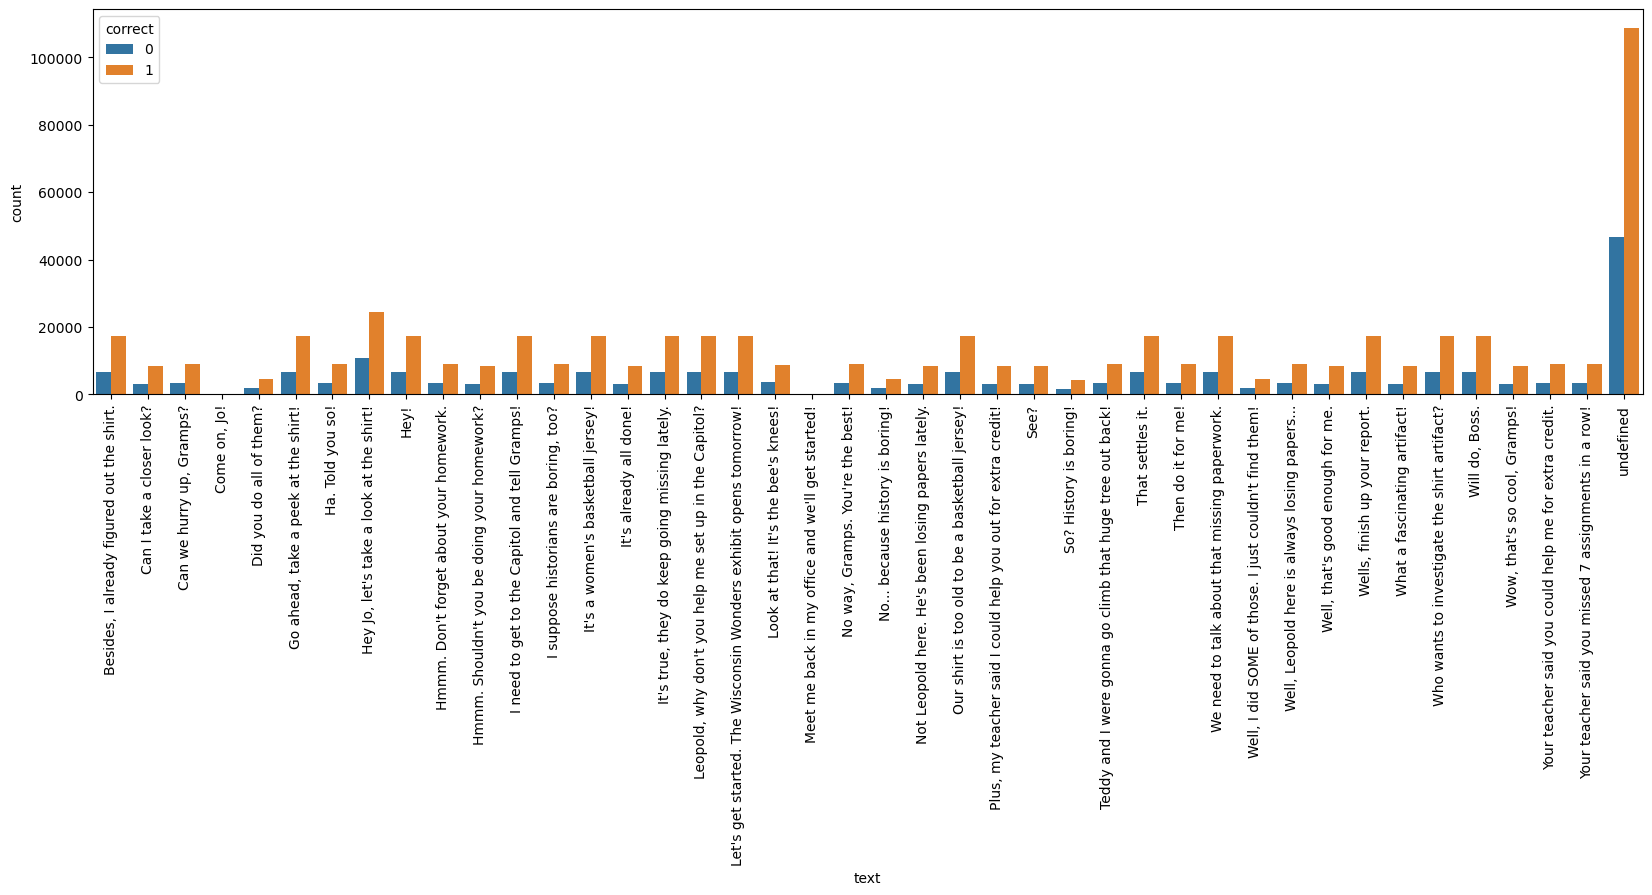

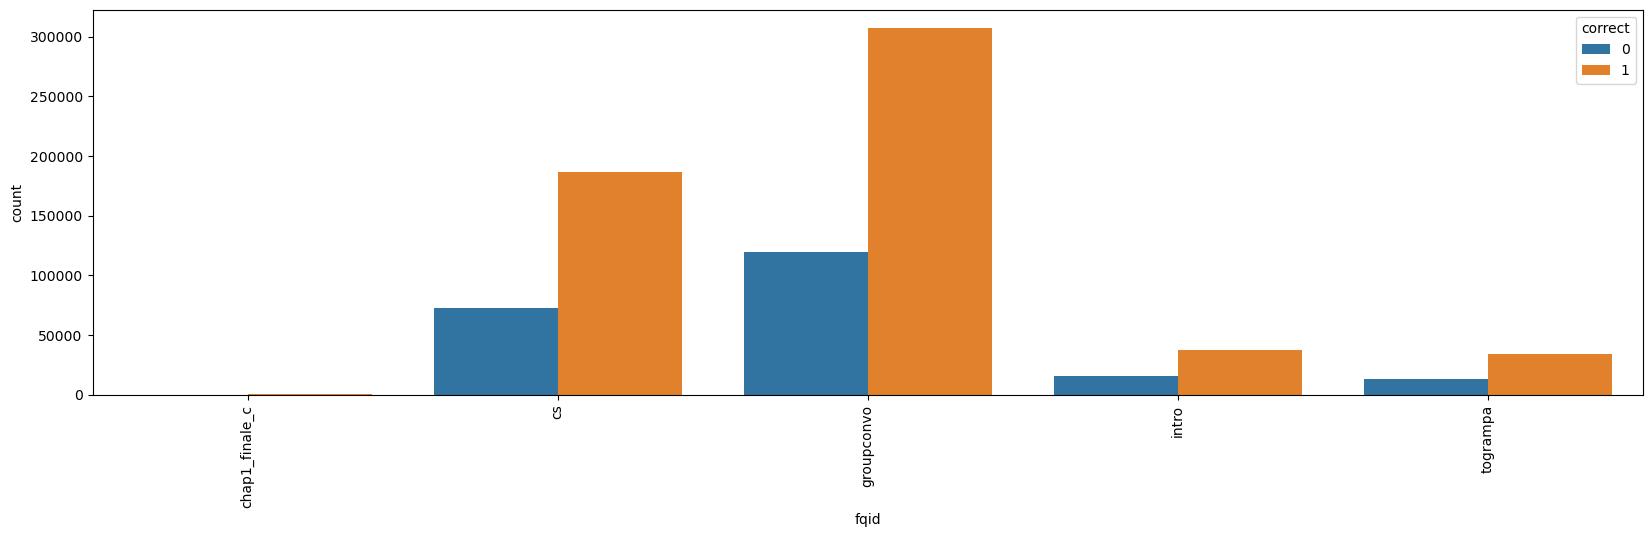

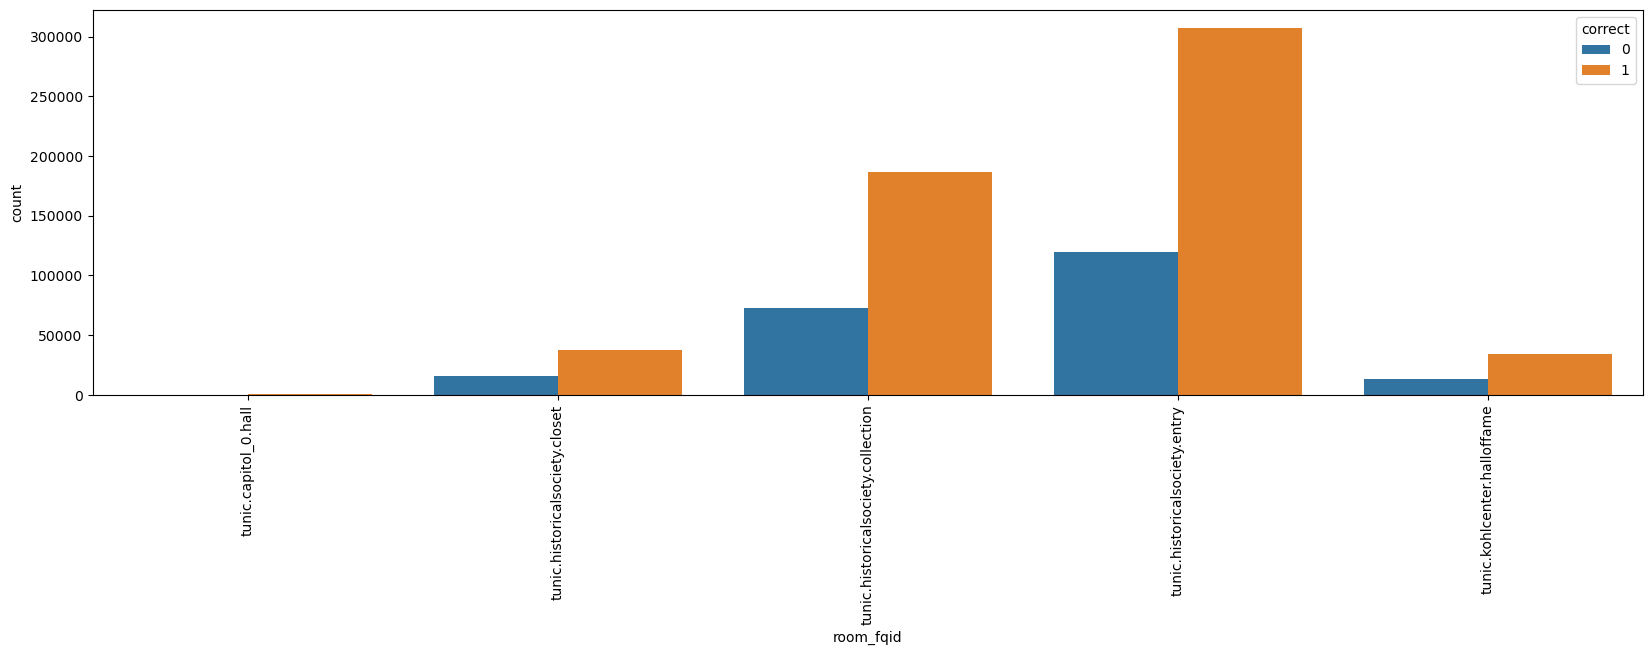

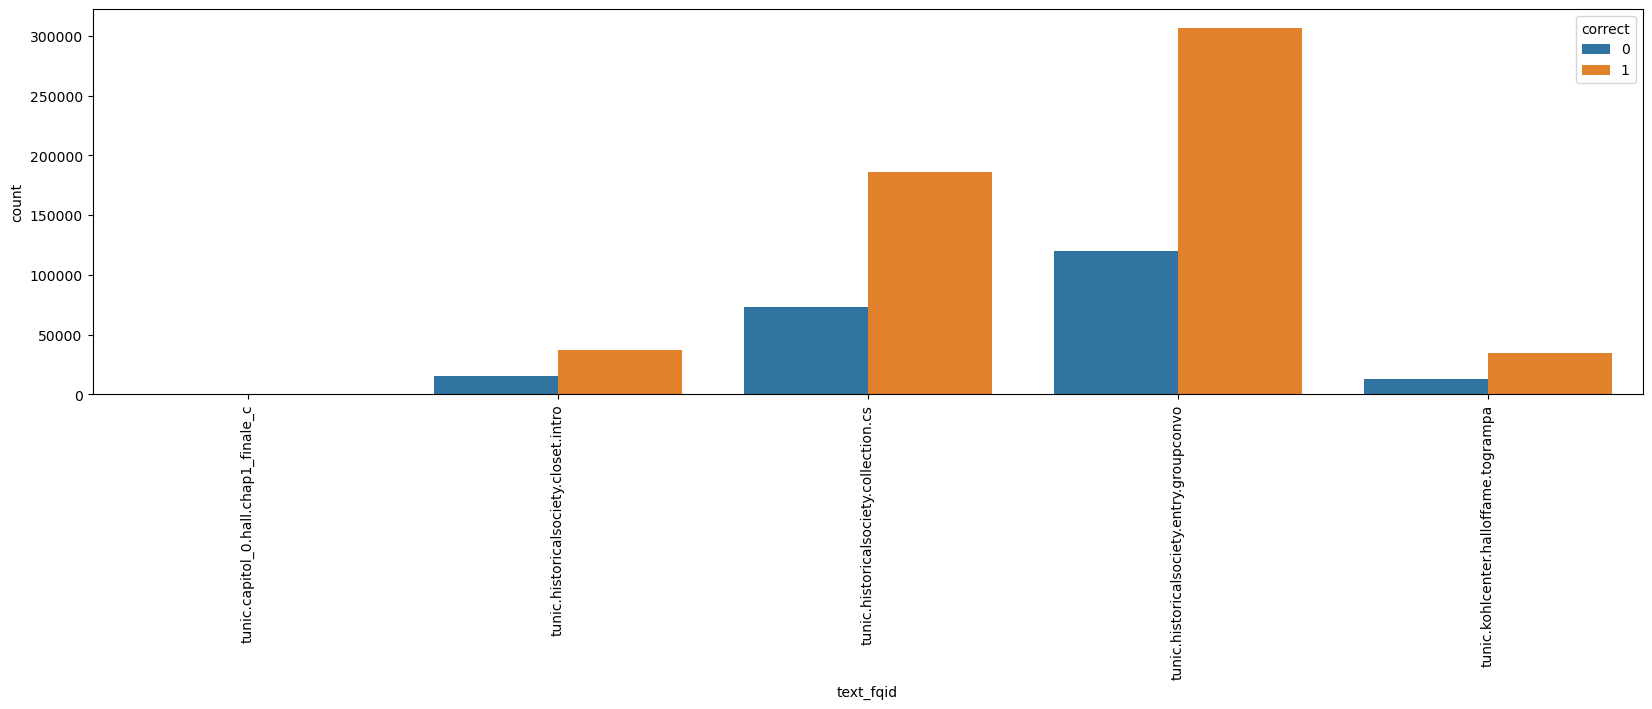

In [39]:
cat_fields_list = ["text", "fqid", "room_fqid", "text_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__cutscene_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

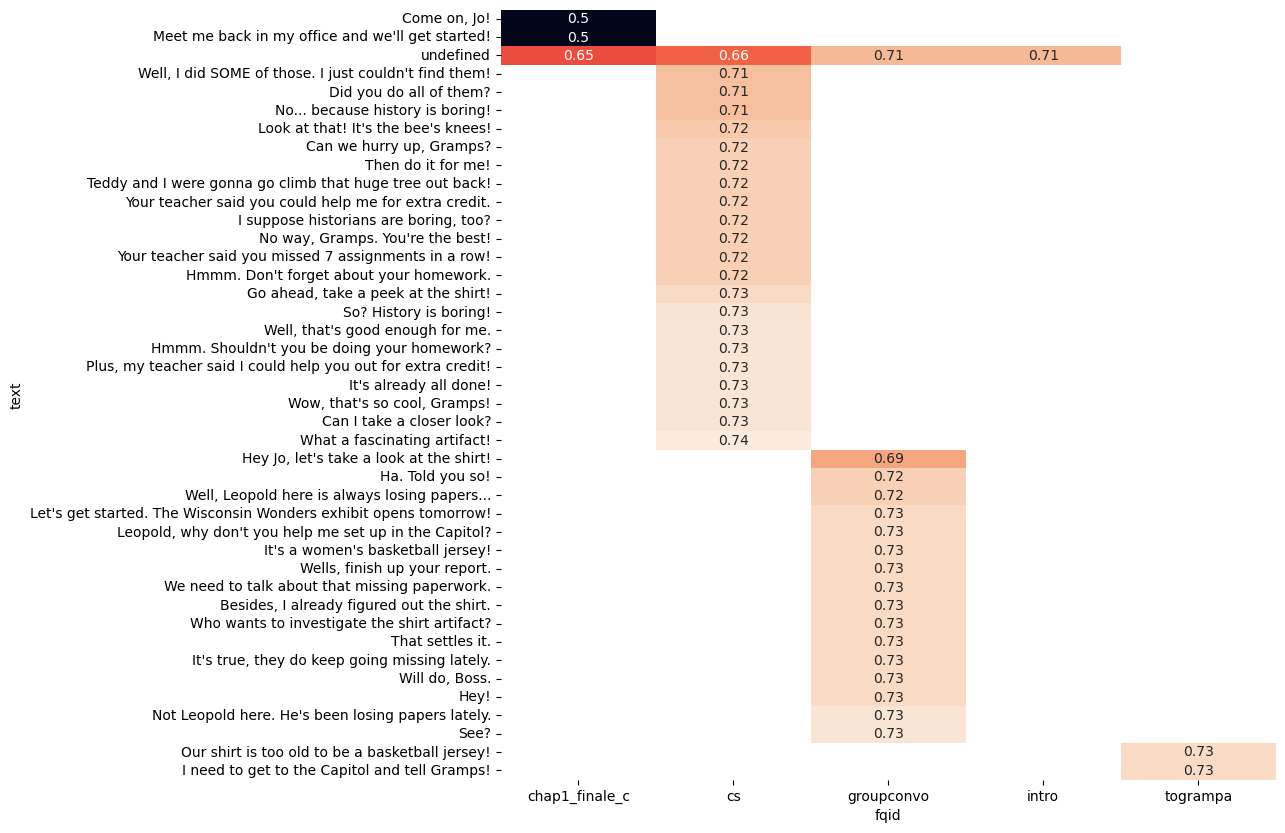

In [40]:
col_pair = ["text", "fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

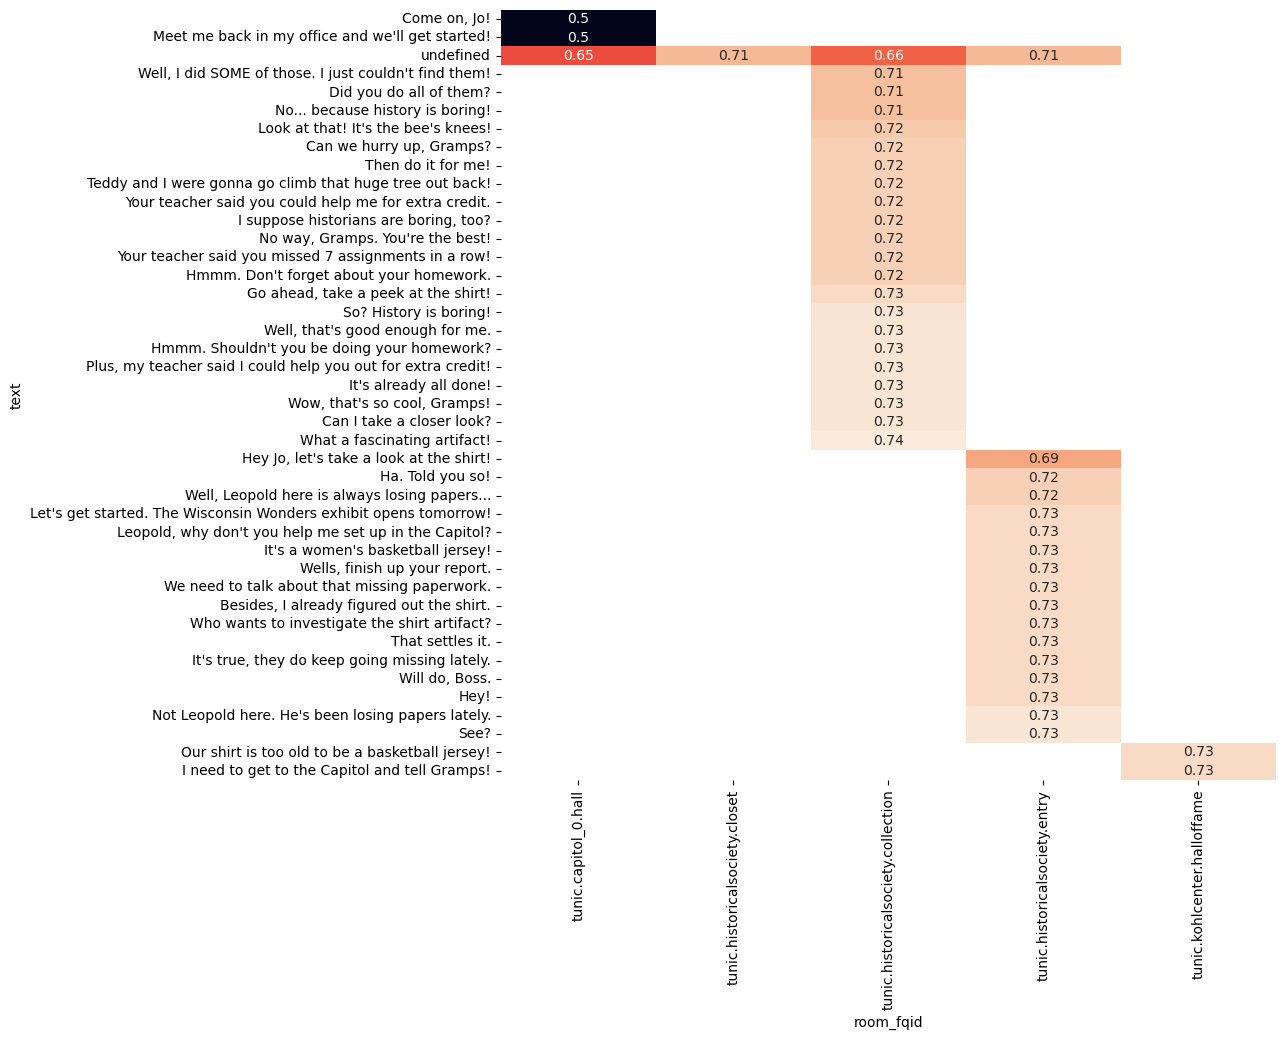

In [41]:
col_pair = ["text", "room_fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

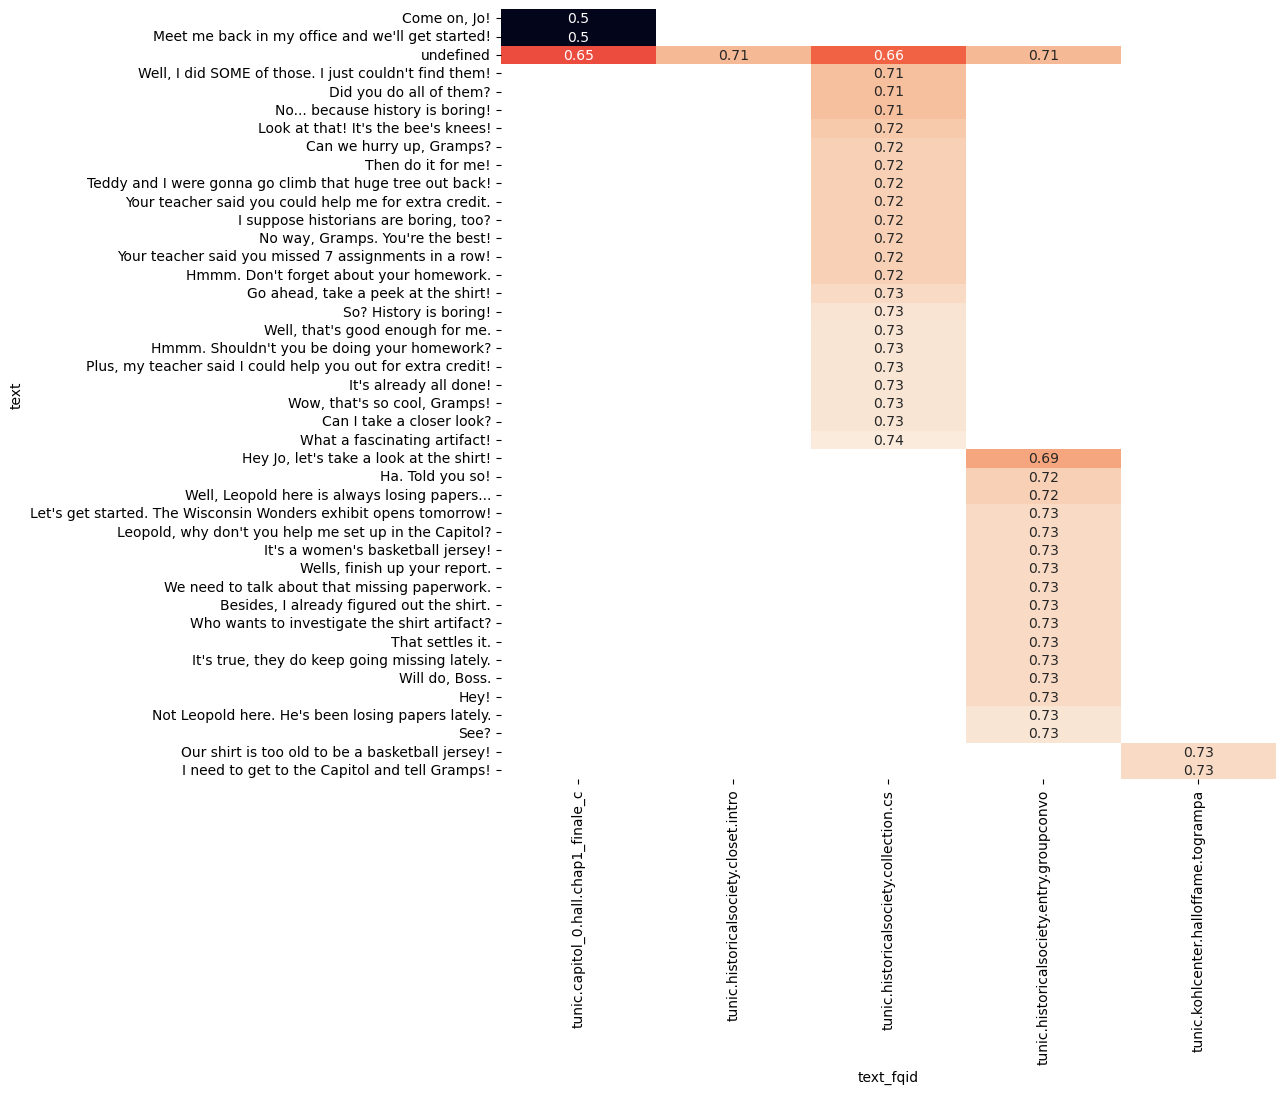

In [42]:
col_pair = ["text", "text_fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

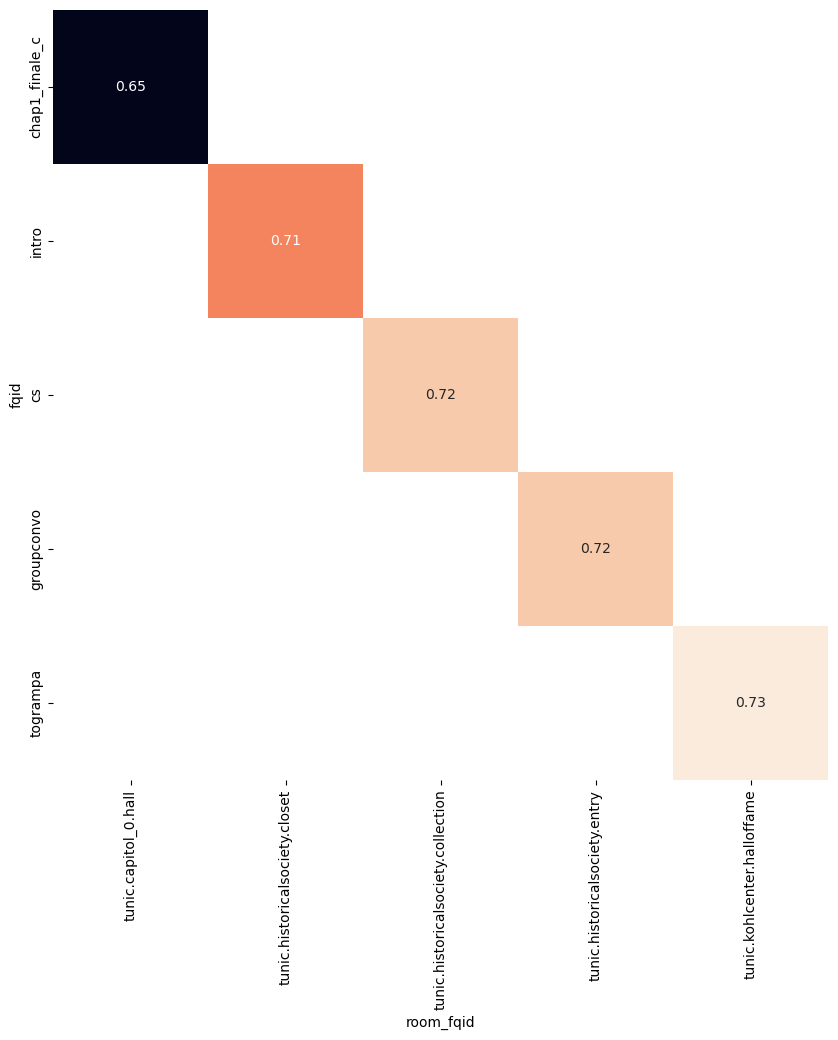

In [43]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

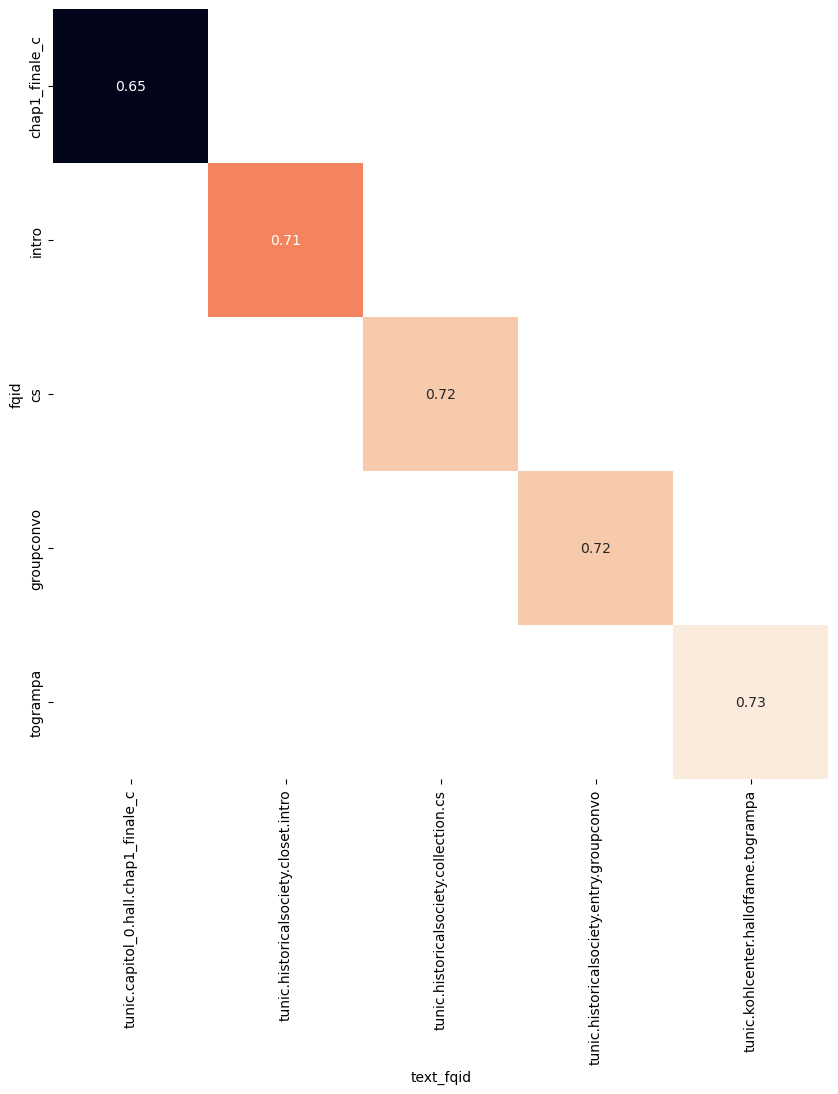

In [44]:
col_pair = ["fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

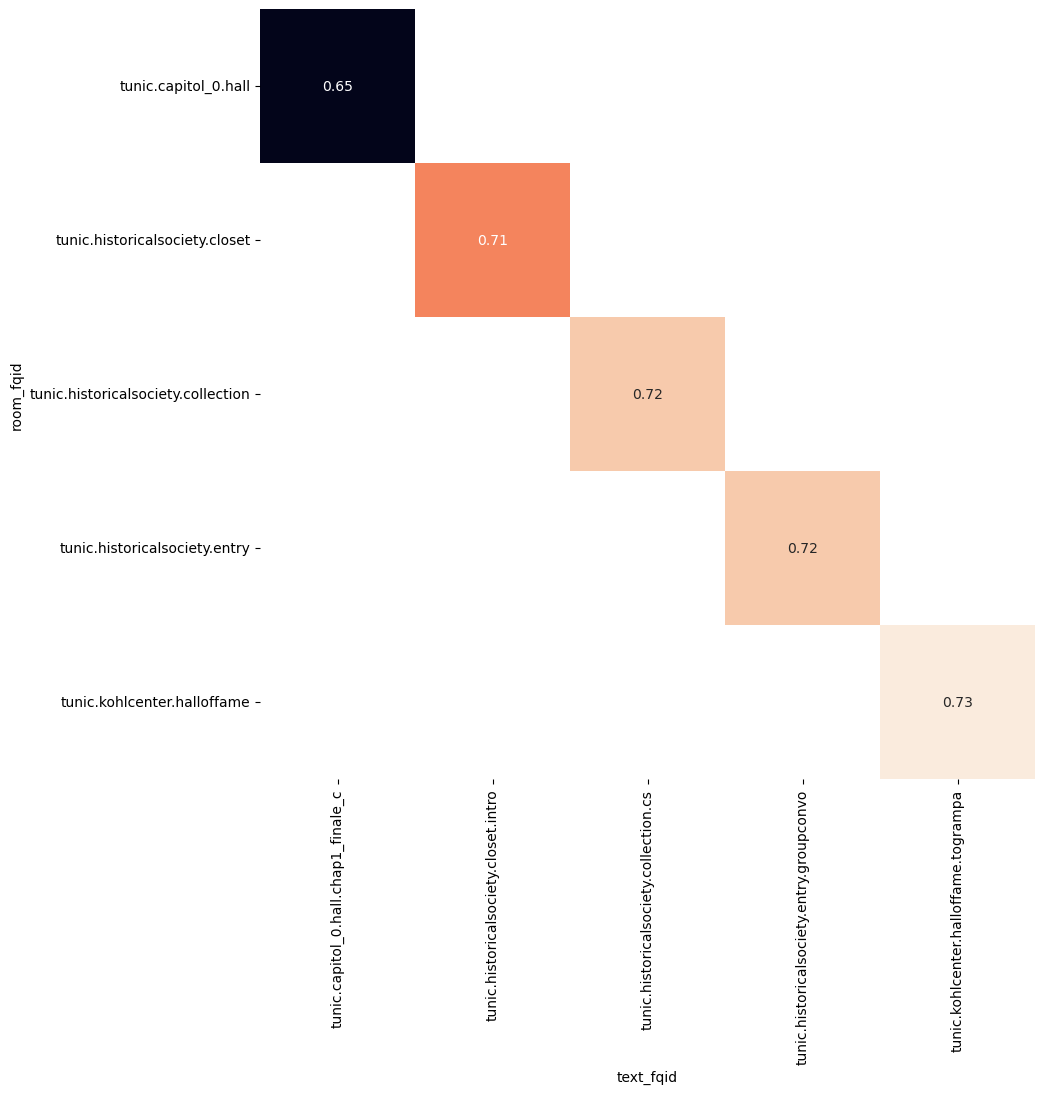

In [45]:
col_pair = ["room_fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

## `event_name` == `"map_click"`

In [46]:
df__map_click = df[df["event_name"] == "map_click"].reset_index(drop=True)
df__map_click.head()

session_id  index  elapsed_time event_name       name  level  page  \
0  20090312431273200    129        135990  map_click  undefined    3.0   NaN   
1  20090312431273200    162        162438  map_click  undefined    4.0   NaN   
2  20090312433251036    104        162990  map_click  undefined    3.0   NaN   
3  20090312433251036    135        192404  map_click      basic    4.0   NaN   
4  20090312433251036    136        193055  map_click  undefined    4.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0        168.0      -142.25          263.0          417.0             NaN   
1       -538.0         6.00          462.0          324.0             NaN   
2        177.5      -168.50          268.0          433.0             NaN   
3       -701.0      -208.00          286.0          538.0             NaN   
4       -553.5        44.00          445.0          286.0             NaN   

        text              fqid                      room_fqid text_fqid  \
0  undefined  tunic.kohlcenter  tunic.historicalsociety.entry       NaN   
1  undefined   tunic.capitol_0    tunic.kohlcenter.halloffame       NaN   
2  undefined  tunic.kohlcenter  tunic.historicalsociety.entry       NaN   
3  undefined               NaN    tunic.kohlcenter.halloffame       NaN   
4  undefined   tunic.capitol_0    tunic.kohlcenter.halloffame       NaN   

  fullscreen hq music  correct  
0          0  0     1        1  
1          0  0     1        1  
2          0  0     0        0  
3          0  0     0        0  
4          0  0     0        0

#### Update Category Fields

In [47]:
df__map_click = recategorize_category_typed_fields(df__map_click)

In [48]:
summary = summarize_data_info(df__map_click)
summary

Data Shape: (54068, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     23562   
index              int16           0.0      1251   
elapsed_time       int32           0.0     49701   
event_name      category           0.0         1   
name            category           0.0         3   
level            float16           0.0         2   
page             float16           1.0         0   
room_coor_x      float16           0.0      4282   
room_coor_y      float16           0.0      4961   
screen_coor_x    float16           0.0      1264   
screen_coor_y    float16           0.0       948   
hover_duration   float32           1.0         0   
text            category           0.0         1   
fqid            category           0.0         4   
room_fqid       category           0.0         3   
text_fqid       category           0.0         1   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                  first_value                 second_value  \
session_id                  20090312431273200            20090312431273200   
index                                     129                          162   
elapsed_time                           135990                       162438   
event_name                          map_click                    map_click   
name                                undefined                    undefined   
level                                     3.0                          4.0   
page                                      NaN                          NaN   
room_coor_x                             168.0                       -538.0   
room_coor_y                           -142.25                          6.0   
screen_coor_x                           263.0                        462.0   
screen_coor_y                           417.0                        324.0   
hover_duration                            NaN                          NaN   
text                                undefined                    undefined   
fqid                         tunic.kohlcenter              tunic.capitol_0   
room_fqid       tunic.historicalsociety.entry  tunic.kohlcenter.halloffame   
text_fqid                                 nan                          nan   
fullscreen                                  0                            0   
hq                                          0                            0   
music                                       1                            1   
correct                                     1                            1   

                                  third_value                  min  \
session_id                  20090312433251036  20090312431273200.0   
index                                     104                  0.0   
elapsed_time                           162990                200.0   
event_name                          map_click                  NaN   
name                                undefined                  NaN   
level                                     3.0                  3.0   
page                                      NaN                  NaN   
room_coor_x                             177.5               -998.0   
room_coor_y                            -168.5              -502.25   
screen_coor_x                           268.0                  0.0   
screen_coor_y                           433.0                  8.0   
hover_duration                            NaN                  NaN   
text                                undefined                  NaN   
fqid                         tunic.kohlcenter                  NaN   
room_fqid       tunic.historicalsociety.entry                  NaN   
text_fqid                                 nan                  NaN   
fullscreen                                  0                  NaN   
hq                     

In [49]:
df__map_click["name"].value_counts()

undefined    48477
basic         4731
close          860
Name: name, dtype: int64

#### Insights

- `name` field has three values (basic, undefined, closed).
- `text` field is constant (undefined).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

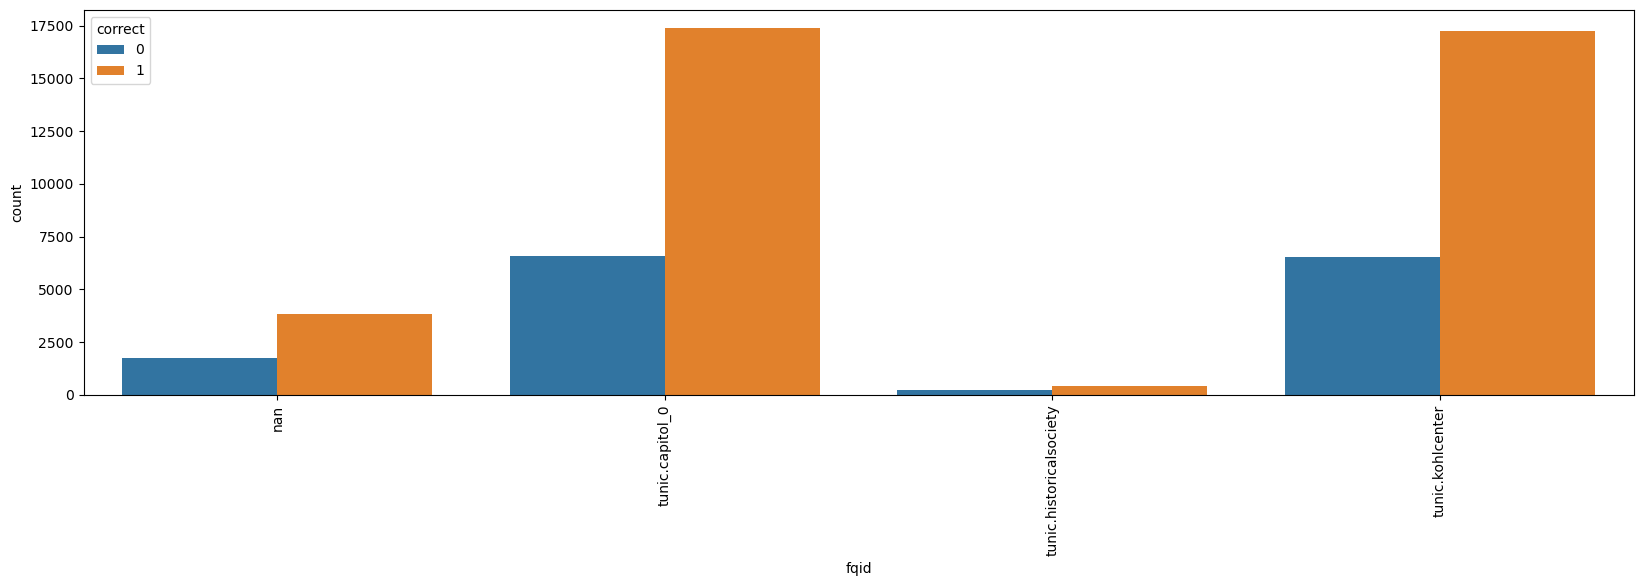

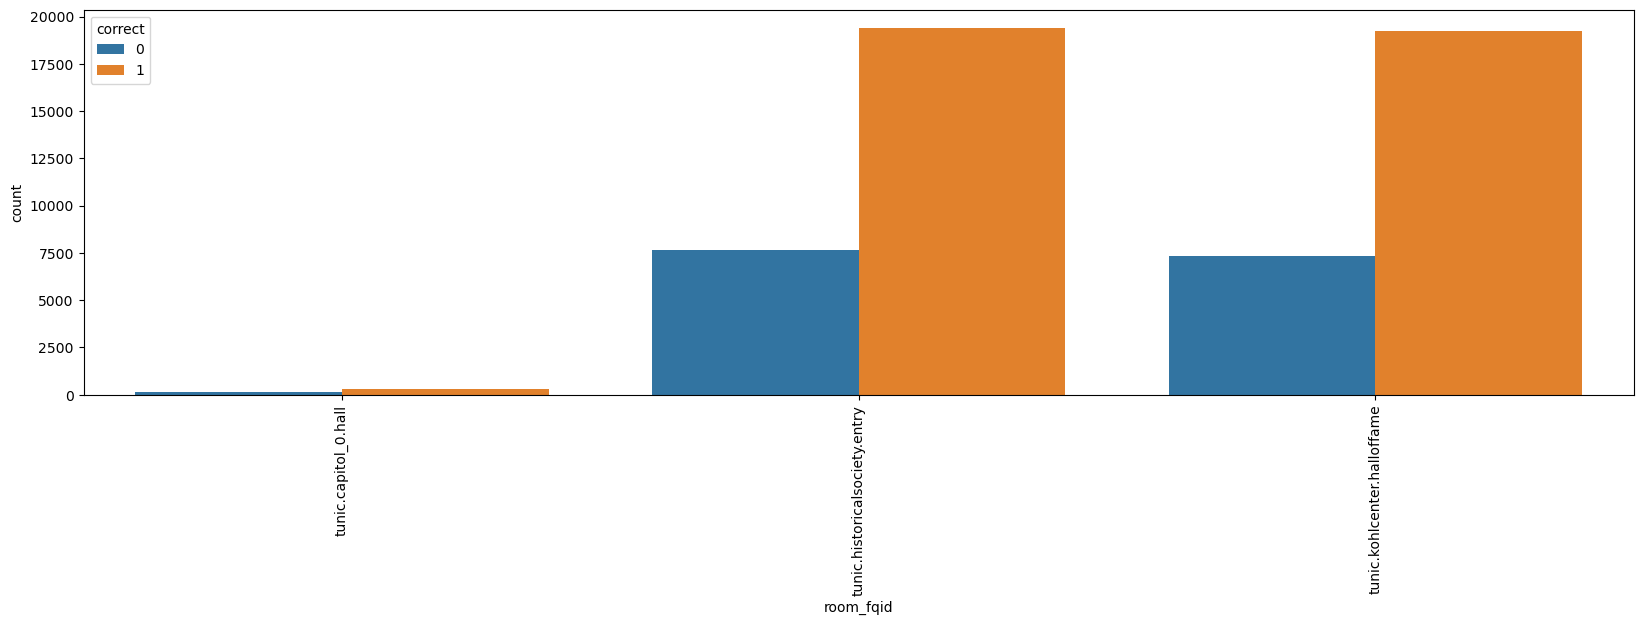

In [50]:
cat_fields_list = ["fqid", "room_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__map_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

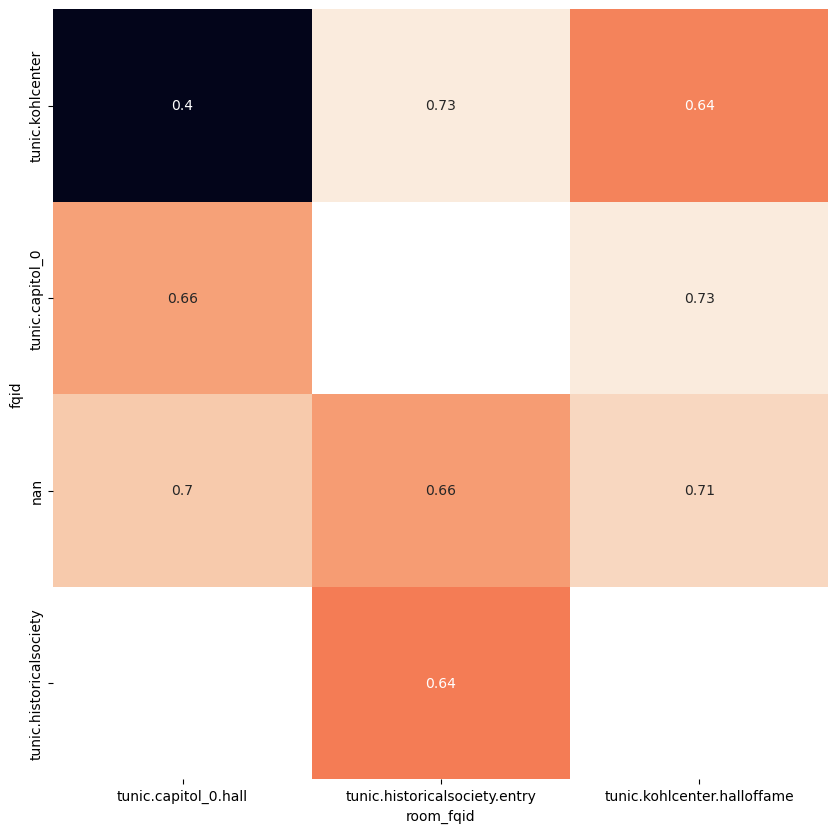

In [51]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__map_click, col_pair), figsize=(10, 10))

## `event_name` == `"map_hover"`

In [52]:
df__map_hover = df[df["event_name"] == "map_hover"].reset_index(drop=True)
df__map_hover.head()

session_id  index  elapsed_time event_name   name  level  page  \
0  20090312431273200    127        135124  map_hover  basic    3.0   NaN   
1  20090312431273200    128        135256  map_hover  basic    3.0   NaN   
2  20090312431273200    160        161405  map_hover  basic    4.0   NaN   
3  20090312431273200    161        161822  map_hover  basic    4.0   NaN   
4  20090312433251036    101        161157  map_hover  basic    3.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0          NaN          NaN            NaN            NaN           234.0   
1          NaN          NaN            NaN            NaN            17.0   
2          NaN          NaN            NaN            NaN           250.0   
3          NaN          NaN            NaN            NaN            17.0   
4          NaN          NaN            NaN            NaN           517.0   

        text                     fqid                      room_fqid  \
0  undefined  tunic.historicalsociety  tunic.historicalsociety.entry   
1  undefined         tunic.kohlcenter  tunic.historicalsociety.entry   
2  undefined                  toentry    tunic.kohlcenter.halloffame   
3  undefined         tunic.kohlcenter    tunic.kohlcenter.halloffame   
4  undefined                    tomap  tunic.historicalsociety.entry   

  text_fqid fullscreen hq music  correct  
0       NaN          0  0     1        1  
1       NaN          0  0     1        1  
2       NaN          0  0     1        1  
3       NaN          0  0     1        1  
4       NaN          0  0     0        0

#### Update Category Fields

In [53]:
df__map_hover = recategorize_category_typed_fields(df__map_hover)

In [54]:
summary = summarize_data_info(df__map_hover)
summary

Data Shape: (45130, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     19330   
index              int16           0.0      1001   
elapsed_time       int32           0.0     42053   
event_name      category           0.0         1   
name            category           0.0         1   
level            float16           0.0         2   
page             float16           1.0         0   
room_coor_x      float16           1.0         0   
room_coor_y      float16           1.0         0   
screen_coor_x    float16           1.0         0   
screen_coor_y    float16           1.0         0   
hover_duration   float32           0.0      1996   
text            category           0.0         1   
fqid            category           0.0         8   
room_fqid       category           0.0         3   
text_fqid       category           0.0         1   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                  first_value                   second_value  \
session_id                  20090312431273200              20090312431273200   
index                                     127                            128   
elapsed_time                           135124                         135256   
event_name                          map_hover                      map_hover   
name                                    basic                          basic   
level                                     3.0                            3.0   
page                                      NaN                            NaN   
room_coor_x                               NaN                            NaN   
room_coor_y                               NaN                            NaN   
screen_coor_x                             NaN                            NaN   
screen_coor_y                             NaN                            NaN   
hover_duration                          234.0                           17.0   
text                                undefined                      undefined   
fqid                  tunic.historicalsociety               tunic.kohlcenter   
room_fqid       tunic.historicalsociety.entry  tunic.historicalsociety.entry   
text_fqid                                 nan                            nan   
fullscreen                                  0                              0   
hq                                          0                              0   
music                                       1                              1   
correct                                     1                              1   

                                third_value                  min  \
session_id                20090312431273200  20090312431273200.0   
index                                   160                  0.0   
elapsed_time                         161405                 16.0   
event_name                        map_hover                  NaN   
name                                  basic                  NaN   
level                                   4.0                  3.0   
page                                    NaN                  NaN   
room_coor_x                             NaN                  NaN   
room_coor_y                             NaN                  NaN   
screen_coor_x                           NaN                  NaN   
screen_coor_y                           NaN                  NaN   
hover_duration                        250.0                  0.0   
text                              undefined                  NaN   
fqid                                toentry                  NaN   
room_fqid       tunic.kohlcenter.halloffame                  NaN   
text_fqid                               nan                  NaN   
fullscreen                                0                  NaN   
hq               

#### Insights

- `name` field is constant (basic).
- `text` field is constant (undefined).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `room_coor_x`
    - `room_coor_y`
    - `screen_coor_x`
    - `screen_coor_y`

#### Categorical Fields

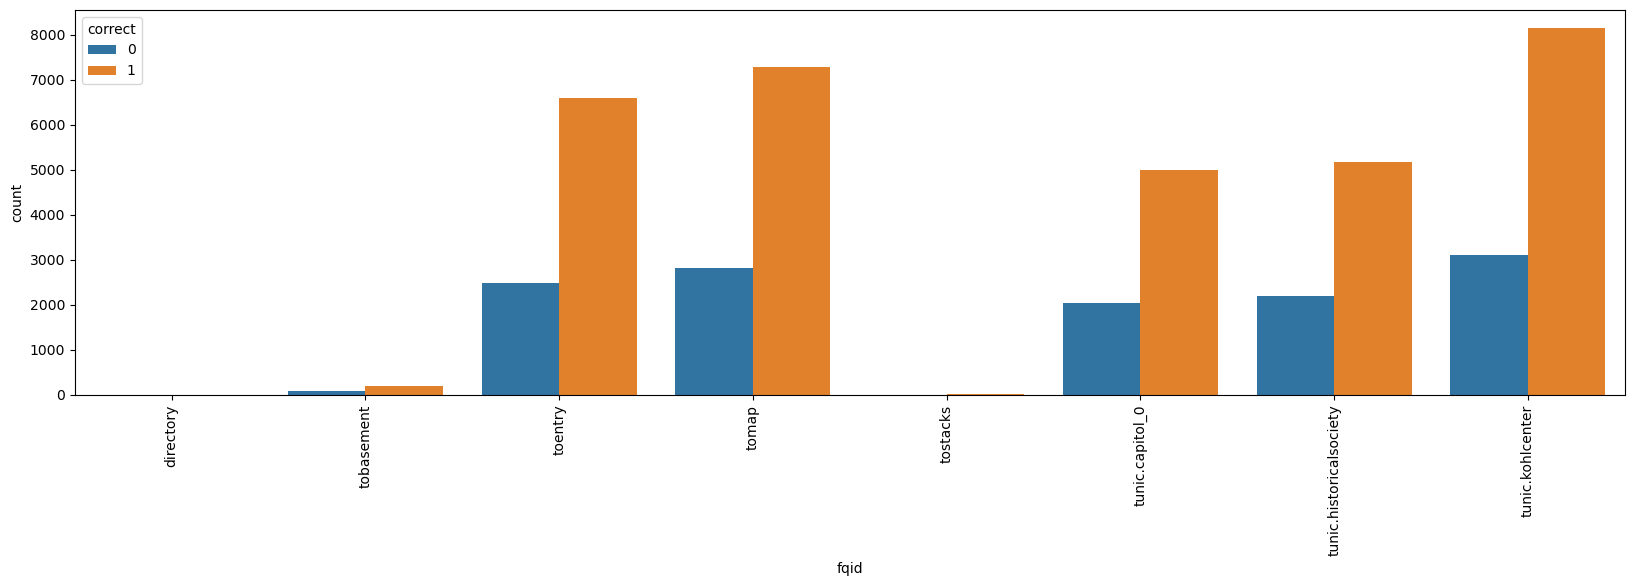

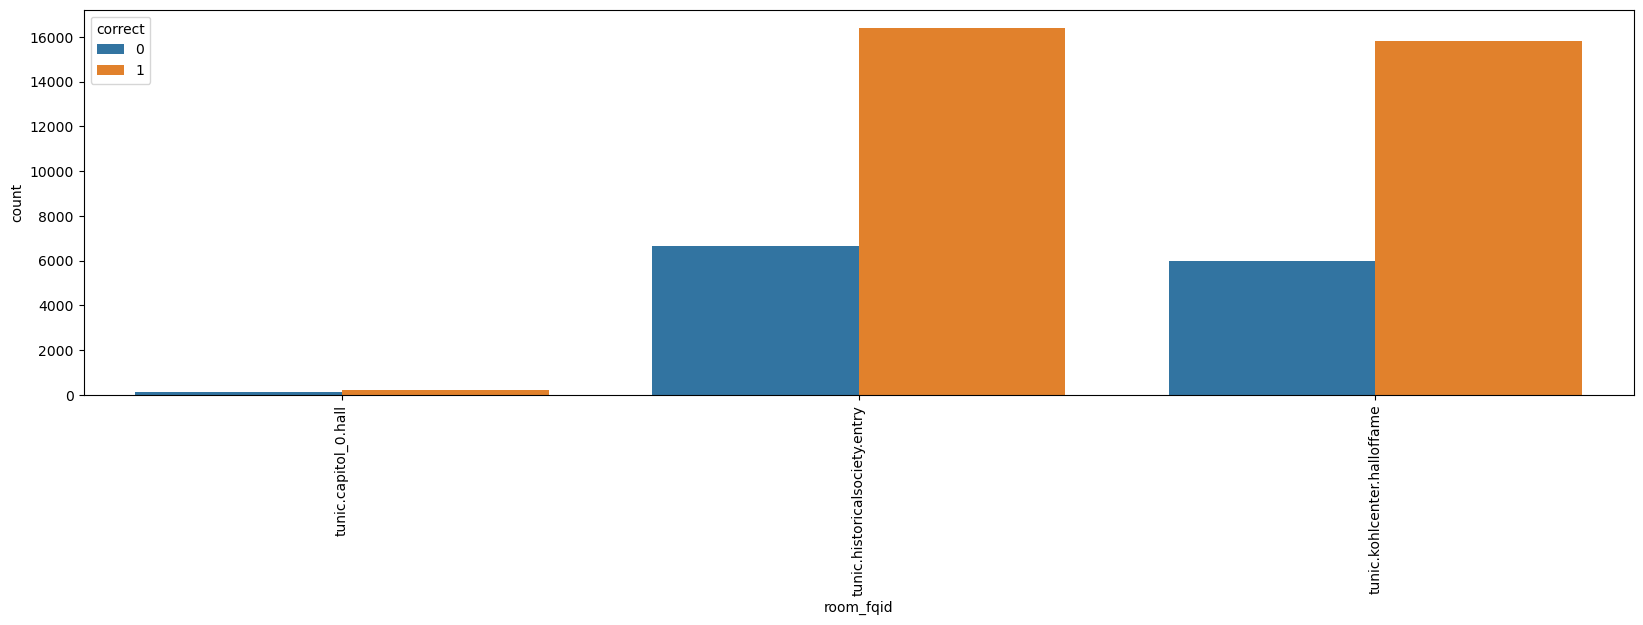

In [55]:
cat_fields_list = ["fqid", "room_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__map_hover, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

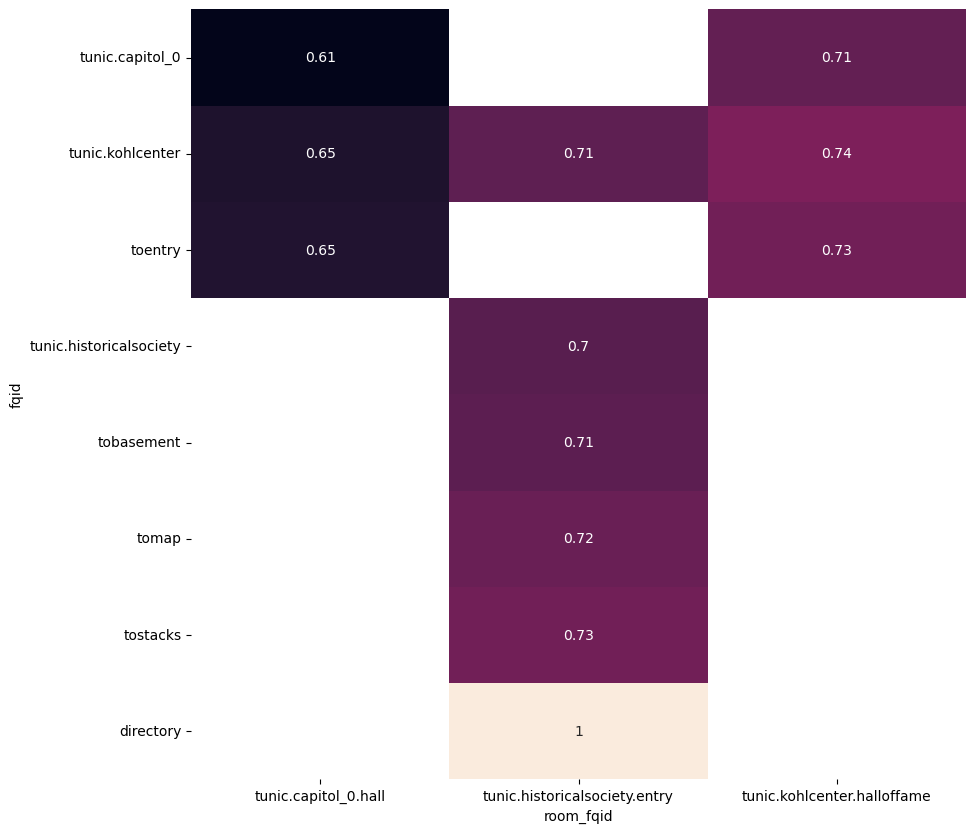

In [56]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__map_hover, col_pair), figsize=(10, 10))

## `event_name` == `"navigate_click"`

In [57]:
df__navigate_click = df[df["event_name"] == "navigate_click"].reset_index(drop=True)
df__navigate_click.head()

session_id  index  elapsed_time      event_name       name  level  \
0  20090312431273200     10          9133  navigate_click  undefined    0.0   
1  20090312431273200     12         12030  navigate_click  undefined    0.0   
2  20090312431273200     14         14814  navigate_click  undefined    0.0   
3  20090312431273200     15         15498  navigate_click  undefined    0.0   
4  20090312431273200     16         16046  navigate_click  undefined    0.0   

   page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0   NaN   501.000000     -160.750          605.0          445.0   
1   NaN   510.000000     -106.375          614.0          386.0   
2   NaN   274.000000     -196.750          406.0          486.0   
3   NaN   185.750000     -205.750          363.0          492.0   
4   NaN     0.583496     -225.750          234.0          510.0   

   hover_duration       text   fqid                       room_fqid text_fqid  \
0             NaN  undefined  teddy  tunic.historicalsociety.closet       NaN   
1             NaN  undefined  photo  tunic.historicalsociety.closet       NaN   
2             NaN  undefined    NaN  tunic.historicalsociety.closet       NaN   
3             NaN  undefined    NaN  tunic.historicalsociety.closet       NaN   
4             NaN  undefined    NaN  tunic.historicalsociety.closet       NaN   

  fullscreen hq music  correct  
0          0  0     1        1  
1          0  0     1        1  
2          0  0     1        1  
3          0  0     1        1  
4          0  0     1        1

#### Update Category Fields

In [58]:
df__navigate_click = recategorize_category_typed_fields(df__navigate_click)

In [59]:
summary = summarize_data_info(df__navigate_click)
summary

Data Shape: (1807806, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     23562   
index              int16           0.0      3162   
elapsed_time       int32           0.0    440016   
event_name      category           0.0         1   
name            category           0.0         1   
level            float16           0.0         5   
page             float16           1.0         0   
room_coor_x      float16           0.0     22024   
room_coor_y      float16           0.0     19530   
screen_coor_x    float16           0.0      5211   
screen_coor_y    float16           0.0      2846   
hover_duration   float32           1.0         0   
text            category           0.0         1   
fqid            category           0.0        26   
room_fqid       category           0.0         7   
text_fqid       category           0.0         1   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                   first_value  \
session_id                   20090312431273200   
index                                       10   
elapsed_time                              9133   
event_name                      navigate_click   
name                                 undefined   
level                                      0.0   
page                                       NaN   
room_coor_x                              501.0   
room_coor_y                            -160.75   
screen_coor_x                            605.0   
screen_coor_y                            445.0   
hover_duration                             NaN   
text                                 undefined   
fqid                                     teddy   
room_fqid       tunic.historicalsociety.closet   
text_fqid                                  nan   
fullscreen                                   0   
hq                                           0   
music                                        1   
correct                                      1   

                                  second_value  \
session_id                   20090312431273200   
index                                       12   
elapsed_time                             12030   
event_name                      navigate_click   
name                                 undefined   
level                                      0.0   
page                                       NaN   
room_coor_x                              510.0   
room_coor_y                           -106.375   
screen_coor_x                            614.0   
screen_coor_y                            386.0   
hover_duration                             NaN   
text                                 undefined   
fqid                                     photo   
room_fqid       tunic.historicalsociety.closet   
text_fqid                                  nan   
fullscreen                                   0   
hq                                           0   
music                                        1   
correct                                      1   

                                   third_value                  min  \
session_id                   20090312431273200  20090312431273200.0   
index                                       14                  0.0   
elapsed_time                             14814                  0.0   
event_name                      navigate_click                  NaN   
name                                 undefined                  NaN   
level                                      0.0                  0.0   
page                                       NaN                  NaN   
room_coor_x                              274.0              -1218.0   
room_coor_y                            -196.75               -591.5   
screen_coor_x                            406.0                  0.0   
screen_coor_y                          

#### Insights

- `name` field is constant (undefined).
- `text` field is constant (undefined).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

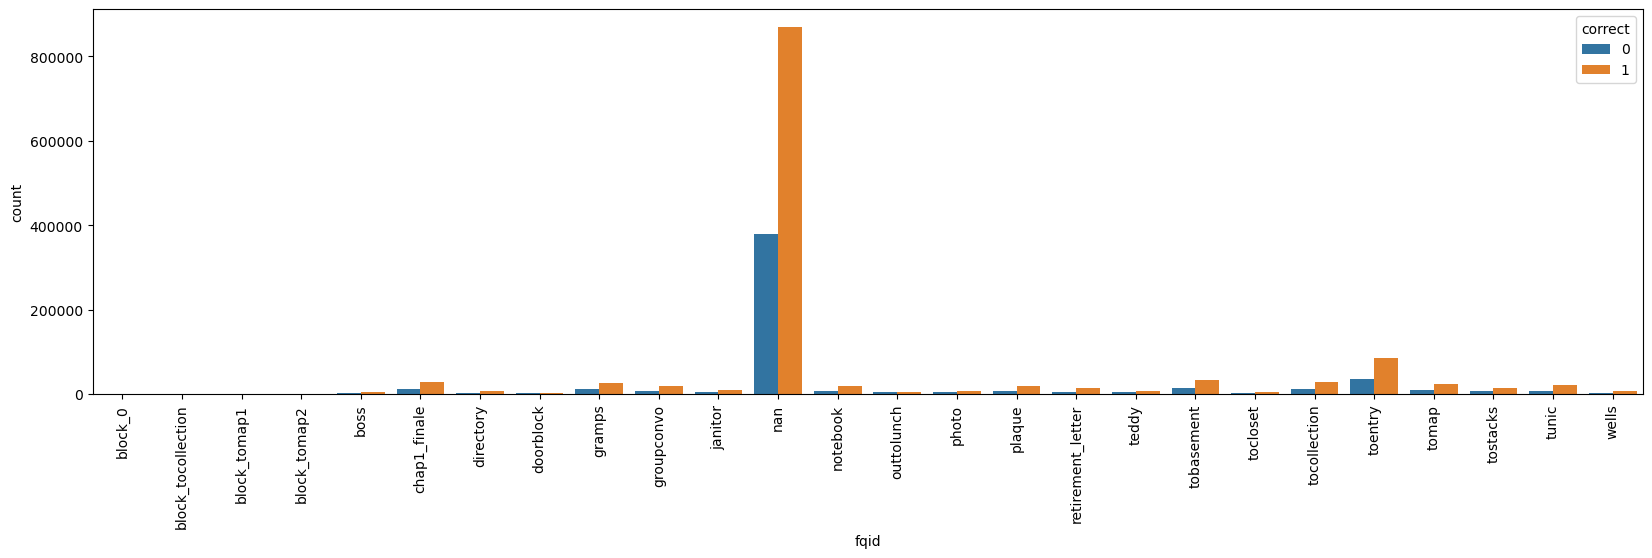

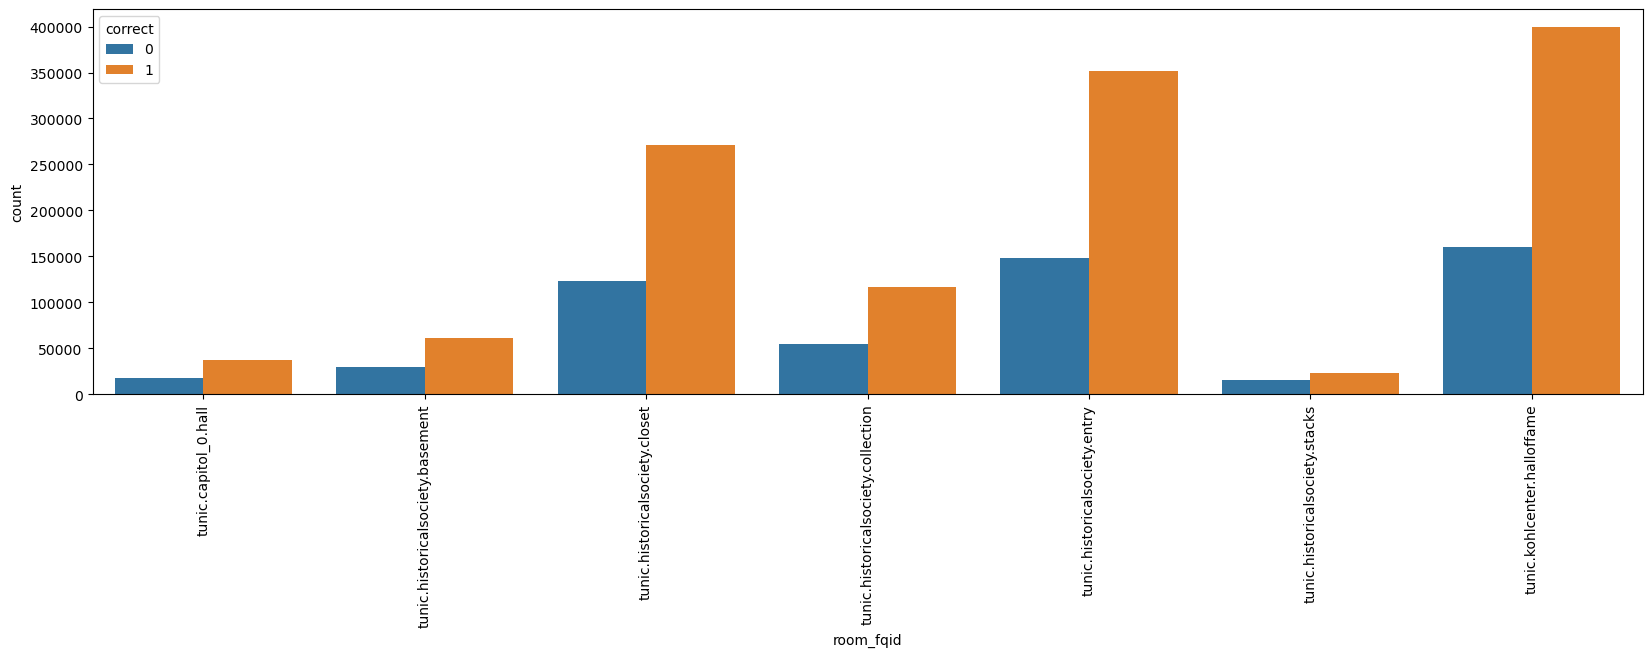

In [60]:
cat_fields_list = ["fqid", "room_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__navigate_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

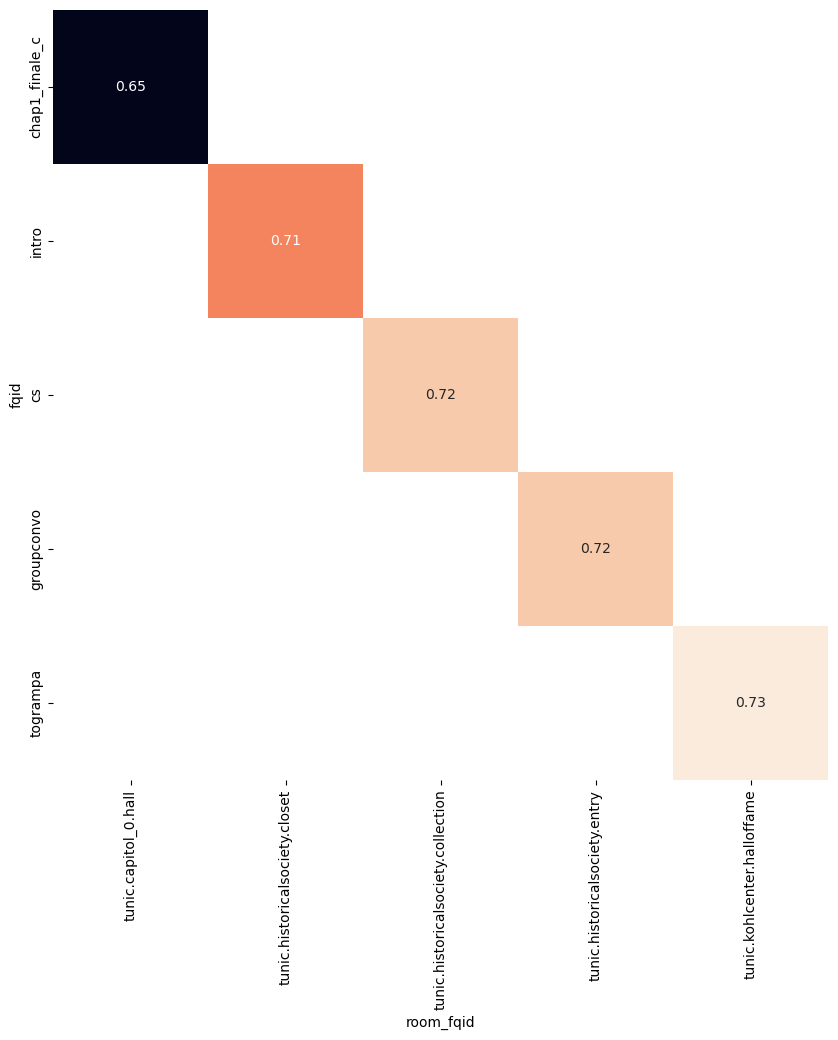

In [61]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__cutscene_click, col_pair), figsize=(10, 10))

## `event_name` == `"notebook_click"`

In [62]:
df__notebook_click = df[df["event_name"] == "notebook_click"].reset_index(drop=True)
df__notebook_click.head()

session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312433251036     60         60743  notebook_click   open    2.0   0.0   
1  20090312433251036     61         61761  notebook_click  close    2.0   0.0   
2  20090313091715820    123         80710  notebook_click   open    3.0   0.0   
3  20090313091715820    124         82222  notebook_click  close    3.0   0.0   
4  20090313571836404     47         72818  notebook_click   open    2.0   0.0   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0     -1112.00      -518.50           30.0          639.0             NaN   
1        73.25       428.25          789.0           58.0             NaN   
2      -564.00      -431.75           33.0          731.0             NaN   
3       594.00       403.25          969.0           56.0             NaN   
4      -481.00      -486.25           38.0          616.0             NaN   

        text fqid                           room_fqid text_fqid fullscreen hq  \
0  undefined  NaN       tunic.historicalsociety.entry       NaN          0  0   
1  undefined  NaN       tunic.historicalsociety.entry       NaN          0  0   
2  undefined  NaN  tunic.historicalsociety.collection       NaN          1  1   
3  undefined  NaN  tunic.historicalsociety.collection       NaN          1  1   
4  undefined  NaN       tunic.historicalsociety.entry       NaN          0  0   

  music  correct  
0     0        0  
1     0        0  
2     1        0  
3     1        0  
4     1        1

#### Update Category Fields

In [63]:
df__notebook_click = recategorize_category_typed_fields(df__notebook_click)

In [64]:
summary = summarize_data_info(df__notebook_click)
summary

Data Shape: (81733, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     13943   
index              int16           0.0      1262   
elapsed_time       int32           0.0     72223   
event_name      category           0.0         1   
name            category           0.0         5   
level            float16           0.0         4   
page             float16           0.0         2   
room_coor_x      float16           0.0      8913   
room_coor_y      float16           0.0      5529   
screen_coor_x    float16           0.0      1854   
screen_coor_y    float16           0.0      1451   
hover_duration   float32           1.0         0   
text            category           0.0         1   
fqid            category           0.0         1   
room_fqid       category           0.0         6   
text_fqid       category           0.0         1   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                  first_value                   second_value  \
session_id                  20090312433251036              20090312433251036   
index                                      60                             61   
elapsed_time                            60743                          61761   
event_name                     notebook_click                 notebook_click   
name                                     open                          close   
level                                     2.0                            2.0   
page                                      0.0                            0.0   
room_coor_x                           -1112.0                          73.25   
room_coor_y                            -518.5                         428.25   
screen_coor_x                            30.0                          789.0   
screen_coor_y                           639.0                           58.0   
hover_duration                            NaN                            NaN   
text                                undefined                      undefined   
fqid                                      nan                            nan   
room_fqid       tunic.historicalsociety.entry  tunic.historicalsociety.entry   
text_fqid                                 nan                            nan   
fullscreen                                  0                              0   
hq                                          0                              0   
music                                       0                              0   
correct                                     0                              0   

                                       third_value                  min  \
session_id                       20090313091715820  20090312433251036.0   
index                                          123                  0.0   
elapsed_time                                 80710               9183.0   
event_name                          notebook_click                  NaN   
name                                          open                  NaN   
level                                          3.0                  1.0   
page                                           0.0                  0.0   
room_coor_x                                 -564.0              -1182.0   
room_coor_y                                -431.75               -560.5   
screen_coor_x                                 33.0                  0.0   
screen_coor_y                                731.0                  0.0   
hover_duration                                 NaN                  NaN   
text                                     undefined                  NaN   
fqid                                           nan                  NaN   
room_fqid       tunic.historicalsociety.collection                  NaN   
text_fqid                                

In [65]:
df__notebook_click["name"].value_counts(dropna=False)

open     33179
close    33174
basic    13863
prev      1007
next       510
Name: name, dtype: int64

In [66]:
df__notebook_click["page"].value_counts(dropna=False)

0.0    65446
1.0    16287
Name: page, dtype: int64

#### Insights

- `name` field has 5 different values (open, close, basic, prev, next).
- `page` field has 4 different values (0, 1, 2, 3).
- `text` field is constant (undefined).
- `fqid` field is constant (nan).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `hover_duration`

#### Categorical Fields

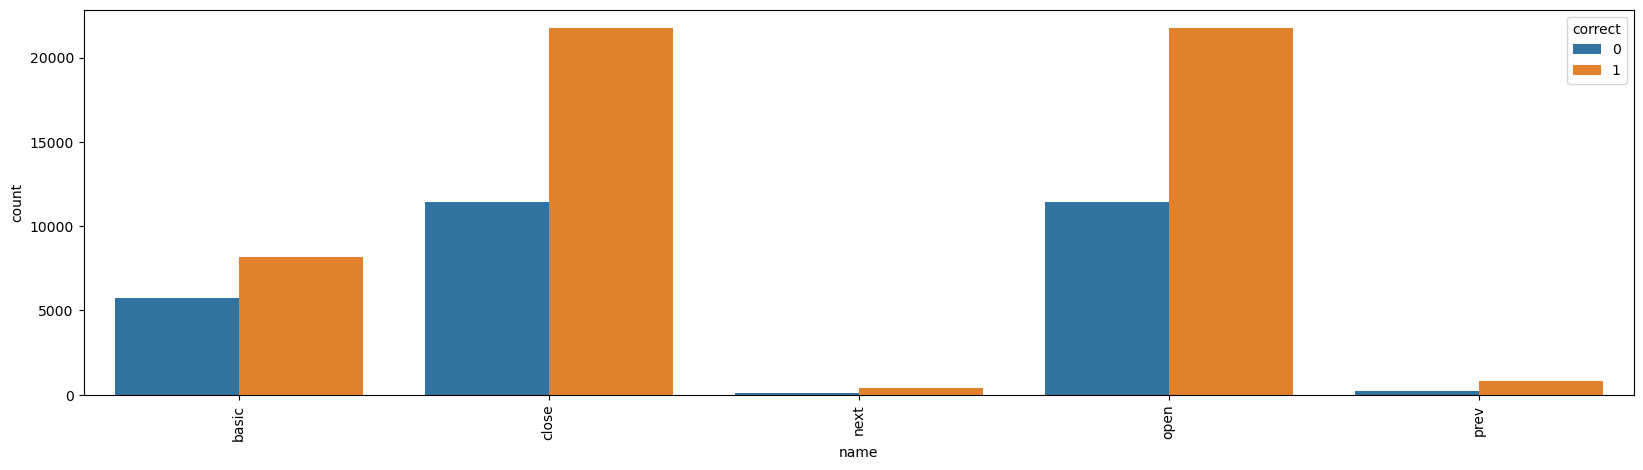

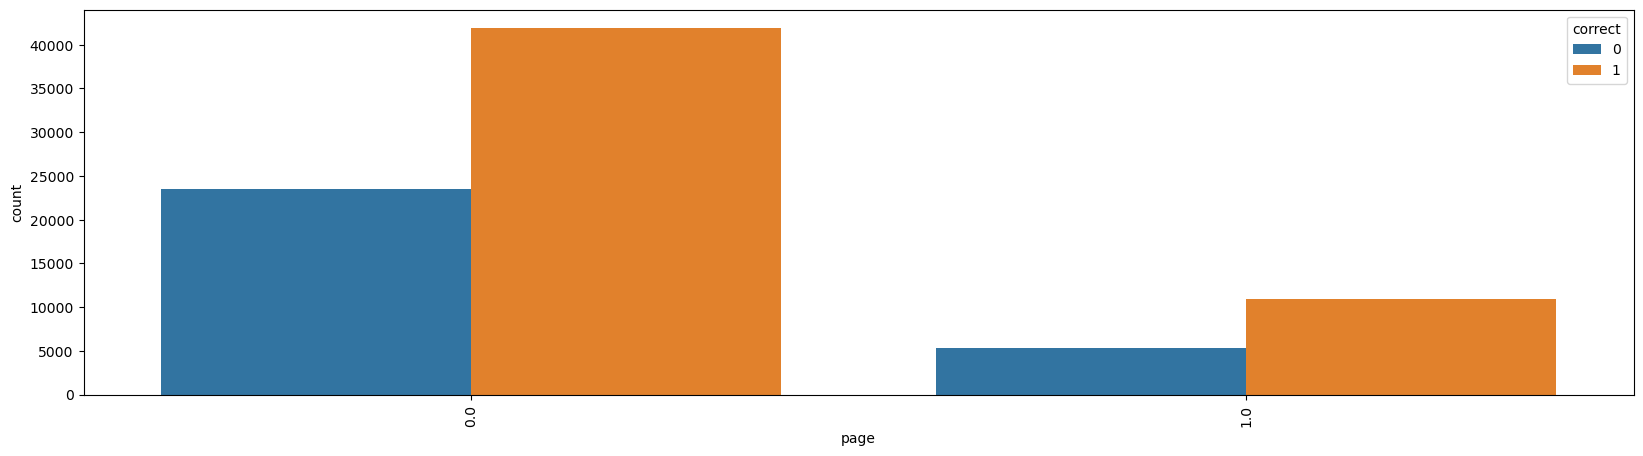

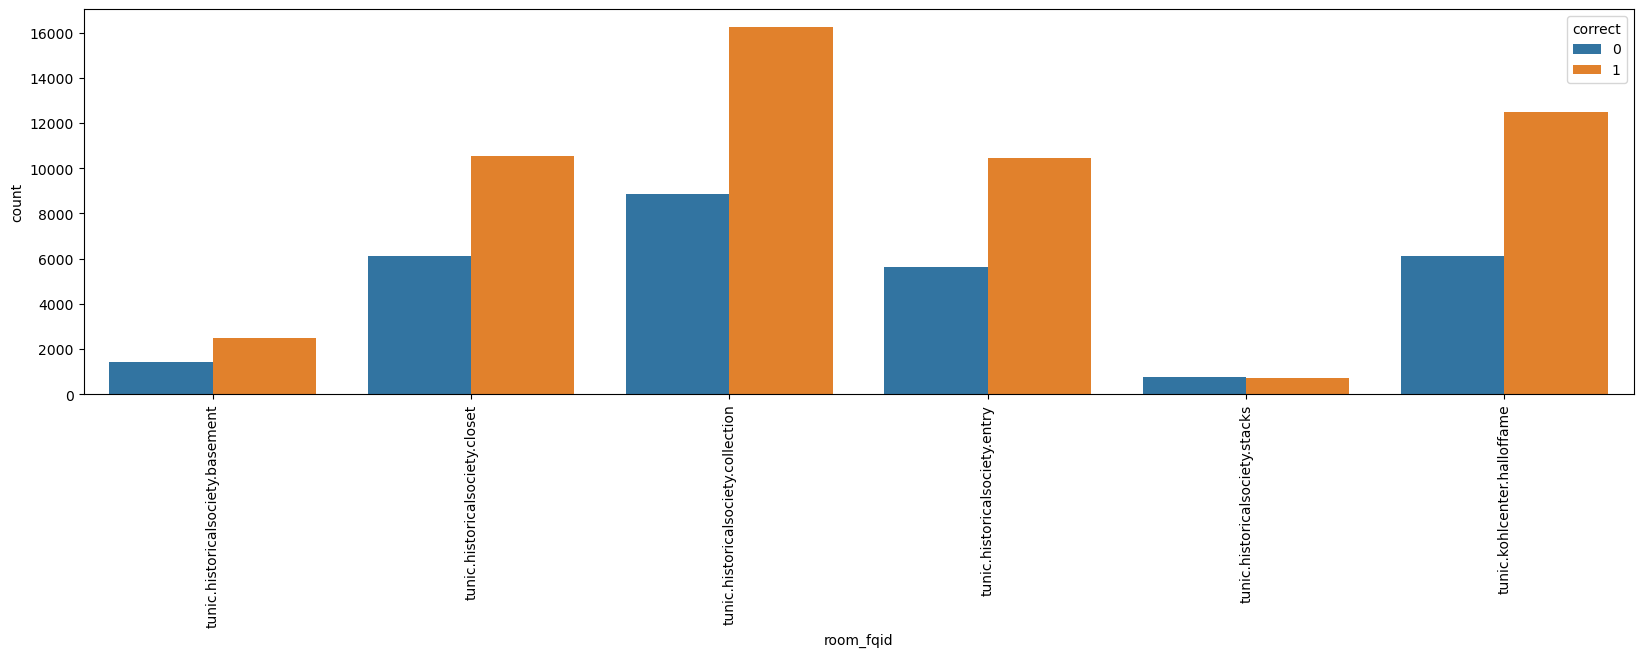

In [67]:
cat_fields_list = ["name", "page", "room_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__notebook_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

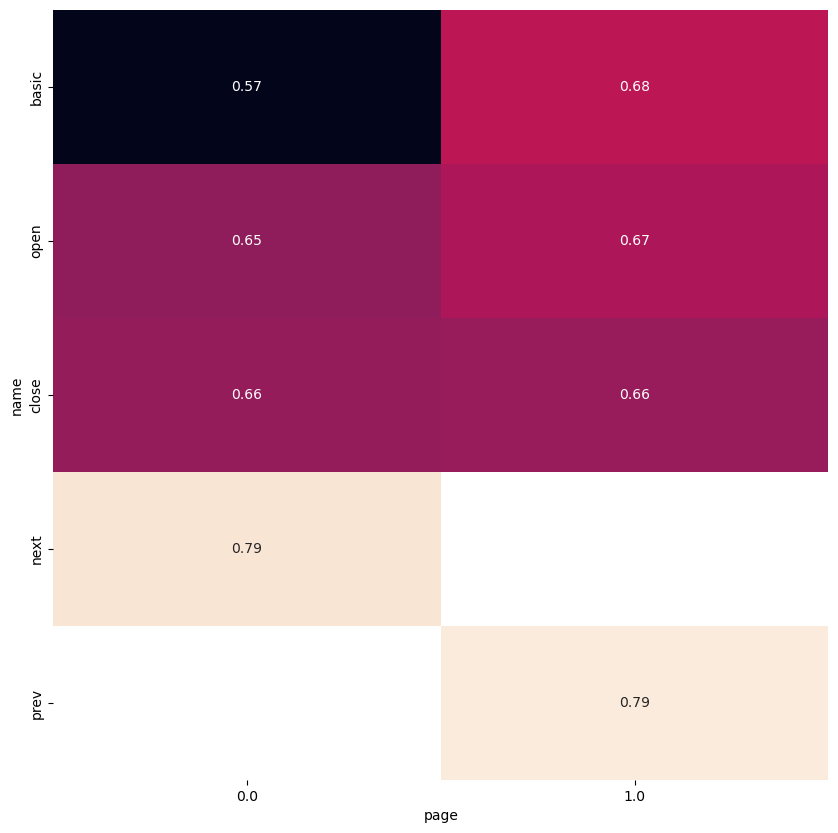

In [68]:
col_pair = ["name", "page"]
plot_heatmap(get_heatmap_values(df__notebook_click, col_pair), figsize=(10, 10))

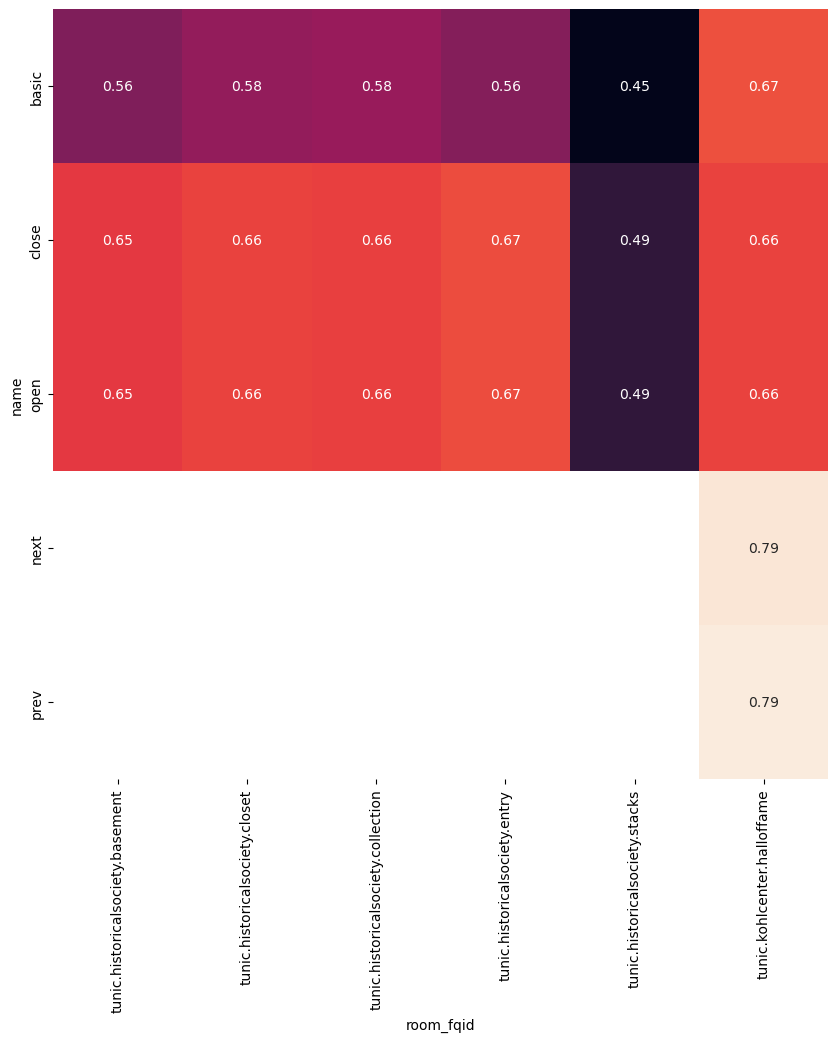

In [69]:
col_pair = ["name", "room_fqid"]
plot_heatmap(get_heatmap_values(df__notebook_click, col_pair), figsize=(10, 10))

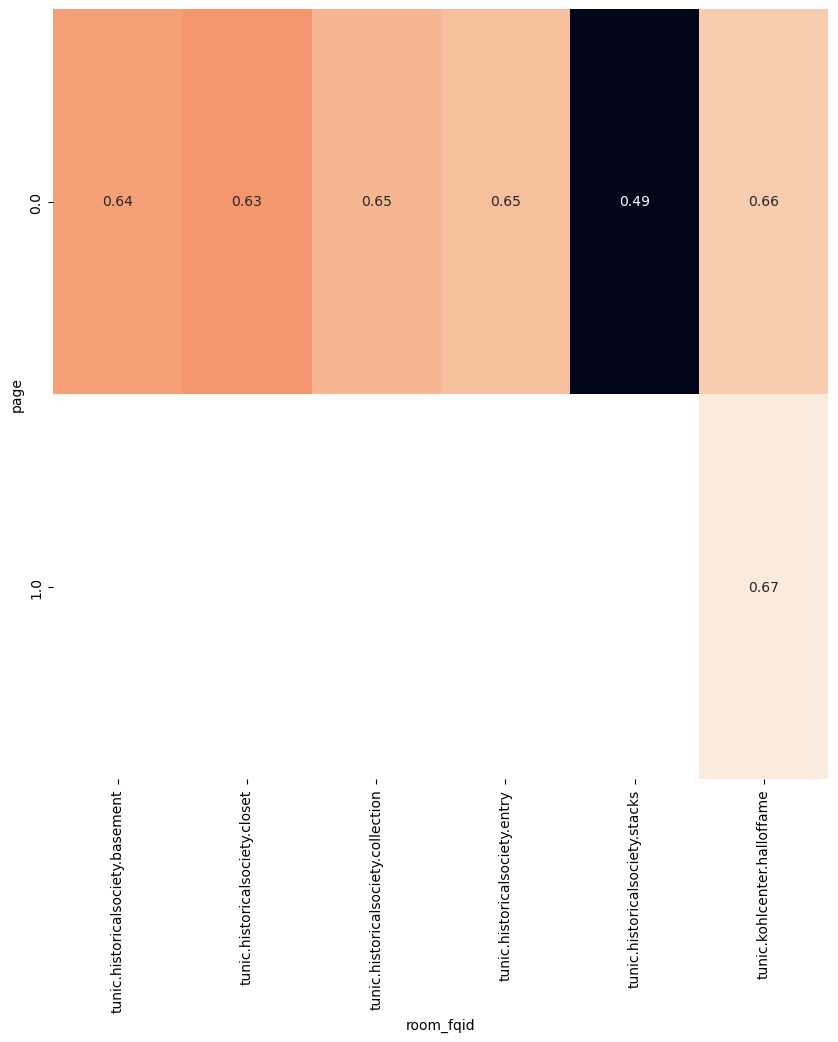

In [70]:
col_pair = ["page", "room_fqid"]
plot_heatmap(get_heatmap_values(df__notebook_click, col_pair), figsize=(10, 10))

## `event_name` == `"notification_click"`

In [71]:
df__notification_click = df[df["event_name"] == "notification_click"].reset_index(drop=True)
df__notification_click.head()

session_id  index  elapsed_time          event_name   name  level  \
0  20090312431273200     26         24348  notification_click  basic    0.0   
1  20090312431273200     29         32229  notification_click  basic    1.0   
2  20090312431273200     30         33063  notification_click  basic    1.0   
3  20090312431273200     31         34245  notification_click  basic    1.0   
4  20090312431273200     85         89809  notification_click  basic    2.0   

   page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0   NaN     -472.250   -117.93750          554.0          394.0   
1   NaN     -182.500     -1.90625          767.0          305.0   
2   NaN     -182.500    -55.87500          767.0          359.0   
3   NaN     -182.500    -55.87500          767.0          359.0   
4   NaN      -86.875    -96.81250          355.0          397.0   

   hover_duration                                     text fqid  \
0             NaN                                Found it!  NaN   
1             NaN  Gramps is in trouble for losing papers?  NaN   
2             NaN                     This can't be right!  NaN   
3             NaN             Gramps is a great historian!  NaN   
4             NaN                  This looks like a clue!  NaN   

                            room_fqid  \
0      tunic.historicalsociety.closet   
1      tunic.historicalsociety.closet   
2      tunic.historicalsociety.closet   
3      tunic.historicalsociety.closet   
4  tunic.historicalsociety.collection   

                                           text_fqid fullscreen hq music  \
0            tunic.historicalsociety.closet.notebook          0  0     1   
1  tunic.historicalsociety.closet.retirement_lett...          0  0     1   
2  tunic.historicalsociety.closet.retirement_lett...          0  0     1   
3  tunic.historicalsociety.closet.retirement_lett...          0  0     1   
4      tunic.historicalsociety.collection.tunic.slip          0  0     1   

   correct  
0        1  
1        1  
2        1  
3        1  
4        1

#### Update Category Fields

In [72]:
df__notification_click = recategorize_category_typed_fields(df__notification_click)

In [73]:
summary = summarize_data_info(df__notification_click)
summary

Data Shape: (183243, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     23562   
index              int16           0.0      1864   
elapsed_time       int32           0.0    129241   
event_name      category           0.0         1   
name            category           0.0         1   
level            float16           0.0         4   
page             float16           1.0         0   
room_coor_x      float16           0.0      9947   
room_coor_y      float16           0.0      9803   
screen_coor_x    float16           0.0      1877   
screen_coor_y    float16           0.0      1731   
hover_duration   float32           1.0         0   
text            category           0.0        11   
fqid            category           0.0         1   
room_fqid       category           0.0         3   
text_fqid       category           0.0         5   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                            first_value  \
session_id                            20090312431273200   
index                                                26   
elapsed_time                                      24348   
event_name                           notification_click   
name                                              basic   
level                                               0.0   
page                                                NaN   
room_coor_x                                     -472.25   
room_coor_y                                   -117.9375   
screen_coor_x                                     554.0   
screen_coor_y                                     394.0   
hover_duration                                      NaN   
text                                          Found it!   
fqid                                                nan   
room_fqid                tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.notebook   
fullscreen                                            0   
hq                                                    0   
music                                                 1   
correct                                               1   

                                                     second_value  \
session_id                                      20090312431273200   
index                                                          29   
elapsed_time                                                32229   
event_name                                     notification_click   
name                                                        basic   
level                                                         1.0   
page                                                          NaN   
room_coor_x                                                -182.5   
room_coor_y                                              -1.90625   
screen_coor_x                                               767.0   
screen_coor_y                                               305.0   
hover_duration                                                NaN   
text                      Gramps is in trouble for losing papers?   
fqid                                                          nan   
room_fqid                          tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.retirement_lett...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
correct                                                         1   

                                                      third_value  \
session_id                                      20090312431273200   
index                                                          30   
elapsed_time             

#### Insights

- `name` field is constant (basic).
- `fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

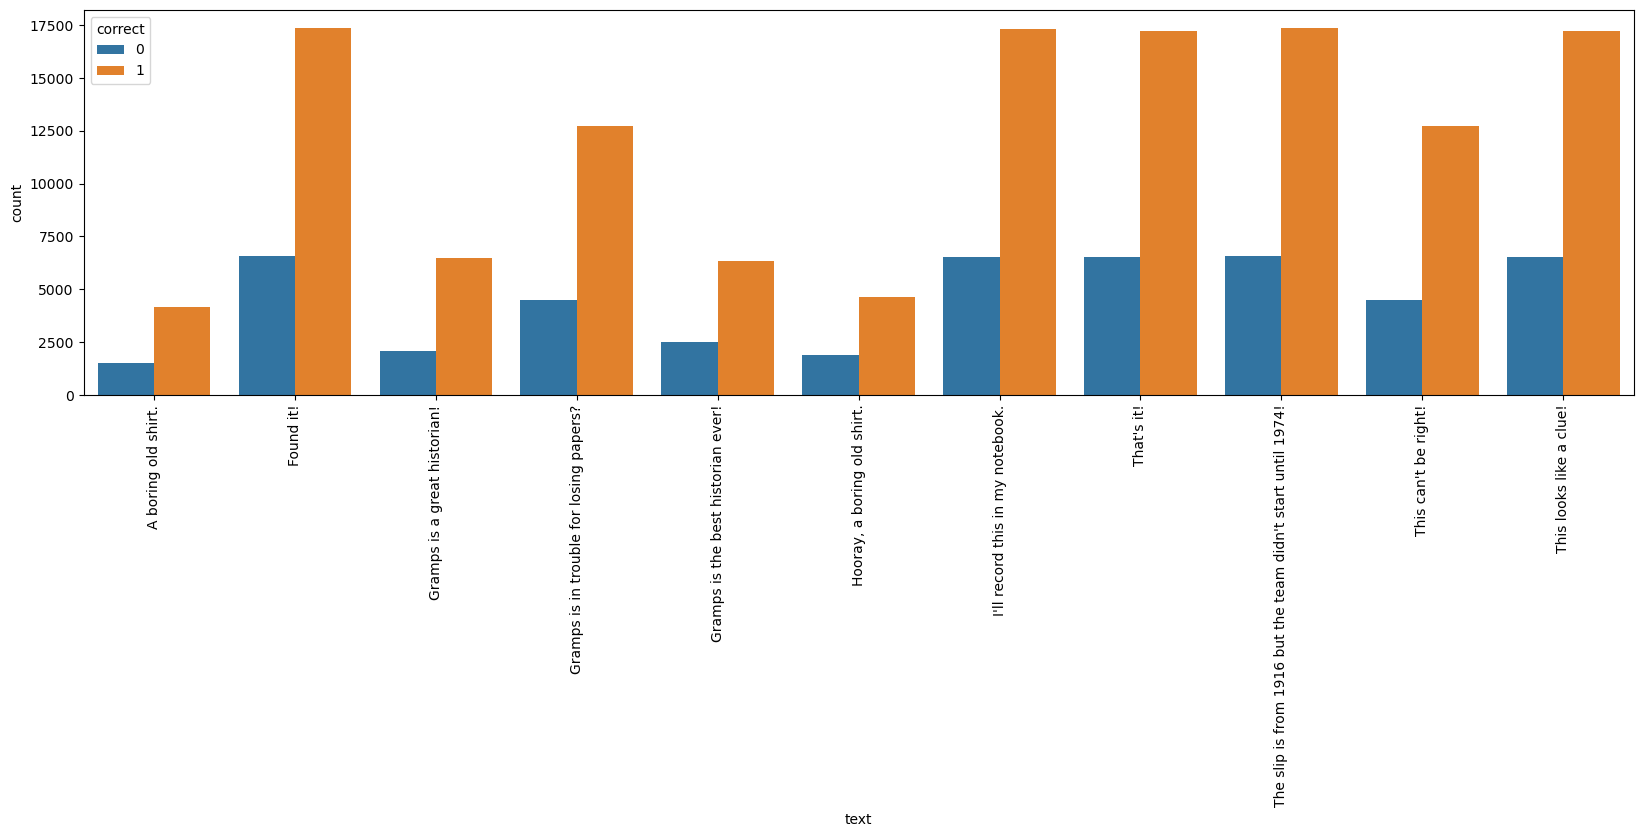

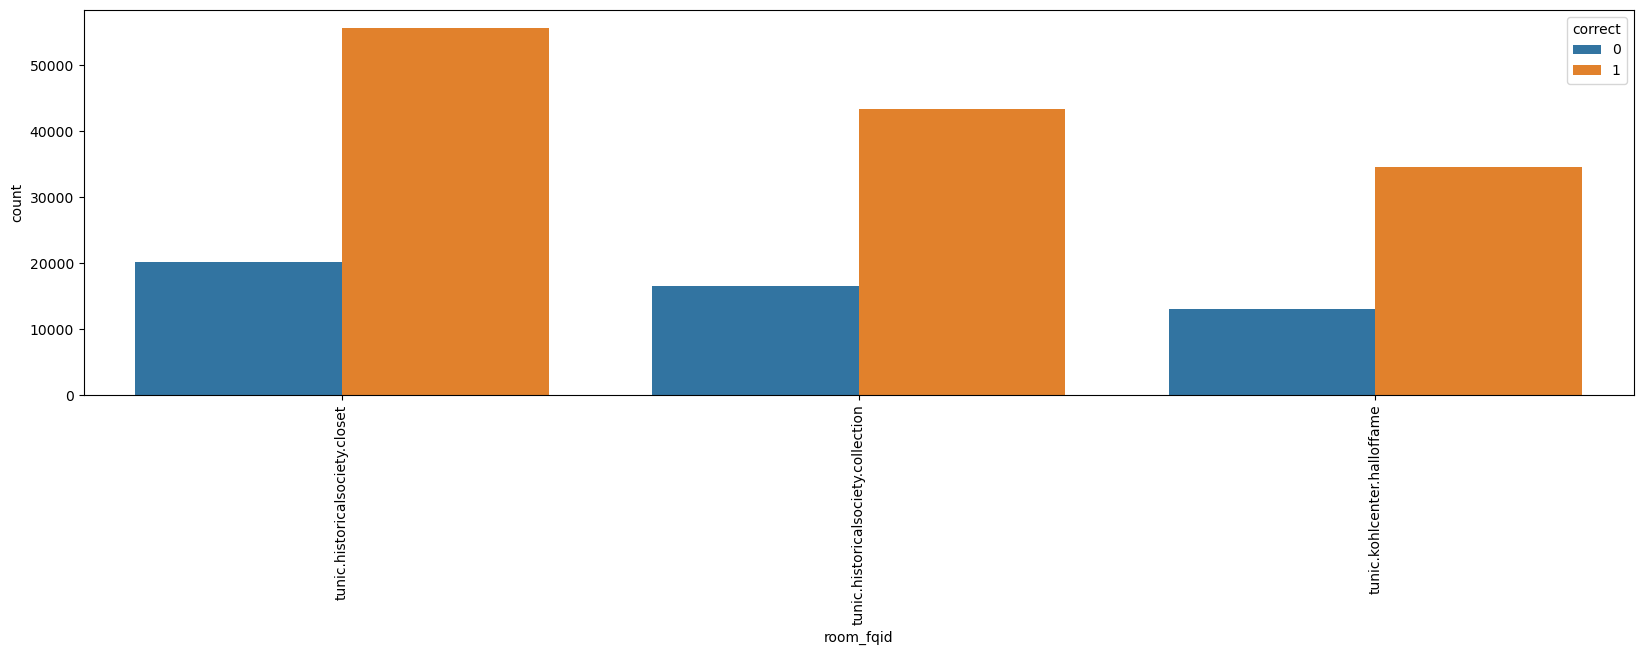

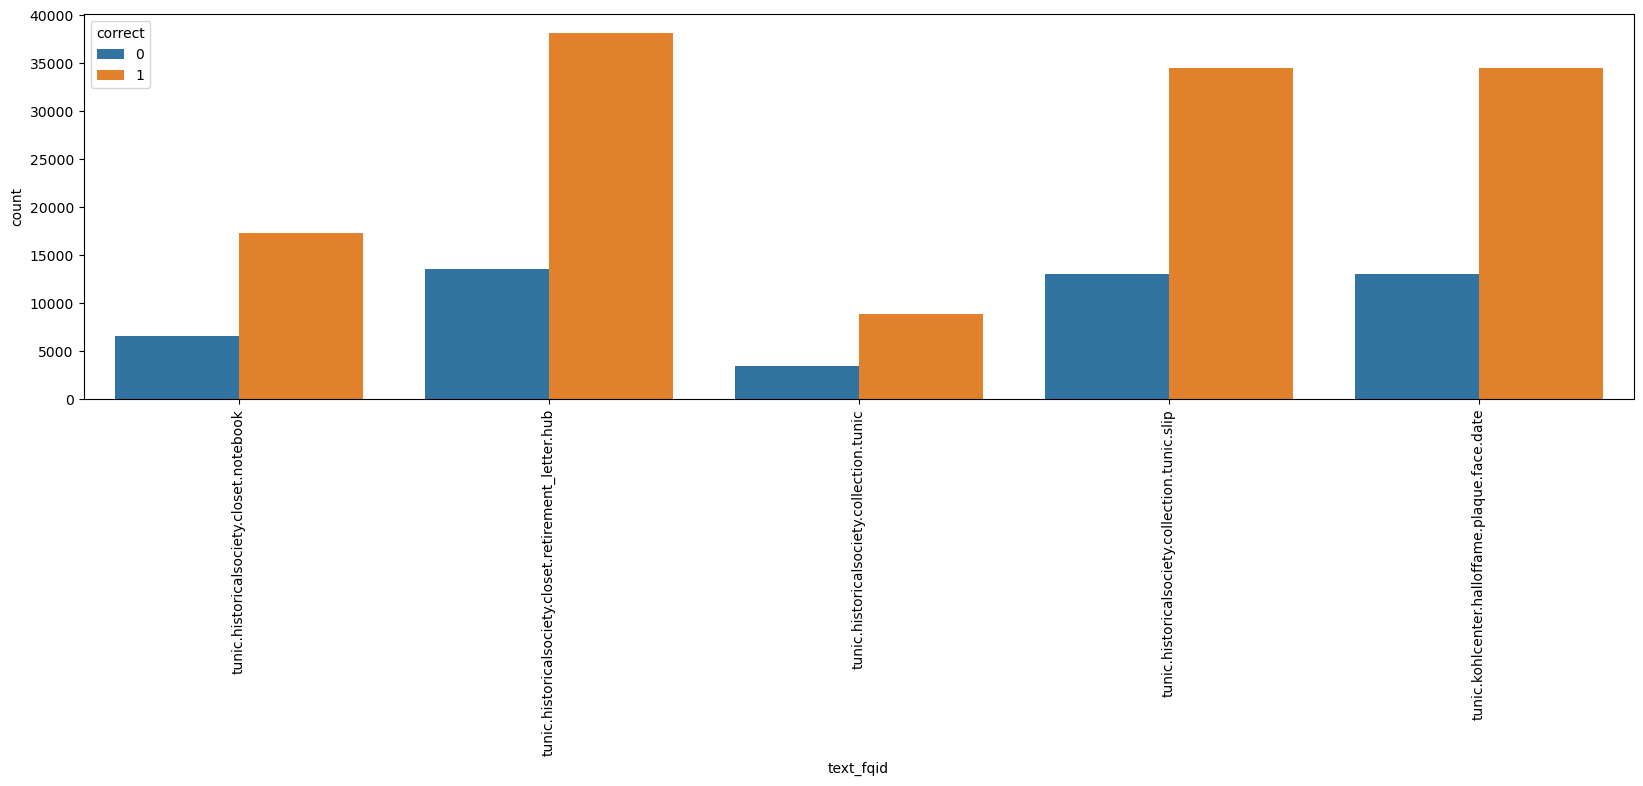

In [74]:
cat_fields_list = ["text", "room_fqid", "text_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__notification_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

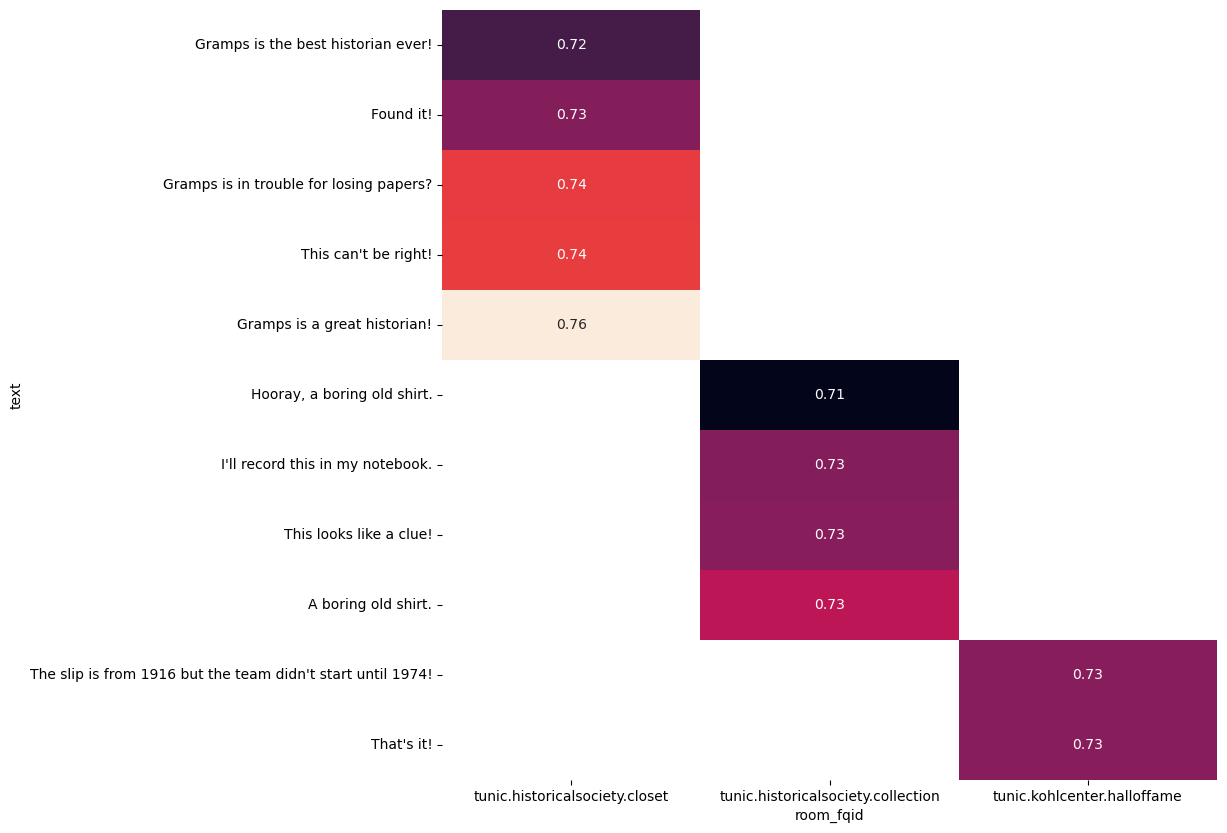

In [75]:
col_pair = ["text", "room_fqid"]
plot_heatmap(get_heatmap_values(df__notification_click, col_pair), figsize=(10, 10))

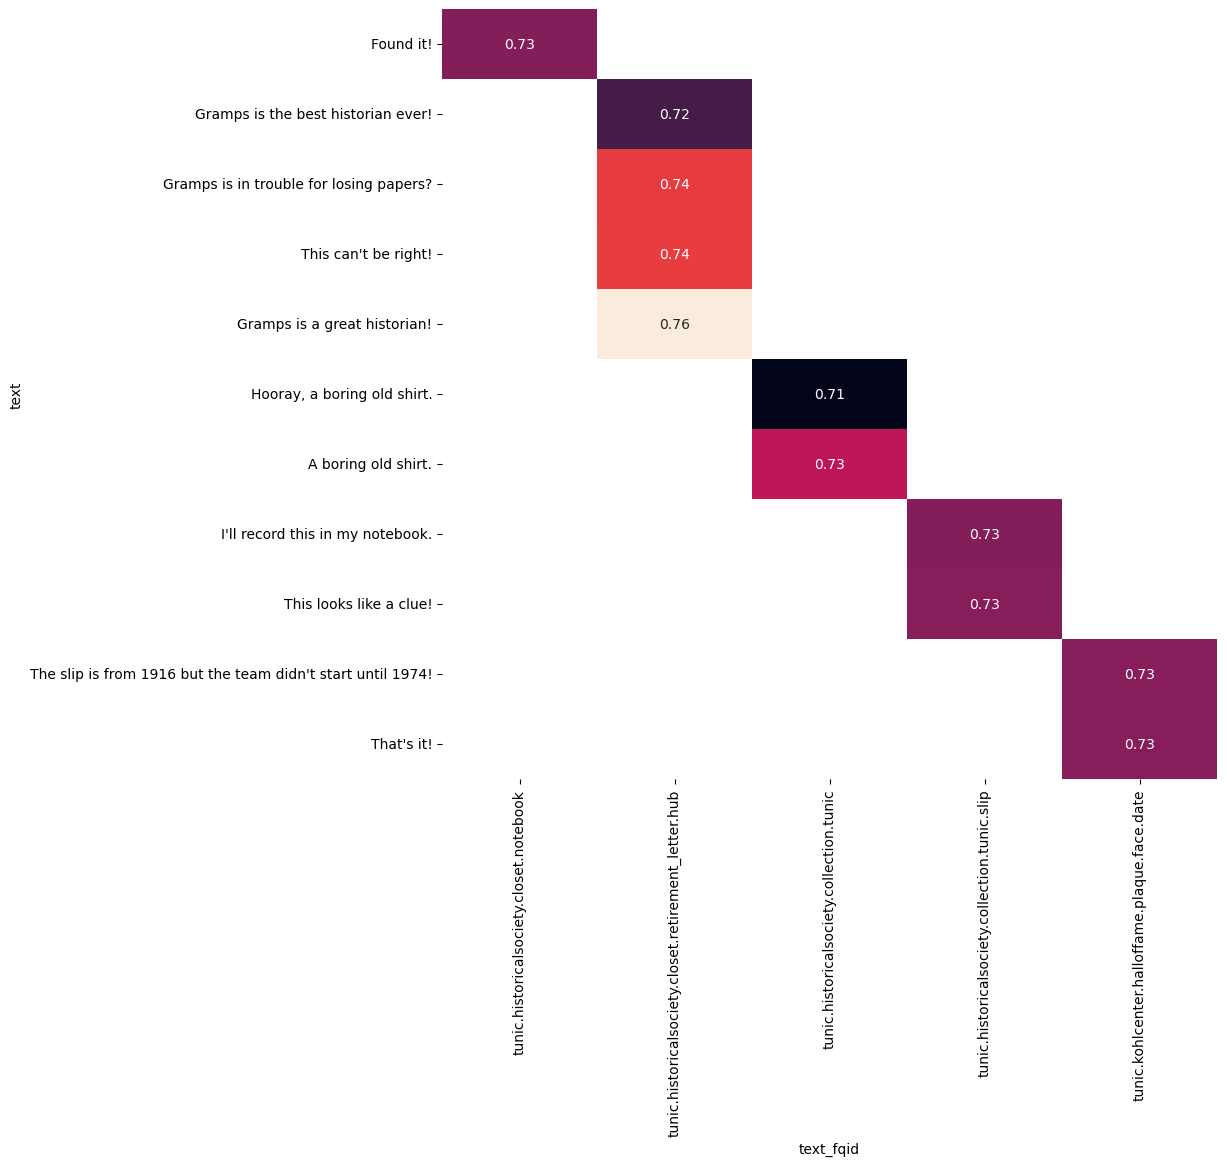

In [76]:
col_pair = ["text", "text_fqid"]
plot_heatmap(get_heatmap_values(df__notification_click, col_pair), figsize=(10, 10))

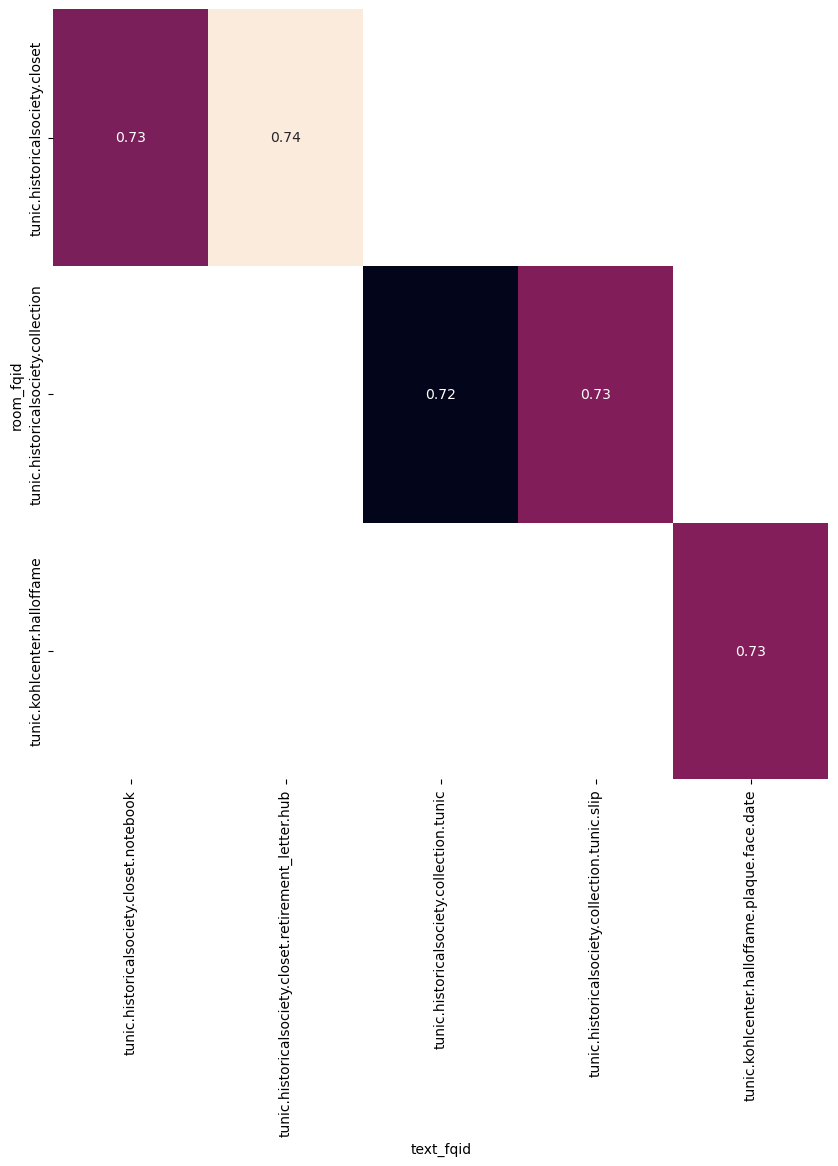

In [77]:
col_pair = ["room_fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__notification_click, col_pair), figsize=(10, 10))

## `event_name` == `"object_click"`

In [78]:
df__object_click = df[df["event_name"] == "object_click"].reset_index(drop=True)
df__object_click.head()

session_id  index  elapsed_time    event_name   name  level  page  \
0  20090312431273200     27         25766  object_click  close    0.0   NaN   
1  20090312431273200     32         36433  object_click  close    1.0   NaN   
2  20090312431273200     50         57277  object_click  basic    1.0   NaN   
3  20090312431273200     51         58244  object_click  close    1.0   NaN   
4  20090312431273200     68         73927  object_click  close    2.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0       -206.5      199.125          822.0           76.0             NaN   
1       -113.5      241.125          836.0           62.0             NaN   
2        856.5       69.750          839.0          291.0             NaN   
3        848.0      402.000          834.0           87.0             NaN   
4        439.0      416.000          833.0           74.0             NaN   

        text               fqid                       room_fqid text_fqid  \
0  undefined           notebook  tunic.historicalsociety.closet       NaN   
1  undefined  retirement_letter  tunic.historicalsociety.closet       NaN   
2  undefined             report   tunic.historicalsociety.entry       NaN   
3  undefined             report   tunic.historicalsociety.entry       NaN   
4  undefined          directory   tunic.historicalsociety.entry       NaN   

  fullscreen hq music  correct  
0          0  0     1        1  
1          0  0     1        1  
2          0  0     1        1  
3          0  0     1        1  
4          0  0     1        1

#### Update Category Fields

In [79]:
df__object_click = recategorize_category_typed_fields(df__object_click)

In [80]:
summary = summarize_data_info(df__object_click)
summary

Data Shape: (364862, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     23562   
index              int16           0.0      2214   
elapsed_time       int32           0.0    232496   
event_name      category           0.0         1   
name            category           0.0         2   
level            float16           0.0         5   
page             float16           1.0         0   
room_coor_x      float16           0.0     11720   
room_coor_y      float16           0.0     10404   
screen_coor_x    float16           0.0      2914   
screen_coor_y    float16           0.0      2640   
hover_duration   float32           1.0         0   
text            category           0.0         1   
fqid            category           0.0         8   
room_fqid       category           0.0         4   
text_fqid       category           0.0         1   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                   first_value  \
session_id                   20090312431273200   
index                                       27   
elapsed_time                             25766   
event_name                        object_click   
name                                     close   
level                                      0.0   
page                                       NaN   
room_coor_x                             -206.5   
room_coor_y                            199.125   
screen_coor_x                            822.0   
screen_coor_y                             76.0   
hover_duration                             NaN   
text                                 undefined   
fqid                                  notebook   
room_fqid       tunic.historicalsociety.closet   
text_fqid                                  nan   
fullscreen                                   0   
hq                                           0   
music                                        1   
correct                                      1   

                                  second_value                    third_value  \
session_id                   20090312431273200              20090312431273200   
index                                       32                             50   
elapsed_time                             36433                          57277   
event_name                        object_click                   object_click   
name                                     close                          basic   
level                                      1.0                            1.0   
page                                       NaN                            NaN   
room_coor_x                             -113.5                          856.5   
room_coor_y                            241.125                          69.75   
screen_coor_x                            836.0                          839.0   
screen_coor_y                             62.0                          291.0   
hover_duration                             NaN                            NaN   
text                                 undefined                      undefined   
fqid                         retirement_letter                         report   
room_fqid       tunic.historicalsociety.closet  tunic.historicalsociety.entry   
text_fqid                                  nan                            nan   
fullscreen                                   0                              0   
hq                                           0                              0   
music                                        1                              1   
correct                                      1                              1   

                                min                  max  
session_id      20090312431273200.0  22100221145014656.0  
index                           0.0               5

#### Insights

- `name` field has two values (basic, close).
- `text` field is constant (undefined).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

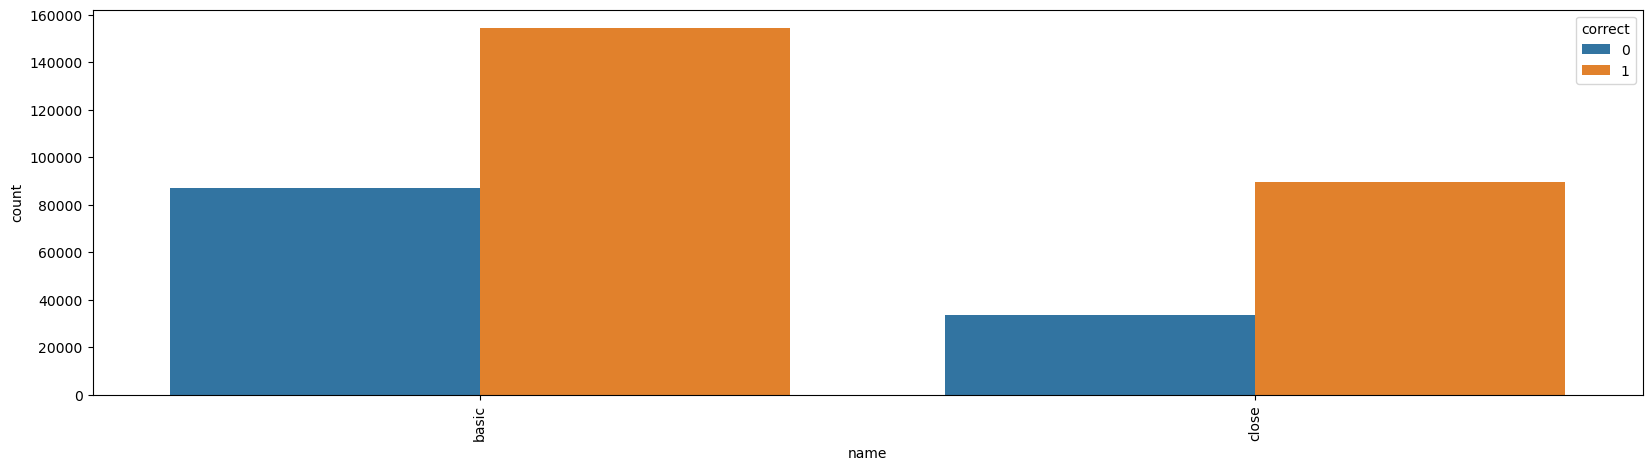

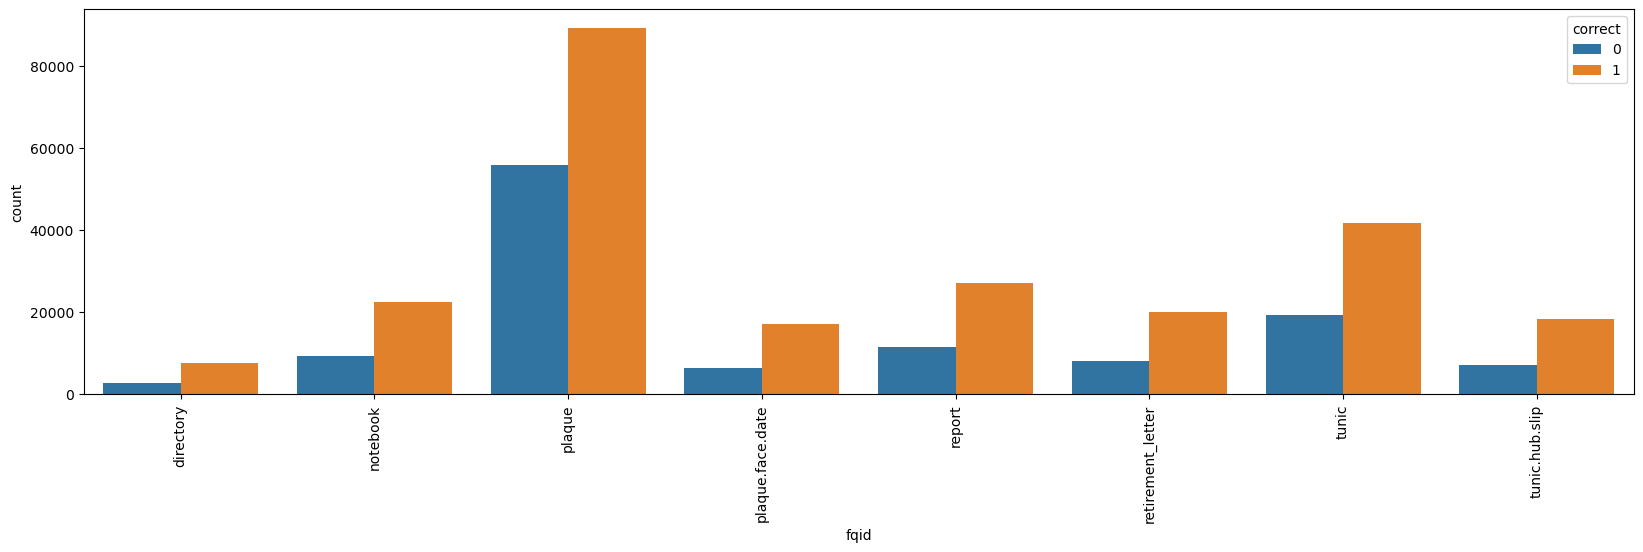

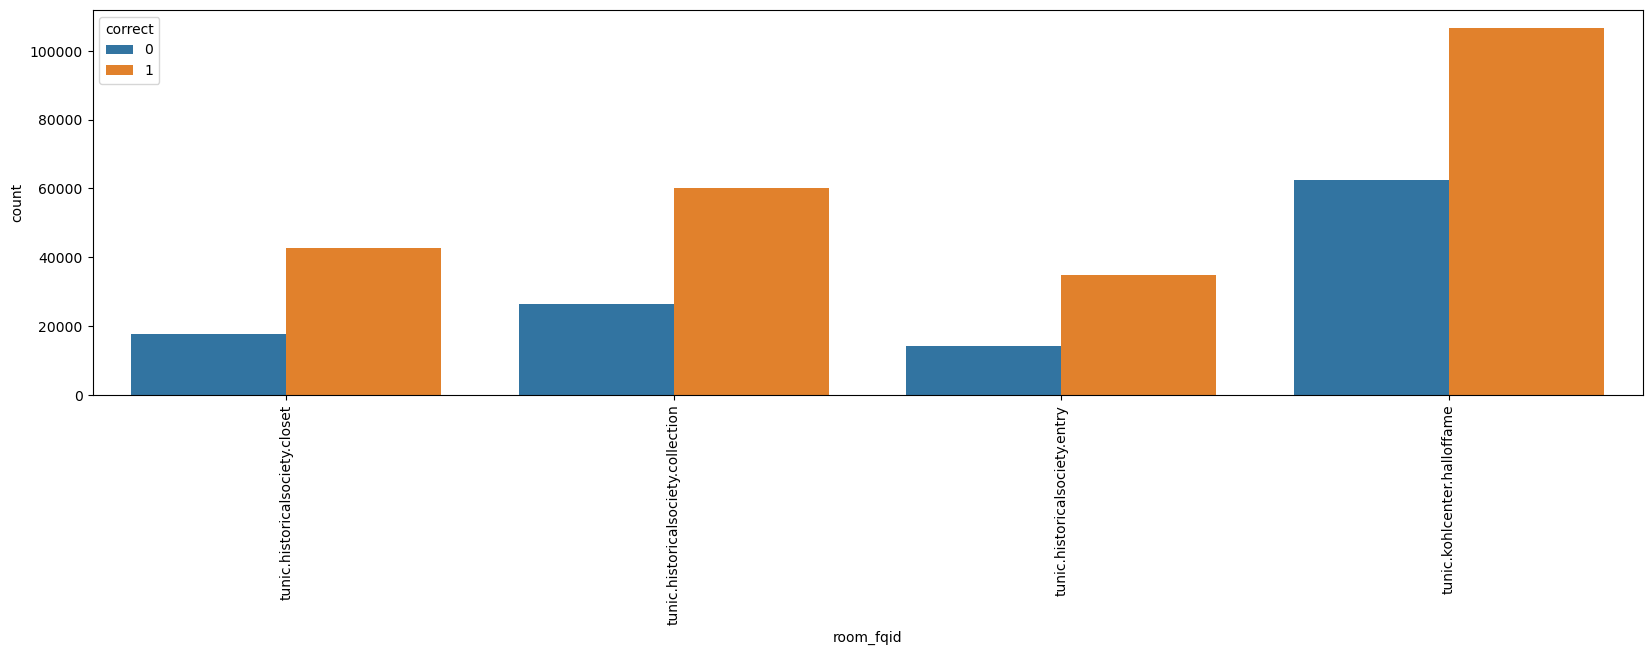

In [81]:
cat_fields_list = ["name", "fqid", "room_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__object_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

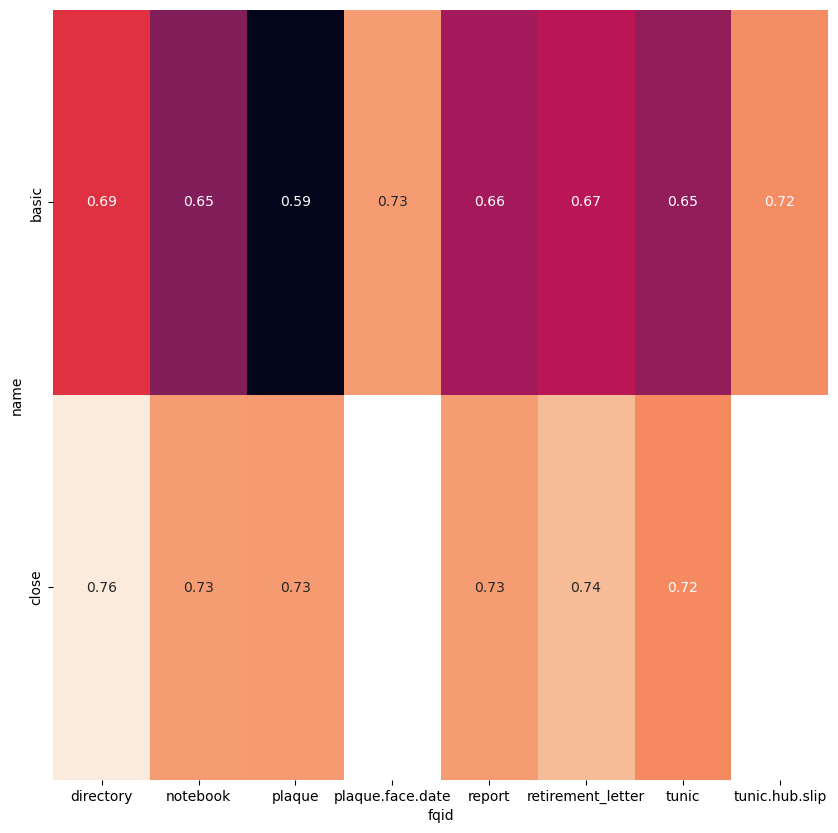

In [82]:
col_pair = ["name", "fqid"]
plot_heatmap(get_heatmap_values(df__object_click, col_pair), figsize=(10, 10))

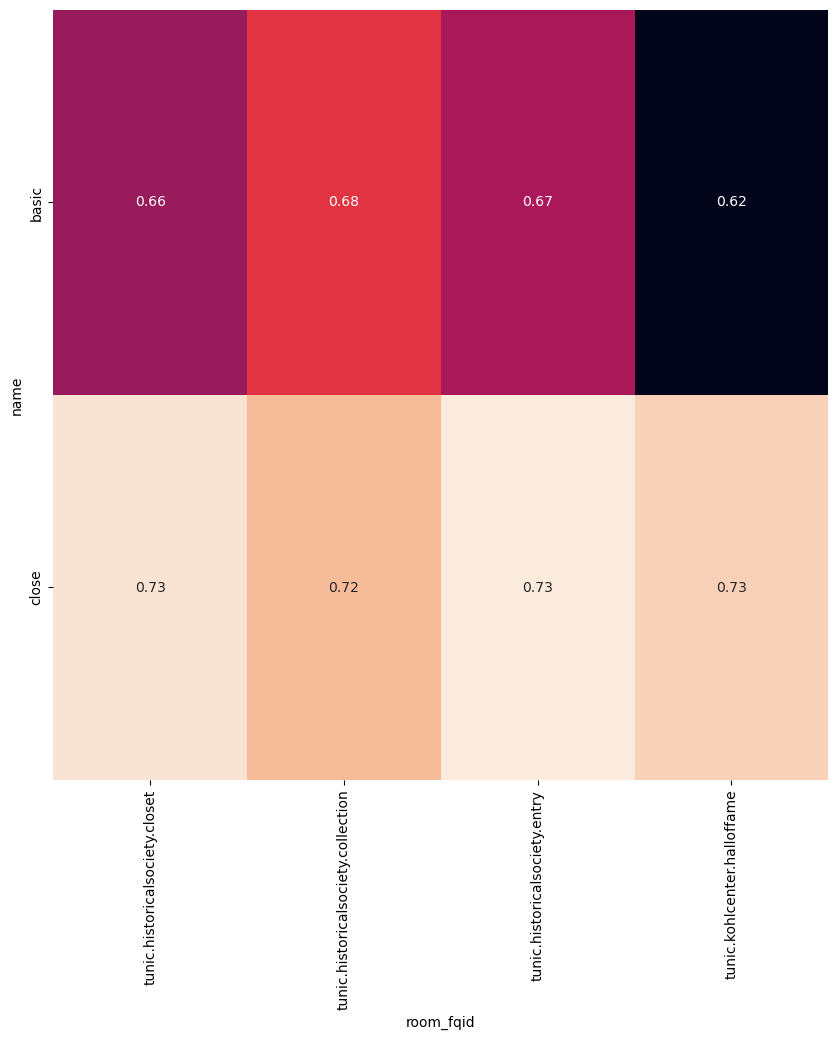

In [83]:
col_pair = ["name", "room_fqid"]
plot_heatmap(get_heatmap_values(df__object_click, col_pair), figsize=(10, 10))

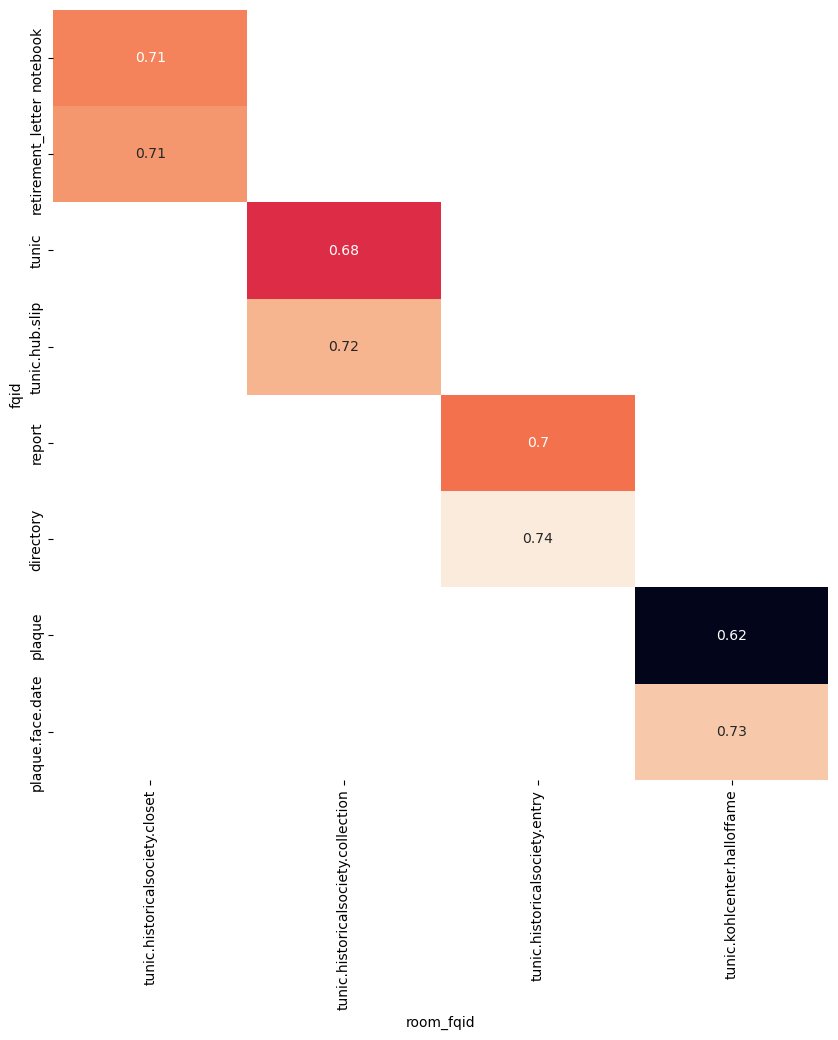

In [84]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__object_click, col_pair), figsize=(10, 10))

## `event_name` == `"object_hover"`

In [85]:
df__object_hover = df[df["event_name"] == "object_hover"].reset_index(drop=True)
df__object_hover.head()

session_id  index  elapsed_time    event_name       name  level  \
0  20090312431273200     49         52328  object_hover      basic    1.0   
1  20090312431273200     82         87242  object_hover      basic    2.0   
2  20090312431273200     87         92242  object_hover  undefined    2.0   
3  20090312431273200    148        153655  object_hover  undefined    3.0   
4  20090312433251036     73        106194  object_hover  undefined    2.0   

   page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0   NaN          NaN          NaN            NaN            NaN   
1   NaN          NaN          NaN            NaN            NaN   
2   NaN          NaN          NaN            NaN            NaN   
3   NaN          NaN          NaN            NaN            NaN   
4   NaN          NaN          NaN            NaN            NaN   

   hover_duration       text              fqid  \
0          7899.0  undefined        groupconvo   
1           400.0  undefined             tunic   
2          3949.0  undefined    tunic.hub.slip   
3          6350.0  undefined  plaque.face.date   
4           701.0  undefined    tunic.hub.slip   

                            room_fqid text_fqid fullscreen hq music  correct  
0       tunic.historicalsociety.entry       NaN          0  0     1        1  
1  tunic.historicalsociety.collection       NaN          0  0     1        1  
2  tunic.historicalsociety.collection       NaN          0  0     1        1  
3         tunic.kohlcenter.halloffame       NaN          0  0     1        1  
4  tunic.historicalsociety.collection       NaN          0  0     0        0

#### Update Category Fields

In [86]:
df__object_hover = recategorize_category_typed_fields(df__object_hover)

In [87]:
summary = summarize_data_info(df__object_hover)
summary

Data Shape: (107127, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     21689   
index              int16           0.0      1464   
elapsed_time       int32           0.0     91471   
event_name      category           0.0         1   
name            category           0.0         2   
level            float16           0.0         5   
page             float16           1.0         0   
room_coor_x      float16           1.0         0   
room_coor_y      float16           1.0         0   
screen_coor_x    float16           1.0         0   
screen_coor_y    float16           1.0         0   
hover_duration   float32           0.0     15454   
text            category           0.0         1   
fqid            category           0.0        17   
room_fqid       category           0.0         4   
text_fqid       category           0.0         1   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                  first_value  \
session_id                  20090312431273200   
index                                      49   
elapsed_time                            52328   
event_name                       object_hover   
name                                    basic   
level                                     1.0   
page                                      NaN   
room_coor_x                               NaN   
room_coor_y                               NaN   
screen_coor_x                             NaN   
screen_coor_y                             NaN   
hover_duration                         7899.0   
text                                undefined   
fqid                               groupconvo   
room_fqid       tunic.historicalsociety.entry   
text_fqid                                 nan   
fullscreen                                  0   
hq                                          0   
music                                       1   
correct                                     1   

                                      second_value  \
session_id                       20090312431273200   
index                                           82   
elapsed_time                                 87242   
event_name                            object_hover   
name                                         basic   
level                                          2.0   
page                                           NaN   
room_coor_x                                    NaN   
room_coor_y                                    NaN   
screen_coor_x                                  NaN   
screen_coor_y                                  NaN   
hover_duration                               400.0   
text                                     undefined   
fqid                                         tunic   
room_fqid       tunic.historicalsociety.collection   
text_fqid                                      nan   
fullscreen                                       0   
hq                                               0   
music                                            1   
correct                                          1   

                                       third_value                  min  \
session_id                       20090312431273200  20090312431273200.0   
index                                           87                  0.0   
elapsed_time                                 92242                543.0   
event_name                            object_hover                  NaN   
name                                     undefined                  NaN   
level                                          2.0                  0.0   
page                                           NaN                  NaN   
room_coor_x                                    NaN                  NaN   
room_coor_y                                    NaN                  NaN   
screen_

#### Insights

- `name` field has two values (basic, undefined).
- `text` field is constant (undefined).
- `text_fqid` field is constant (nan).
- **NULL FIELDS**:
    - `page`
    - `room_coor_x`
    - `room_coor_y`
    - `screen_coor_x`
    - `screen_coor_y`

#### Categorical Fields

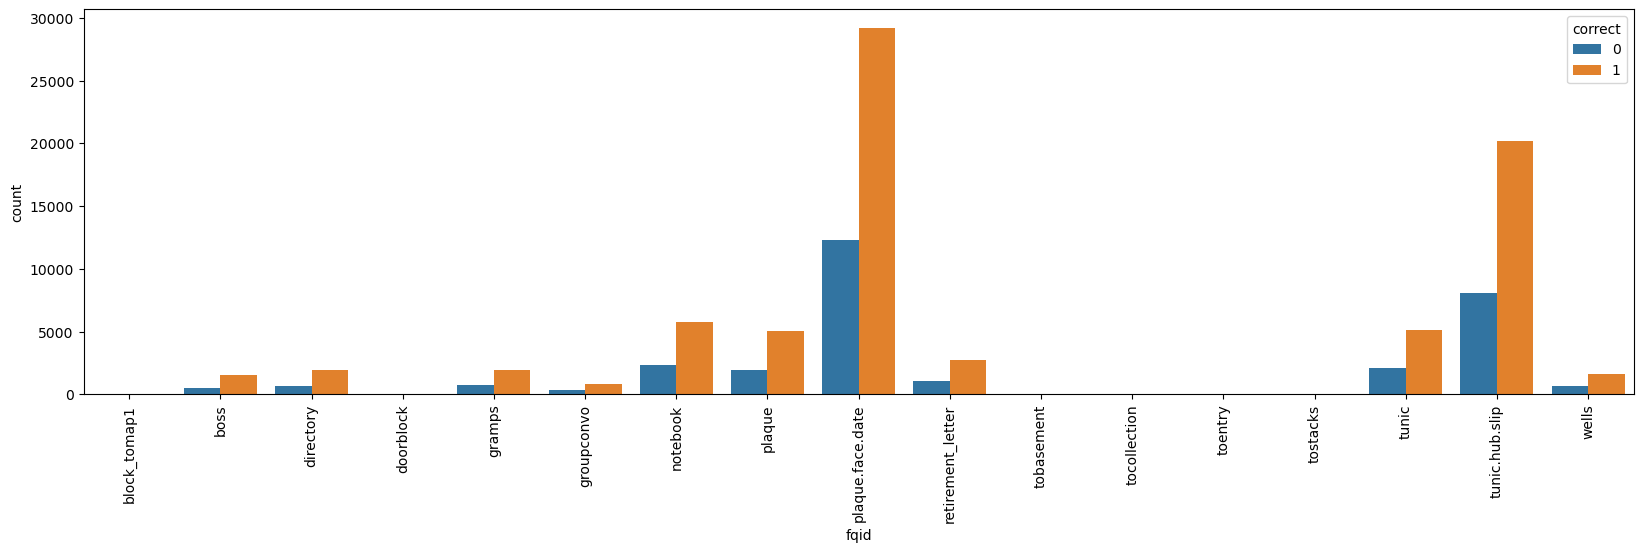

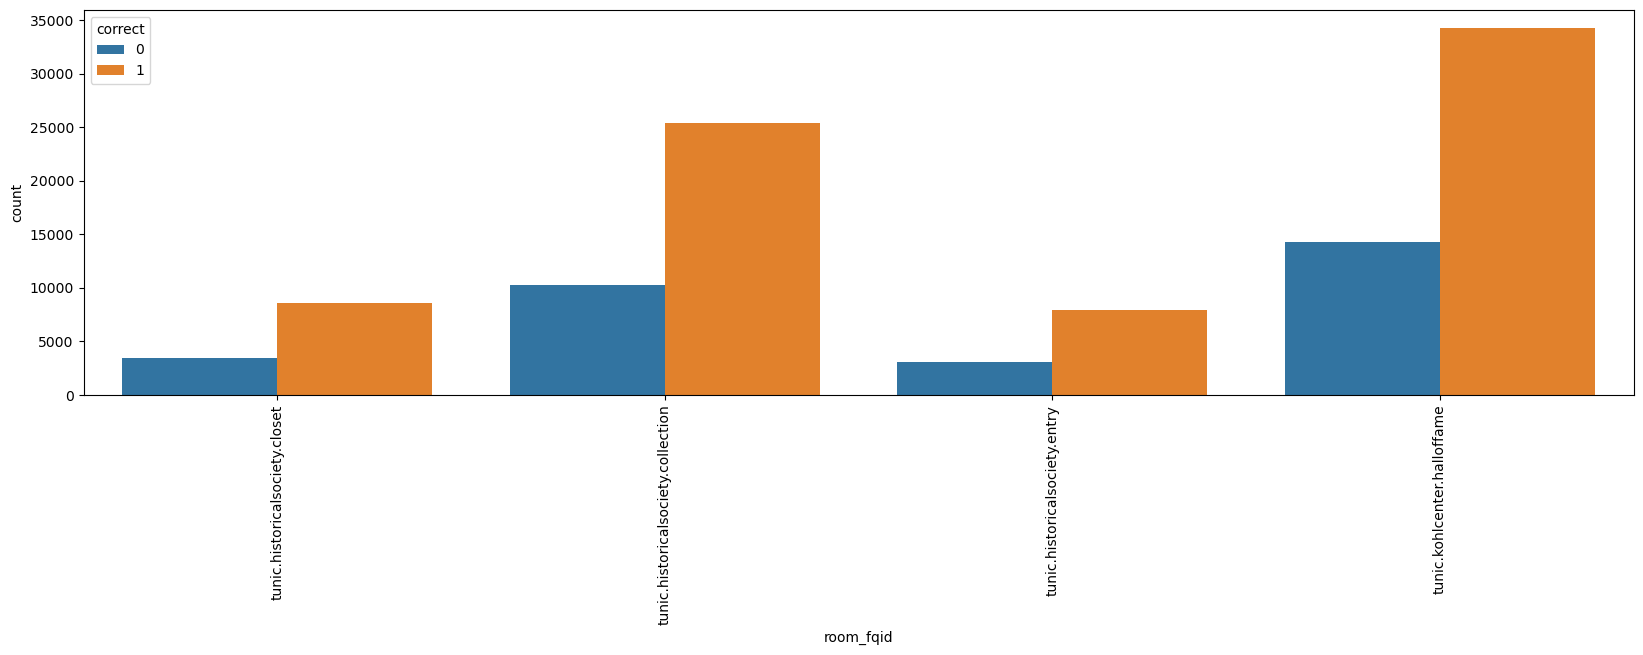

In [88]:
cat_fields_list = ["fqid", "room_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__object_hover, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

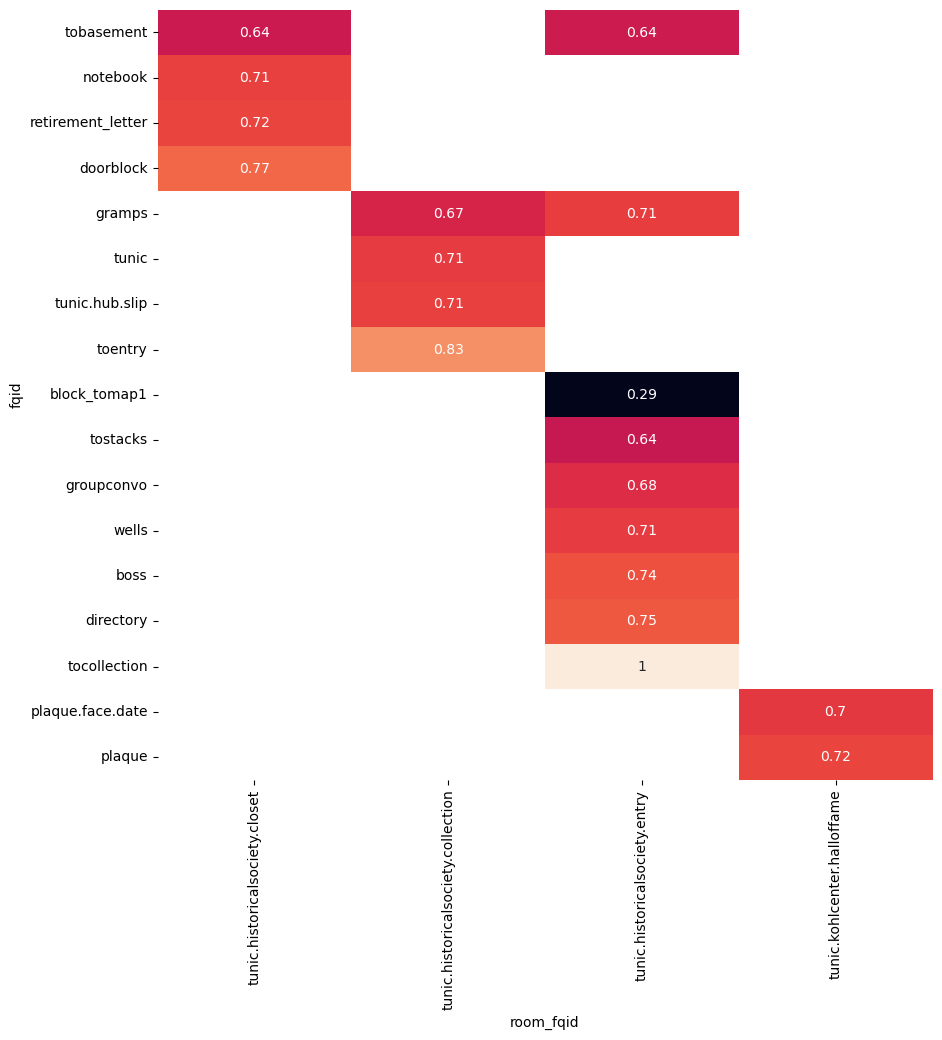

In [89]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__object_hover, col_pair), figsize=(10, 10))

## `event_name` == `"observation_click"`

In [90]:
df__observation_click = df[df["event_name"] == "observation_click"].reset_index(drop=True)
df__observation_click.head()

session_id  index  elapsed_time         event_name   name  level  \
0  20090312431273200     13         13030  observation_click  basic    0.0   
1  20090312431273200     37         41297  observation_click  basic    1.0   
2  20090312431273200    108        109825  observation_click  basic    3.0   
3  20090312431273200    112        117142  observation_click  basic    3.0   
4  20090312433251036     29         36447  observation_click  basic    1.0   

   page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
0   NaN   487.000000   -98.562500          614.0          386.0   
1   NaN  -400.250000  -117.500000          179.0          405.0   
2   NaN    14.359375  -156.250000          444.0          485.0   
3   NaN    -7.492188   -61.718750          480.0          365.0   
4   NaN  -990.000000     2.251953          134.0          327.0   

   hover_duration                                  text                fqid  \
0             NaN  I love these photos of me and Teddy!               photo   
1             NaN      Hmm. Button's still not working.             janitor   
2             NaN              Better check back later.          outtolunch   
3             NaN      Hmm. Button's still not working.             janitor   
4             NaN    I should see what Grampa is up to!  block_tocollection   

                          room_fqid  \
0    tunic.historicalsociety.closet   
1  tunic.historicalsociety.basement   
2    tunic.historicalsociety.stacks   
3  tunic.historicalsociety.basement   
4     tunic.historicalsociety.entry   

                                          text_fqid fullscreen hq music  \
0              tunic.historicalsociety.closet.photo          0  0     1   
1          tunic.historicalsociety.basement.janitor          0  0     1   
2         tunic.historicalsociety.stacks.outtolunch          0  0     1   
3          tunic.historicalsociety.basement.janitor          0  0     1   
4  tunic.historicalsociety.entry.block_tocollection          0  0     0   

   correct  
0        1  
1        1  
2        1  
3        1  
4        0

#### Update Category Fields

In [91]:
df__observation_click = recategorize_category_typed_fields(df__observation_click)

In [92]:
summary = summarize_data_info(df__observation_click)
summary

Data Shape: (40850, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     15847   
index              int16           0.0       996   
elapsed_time       int32           0.0     36606   
event_name      category           0.0         1   
name            category           0.0         1   
level            float16           0.0         4   
page             float16           1.0         0   
room_coor_x      float16           0.0     11288   
room_coor_y      float16           0.0      8410   
screen_coor_x    float16           0.0      1181   
screen_coor_y    float16           0.0       885   
hover_duration   float32           1.0         0   
text            category           0.0         9   
fqid            category           0.0         8   
room_fqid       category           0.0         5   
text_fqid       category           0.0         8   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                         first_value  \
session_id                         20090312431273200   
index                                             13   
elapsed_time                                   13030   
event_name                         observation_click   
name                                           basic   
level                                            0.0   
page                                             NaN   
room_coor_x                                    487.0   
room_coor_y                                 -98.5625   
screen_coor_x                                  614.0   
screen_coor_y                                  386.0   
hover_duration                                   NaN   
text            I love these photos of me and Teddy!   
fqid                                           photo   
room_fqid             tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.photo   
fullscreen                                         0   
hq                                                 0   
music                                              1   
correct                                            1   

                                            second_value  \
session_id                             20090312431273200   
index                                                 37   
elapsed_time                                       41297   
event_name                             observation_click   
name                                               basic   
level                                                1.0   
page                                                 NaN   
room_coor_x                                      -400.25   
room_coor_y                                       -117.5   
screen_coor_x                                      179.0   
screen_coor_y                                      405.0   
hover_duration                                       NaN   
text                    Hmm. Button's still not working.   
fqid                                             janitor   
room_fqid               tunic.historicalsociety.basement   
text_fqid       tunic.historicalsociety.basement.janitor   
fullscreen                                             0   
hq                                                     0   
music                                                  1   
correct                                                1   

                                              third_value  \
session_id                              20090312431273200   
index                                                 108   
elapsed_time                                       109825   
event_name                              observation_click   
name                                                basic   
level                                                 3.0   
page                                                  NaN

#### Insights

- `name` field is constant (basic).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

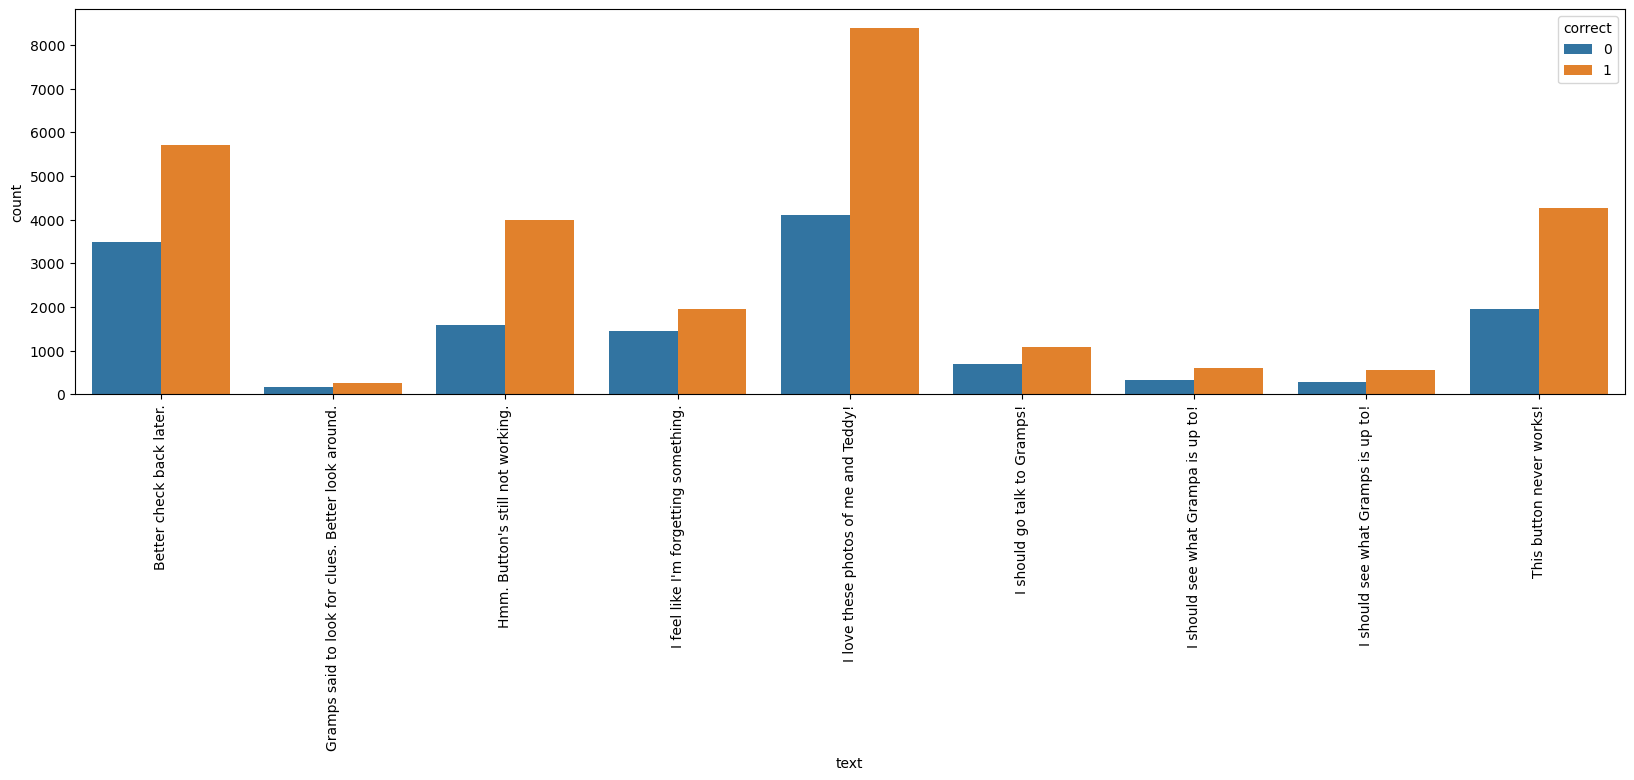

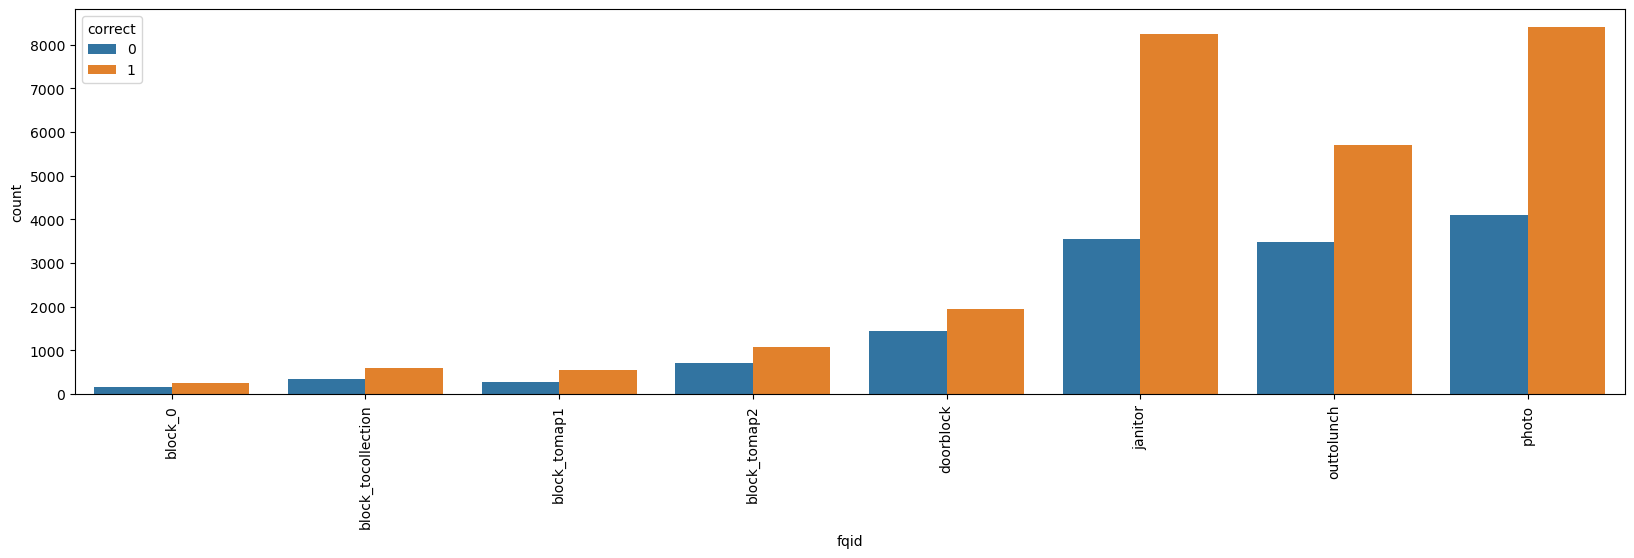

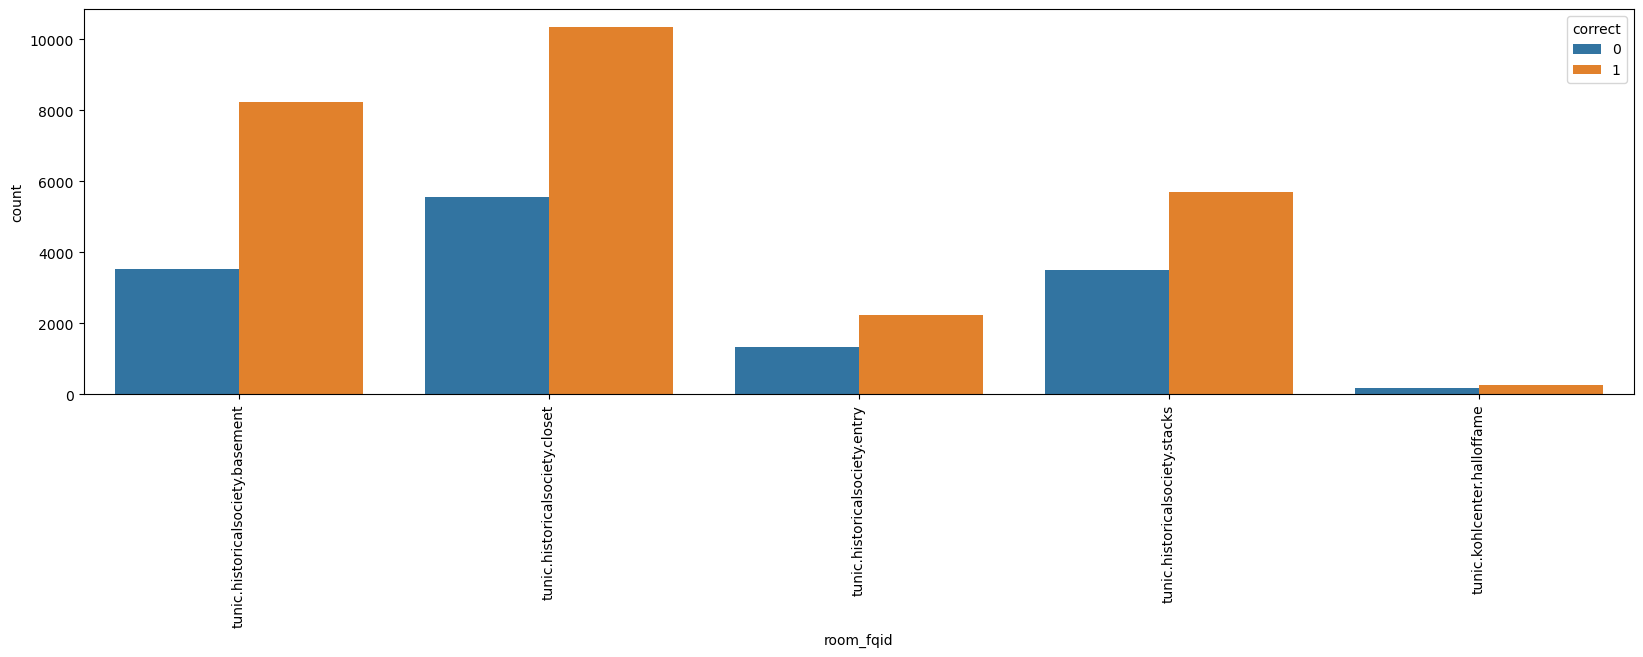

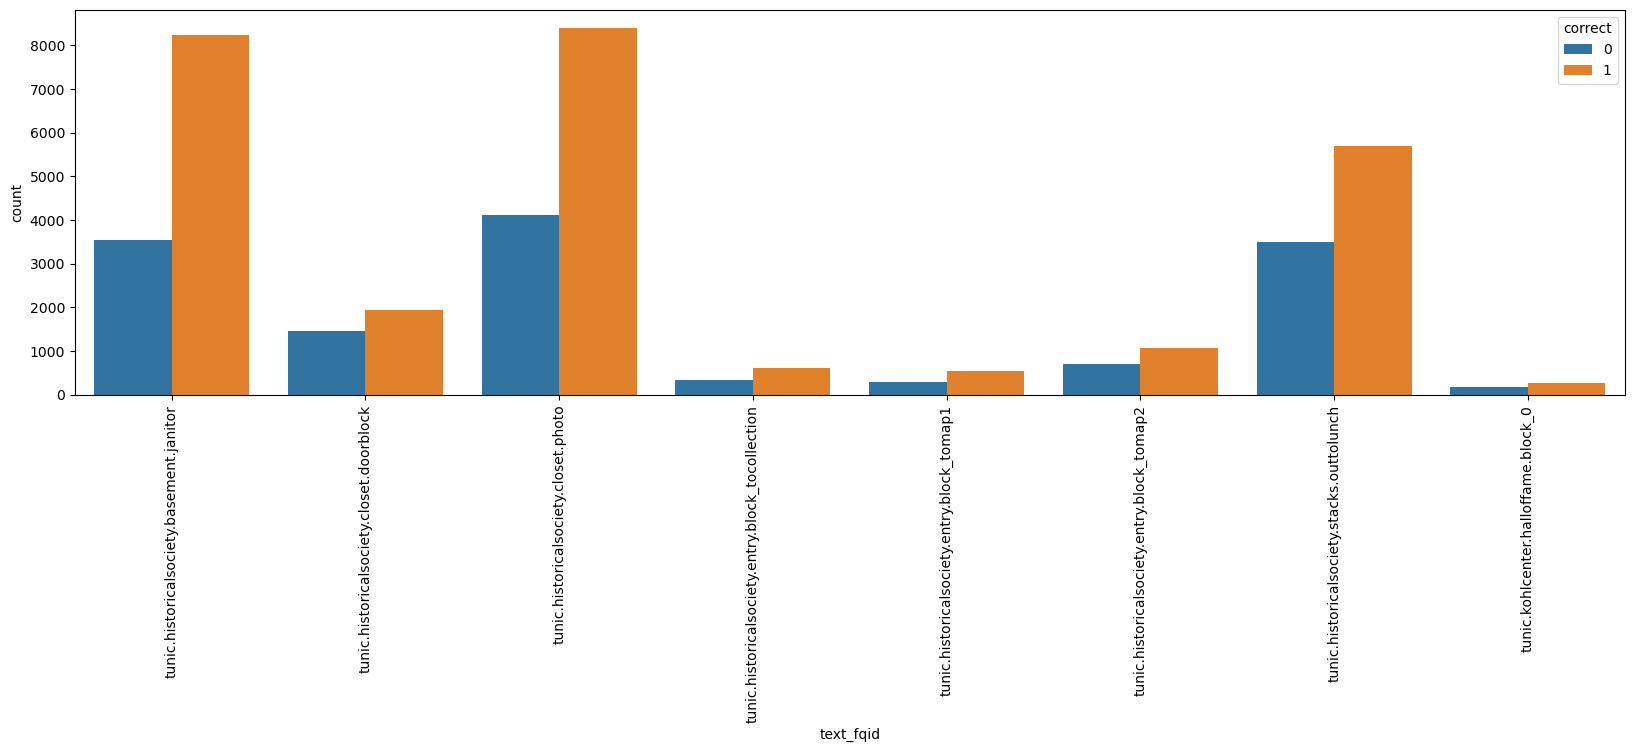

In [93]:
cat_fields_list = ["text", "fqid", "room_fqid", "text_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(data=df__observation_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

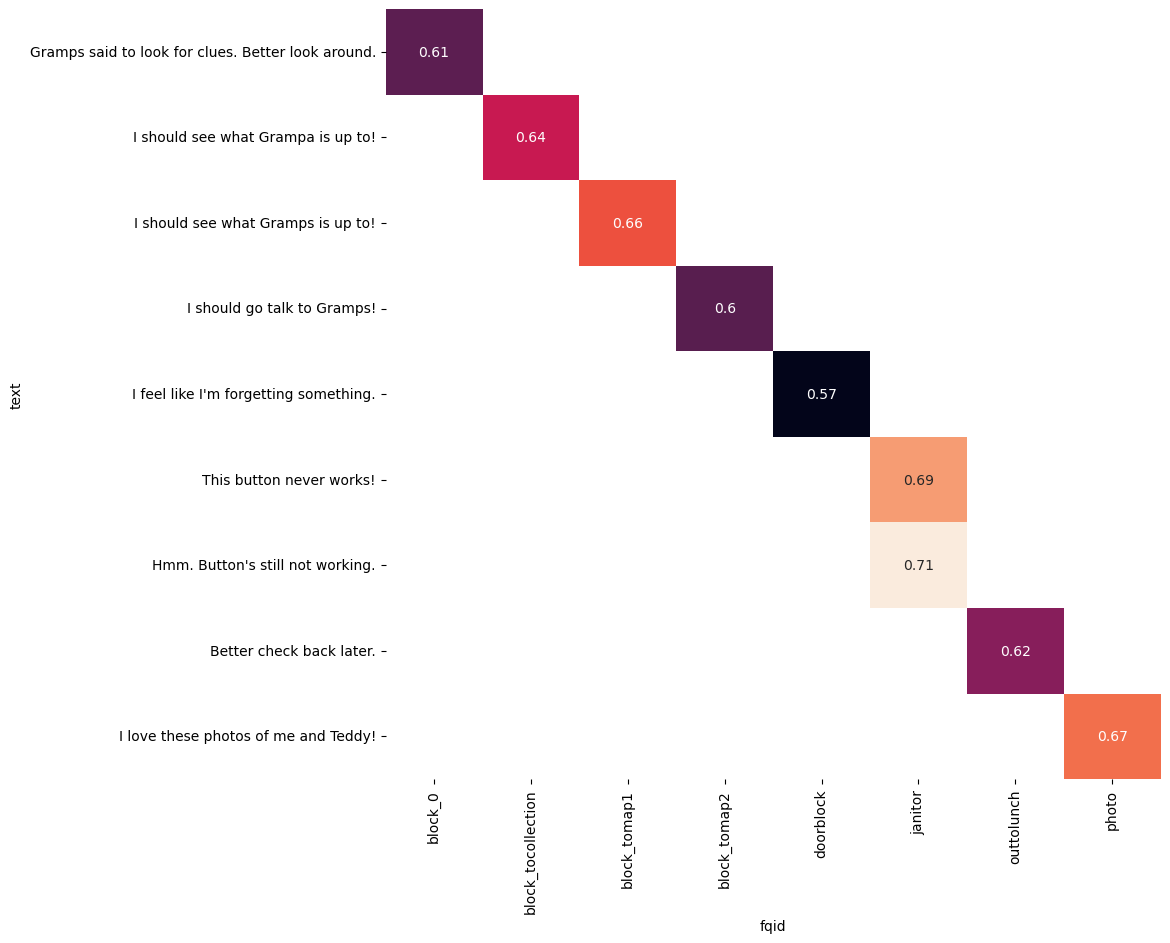

In [94]:
col_pair = ["text", "fqid"]
plot_heatmap(get_heatmap_values(df__observation_click, col_pair), figsize=(10, 10))

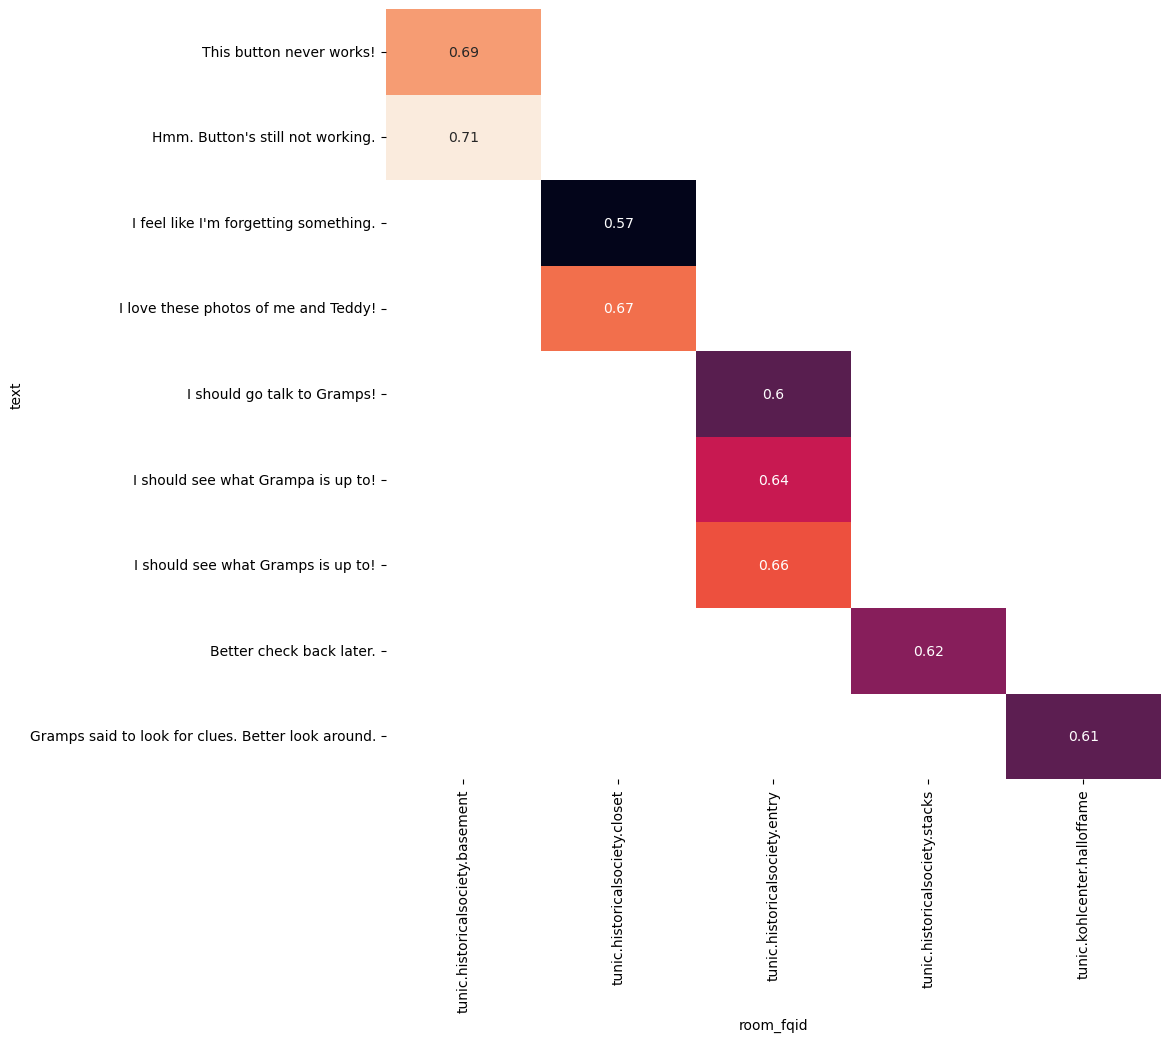

In [95]:
col_pair = ["text", "room_fqid"]
plot_heatmap(get_heatmap_values(df__observation_click, col_pair), figsize=(10, 10))

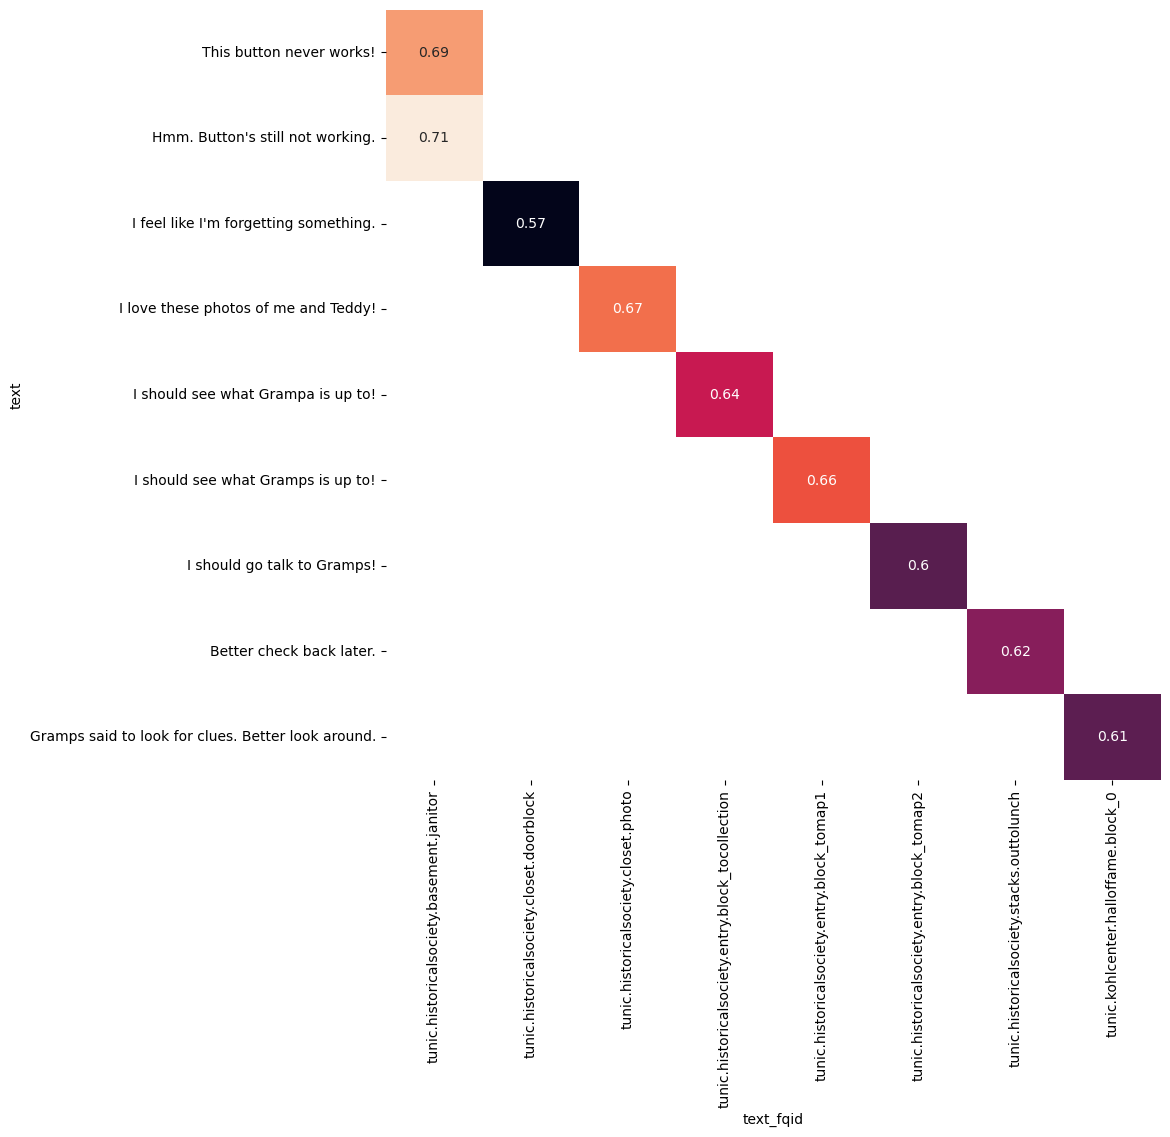

In [96]:
col_pair = ["text", "text_fqid"]
plot_heatmap(get_heatmap_values(df__observation_click, col_pair), figsize=(10, 10))

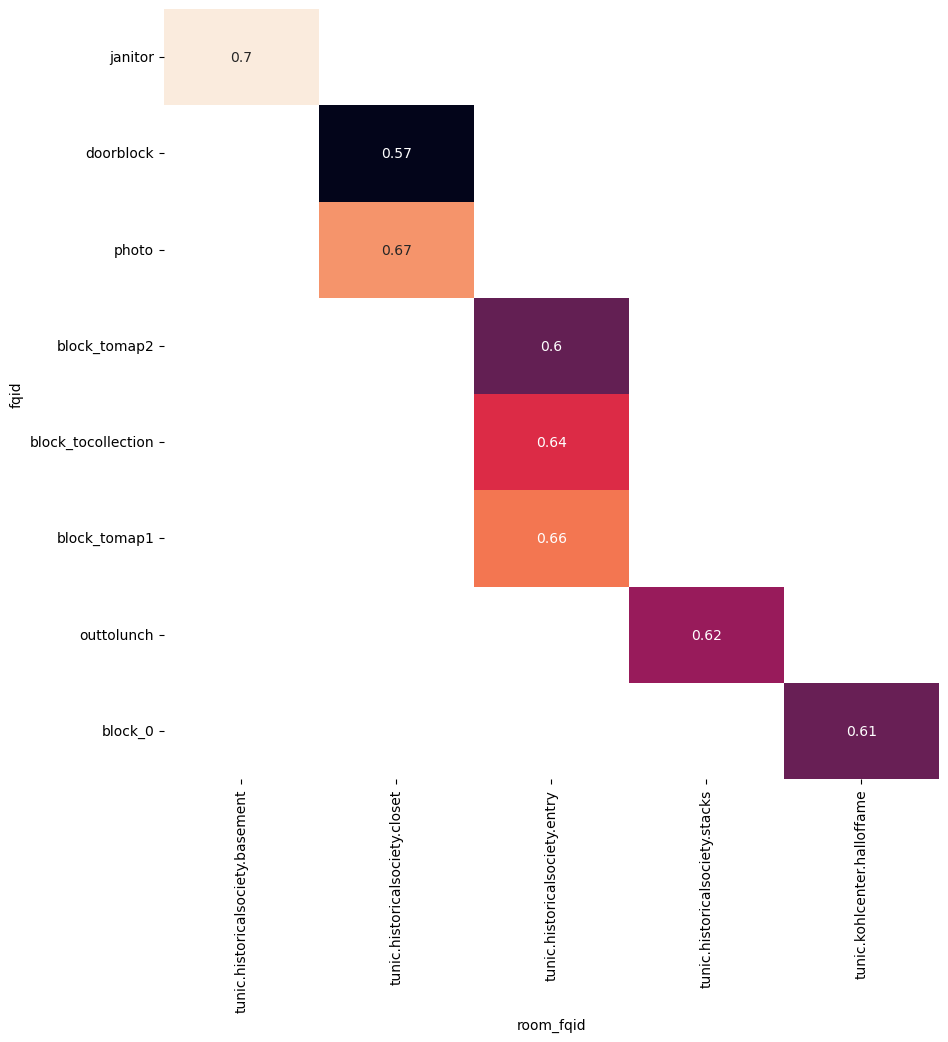

In [97]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__observation_click, col_pair), figsize=(10, 10))

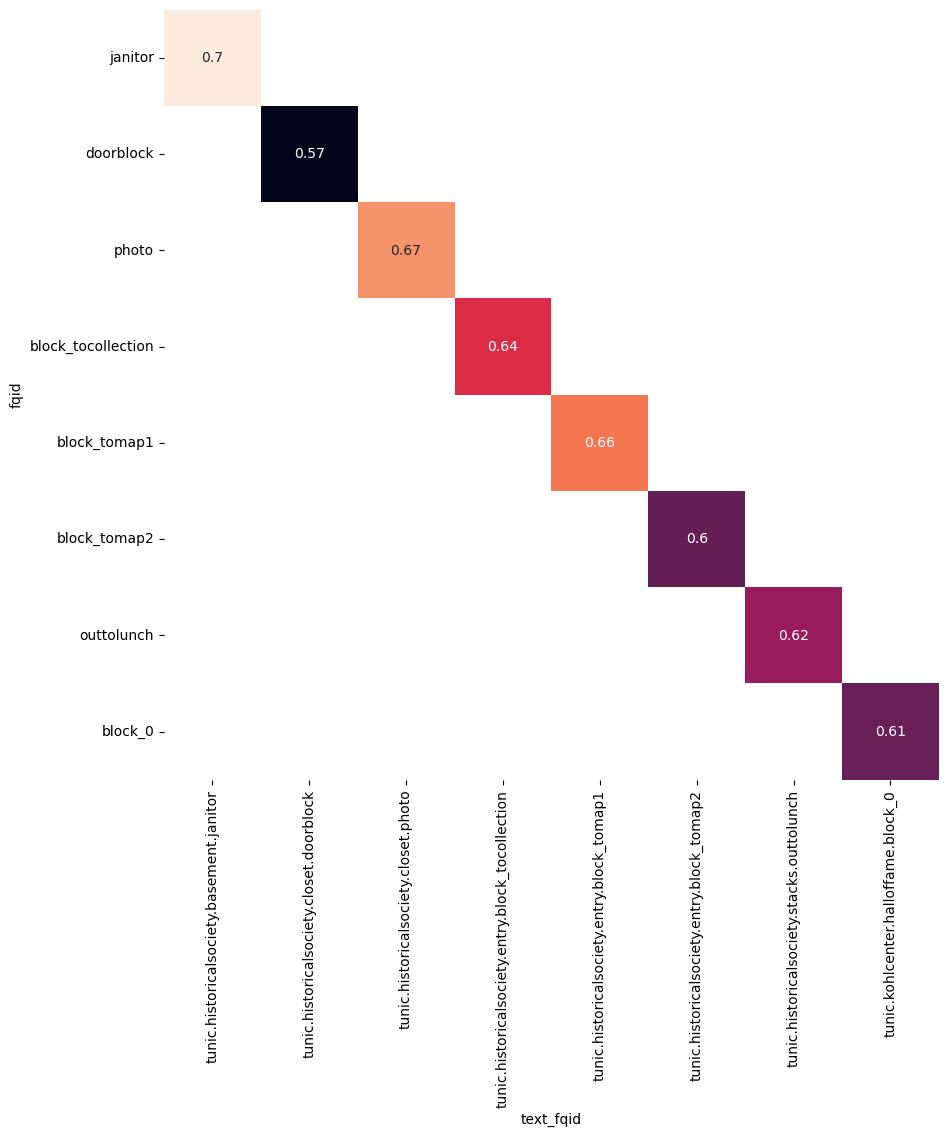

In [98]:
col_pair = ["fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__observation_click, col_pair), figsize=(10, 10))

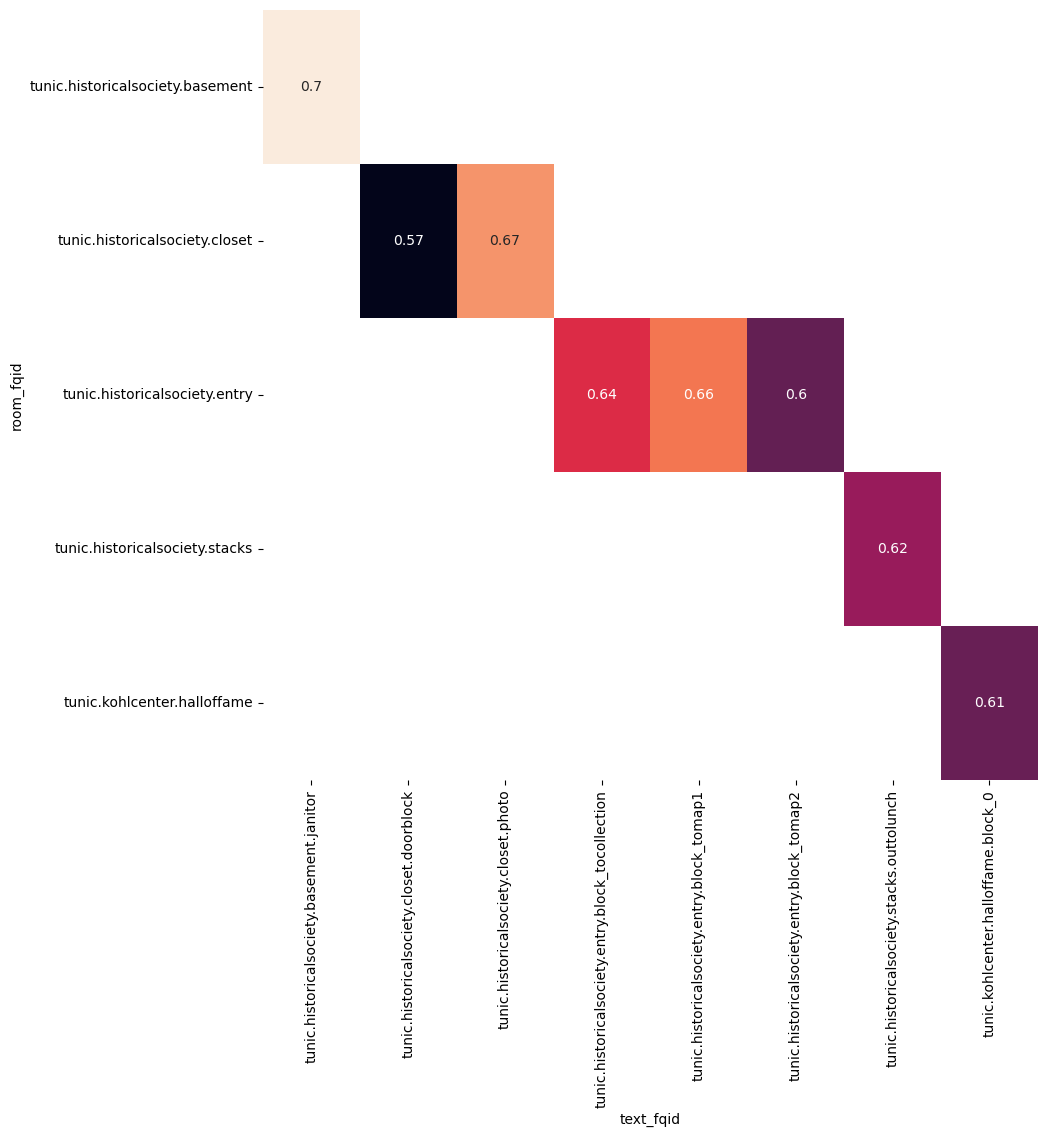

In [99]:
col_pair = ["room_fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__observation_click, col_pair), figsize=(10, 10))

## `event_name` == `"person_click"`

In [100]:
df__person_click = df[df["event_name"] == "person_click"].reset_index(drop=True)
df__person_click.head()

session_id  index  elapsed_time    event_name   name  level  page  \
0  20090312431273200      1          1323  person_click  basic    0.0   NaN   
1  20090312431273200      2           831  person_click  basic    0.0   NaN   
2  20090312431273200      3          1147  person_click  basic    0.0   NaN   
3  20090312431273200      4          1863  person_click  basic    0.0   NaN   
4  20090312431273200      5          3423  person_click  basic    0.0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0       -414.0     -159.375          380.0          494.0             NaN   
1       -414.0     -159.375          380.0          494.0             NaN   
2       -414.0     -159.375          380.0          494.0             NaN   
3       -413.0     -159.375          381.0          494.0             NaN   
4       -413.0     -157.375          381.0          492.0             NaN   

                                                text    fqid  \
0                      Whatcha doing over there, Jo?  gramps   
1                             Just talking to Teddy.  gramps   
2                         I gotta run to my meeting!  gramps   
3                                Can I come, Gramps?  gramps   
4  Sure thing, Jo. Grab your notebook and come up...  gramps   

                        room_fqid  \
0  tunic.historicalsociety.closet   
1  tunic.historicalsociety.closet   
2  tunic.historicalsociety.closet   
3  tunic.historicalsociety.closet   
4  tunic.historicalsociety.closet   

                                           text_fqid fullscreen hq music  \
0  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   
1  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   
2  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   
3  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   
4  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   

   correct  
0        1  
1        1  
2        1  
3        1  
4        1

#### Update Category Fields

In [101]:
df__person_click = recategorize_category_typed_fields(df__person_click)

In [102]:
summary = summarize_data_info(df__person_click)
summary

Data Shape: (484889, 20)


data_type  perc_missing  n_unique  \
session_id         int64           0.0     23562   
index              int16           0.0      2423   
elapsed_time       int32           0.0    195832   
event_name      category           0.0         1   
name            category           0.0         1   
level            float16           0.0         4   
page             float16           1.0         0   
room_coor_x      float16           0.0     15315   
room_coor_y      float16           0.0     13607   
screen_coor_x    float16           0.0      2616   
screen_coor_y    float16           0.0      1928   
hover_duration   float32           1.0         0   
text            category           0.0        36   
fqid            category           0.0         4   
room_fqid       category           0.0         3   
text_fqid       category           0.0         9   
fullscreen      category           0.0         2   
hq              category           0.0         2   
music           category           0.0         2   
correct            int64           0.0         2   

                                                      first_value  \
session_id                                      20090312431273200   
index                                                           1   
elapsed_time                                                 1323   
event_name                                           person_click   
name                                                        basic   
level                                                         0.0   
page                                                          NaN   
room_coor_x                                                -414.0   
room_coor_y                                              -159.375   
screen_coor_x                                               380.0   
screen_coor_y                                               494.0   
hover_duration                                                NaN   
text                                Whatcha doing over there, Jo?   
fqid                                                       gramps   
room_fqid                          tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.gramps.intro_0_...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
correct                                                         1   

                                                     second_value  \
session_id                                      20090312431273200   
index                                                           2   
elapsed_time                                                  831   
event_name                                           person_click   
name                                                        basic   
level                                                         0.0   
page                                                          NaN   
room_coor_x                                                -414.0   
room_coor_y                                              -159.375   
screen_coor_x                                               380.0   
screen_coor_y                                               494.0   
hover_duration                                                NaN   
text                                       Just talking to Teddy.   
fqid                                                       gramps   
room_fqid                          tunic.historicalsociety.closet   
text_fqid       tunic.historicalsociety.closet.gramps.intro_0_...   
fullscreen                                                      0   
hq                                                              0   
music                                                           1   
correct                                                         1   

                      

#### Insights

- `name` field is constant (basic).
- **NULL FIELDS**:
    - `page`
    - `hover_duration`

#### Categorical Fields

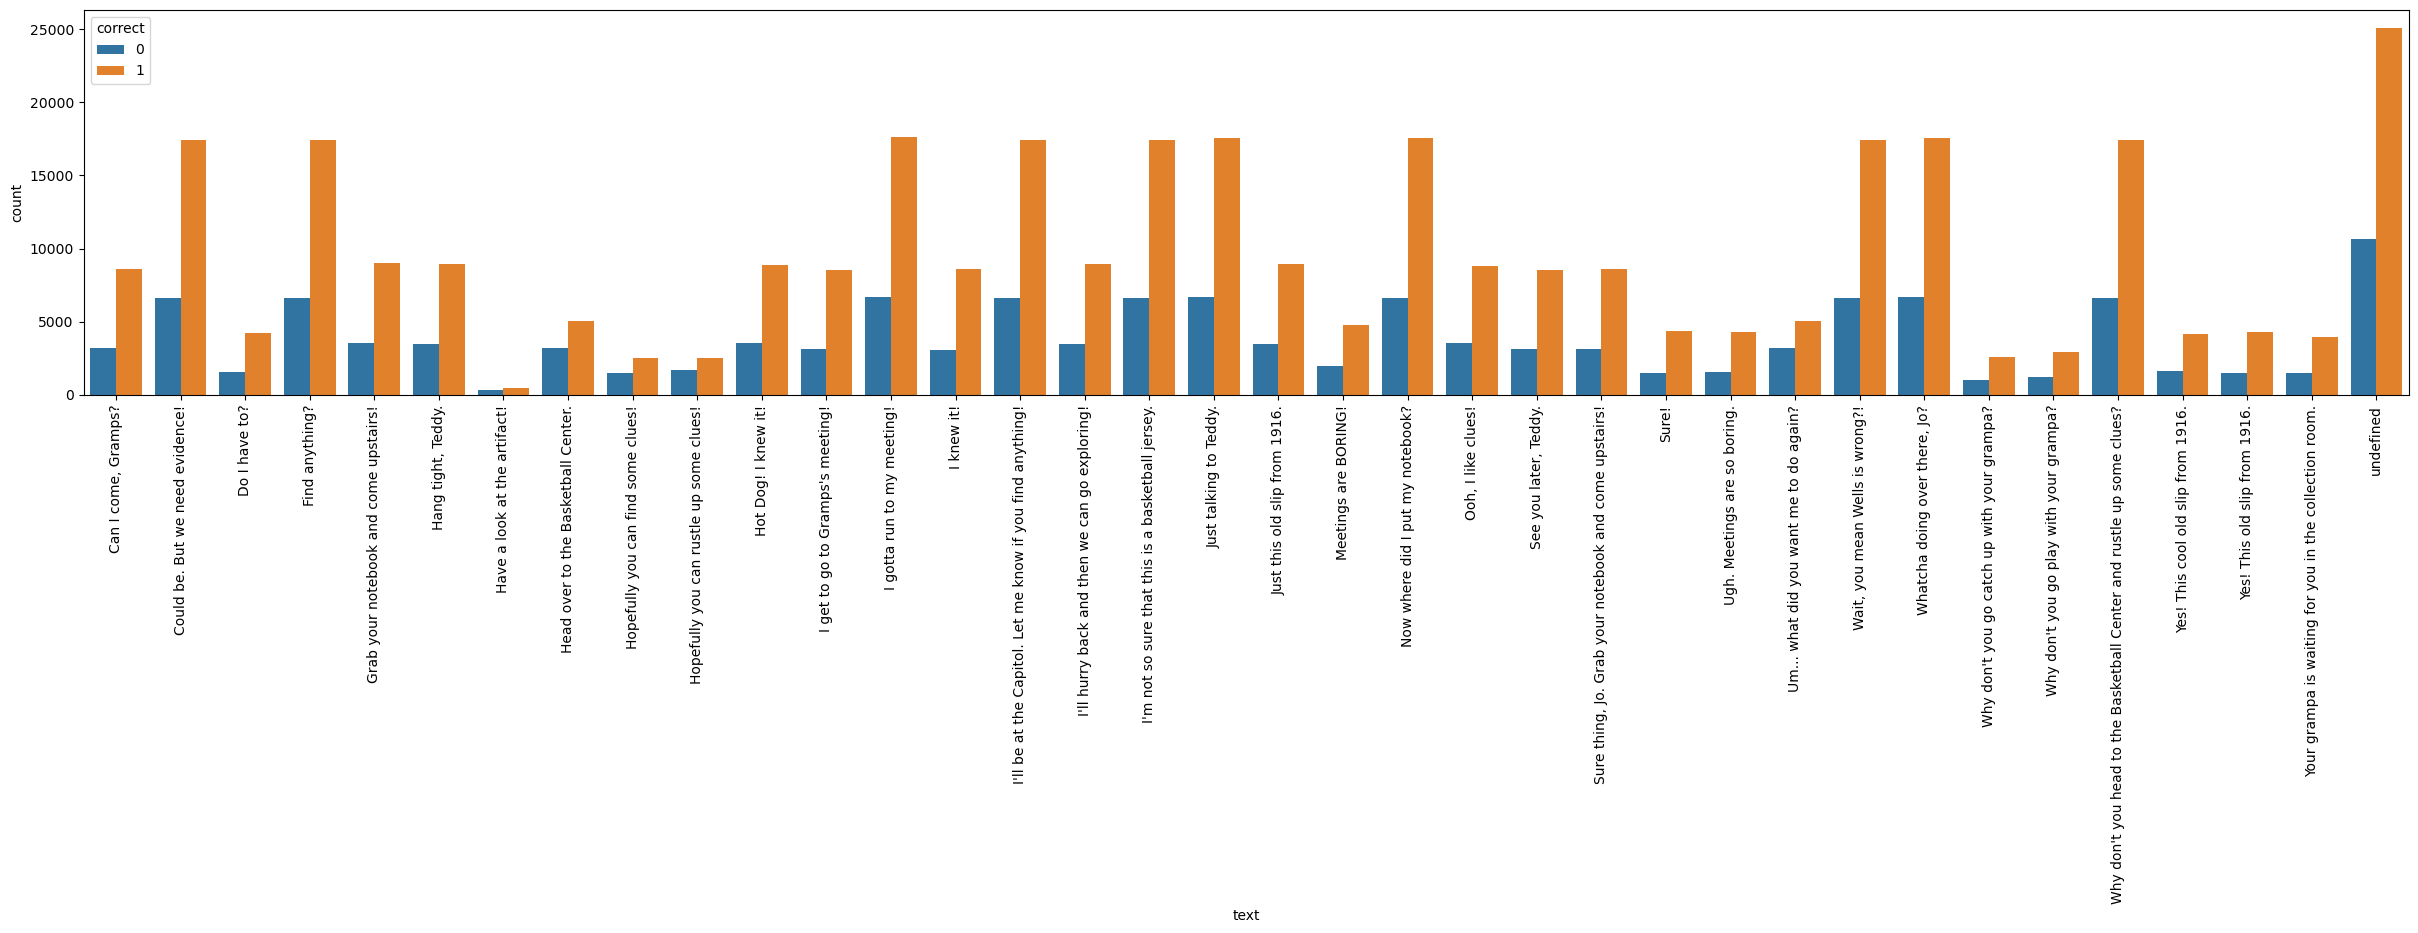

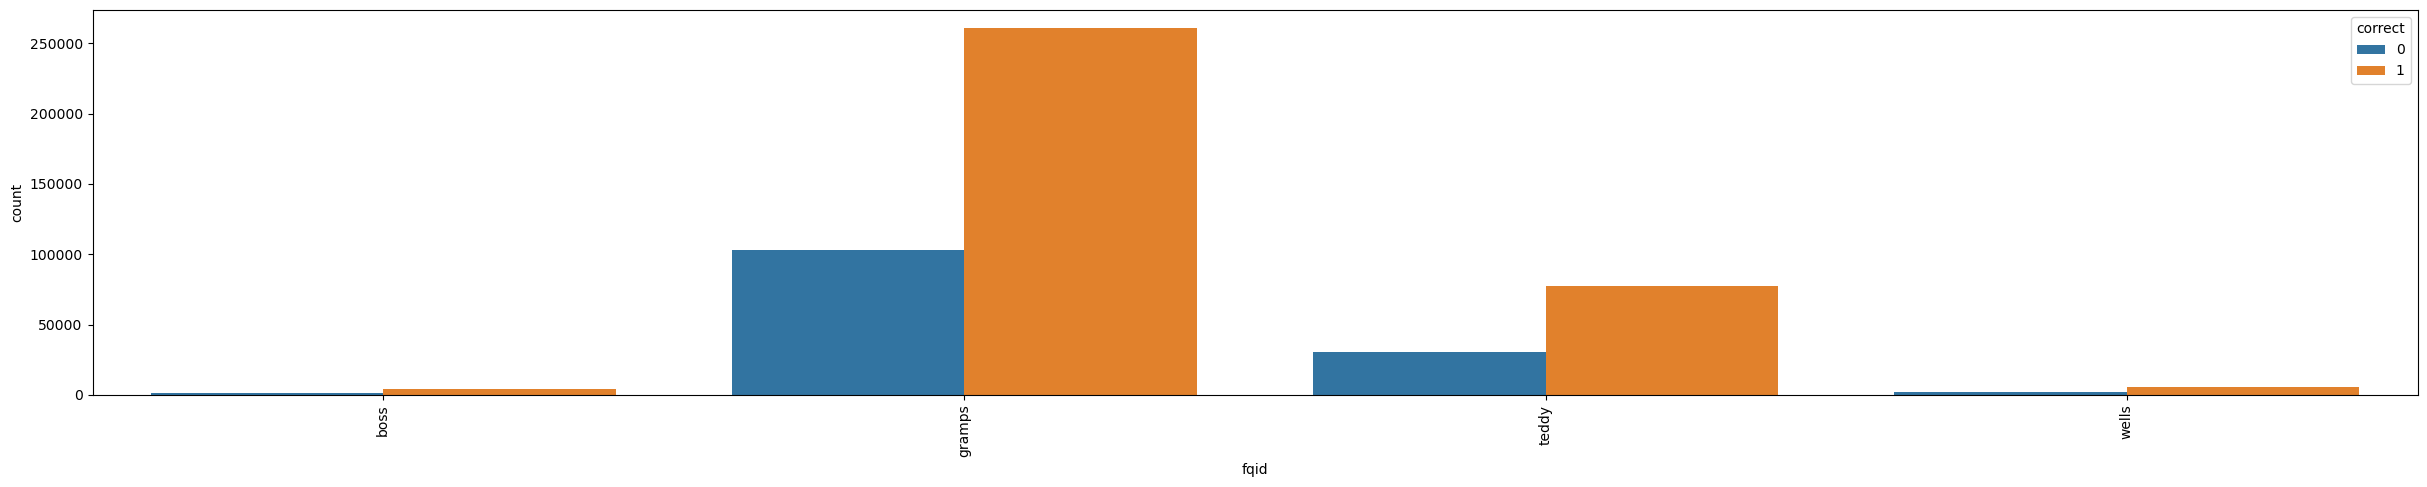

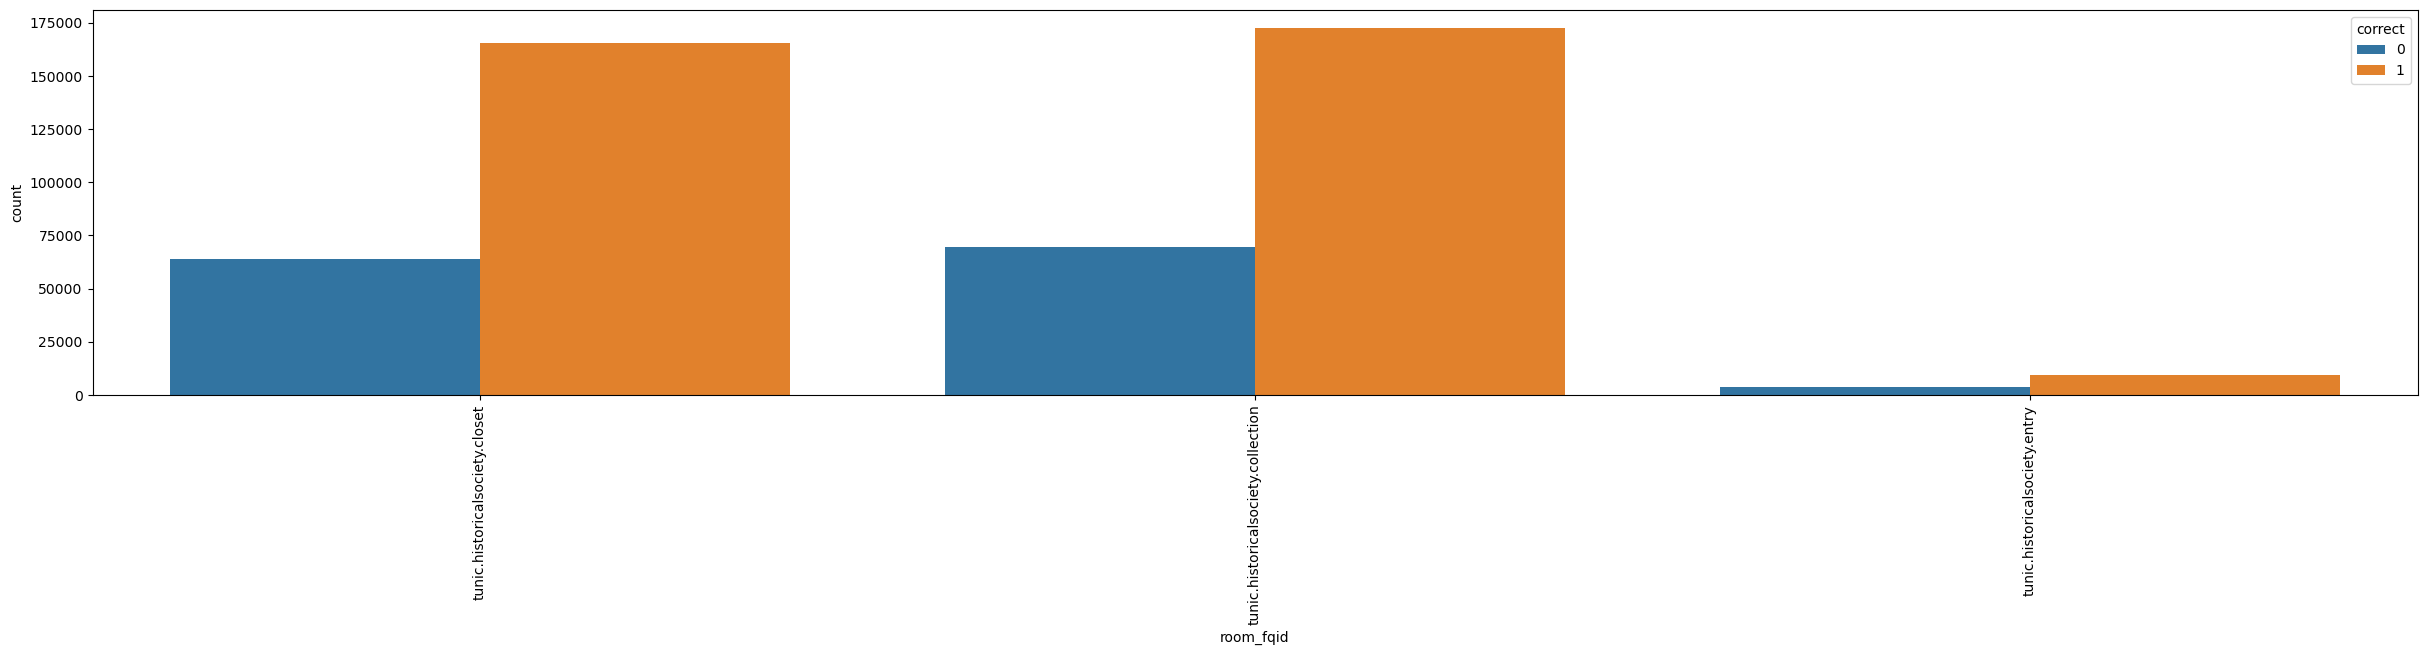

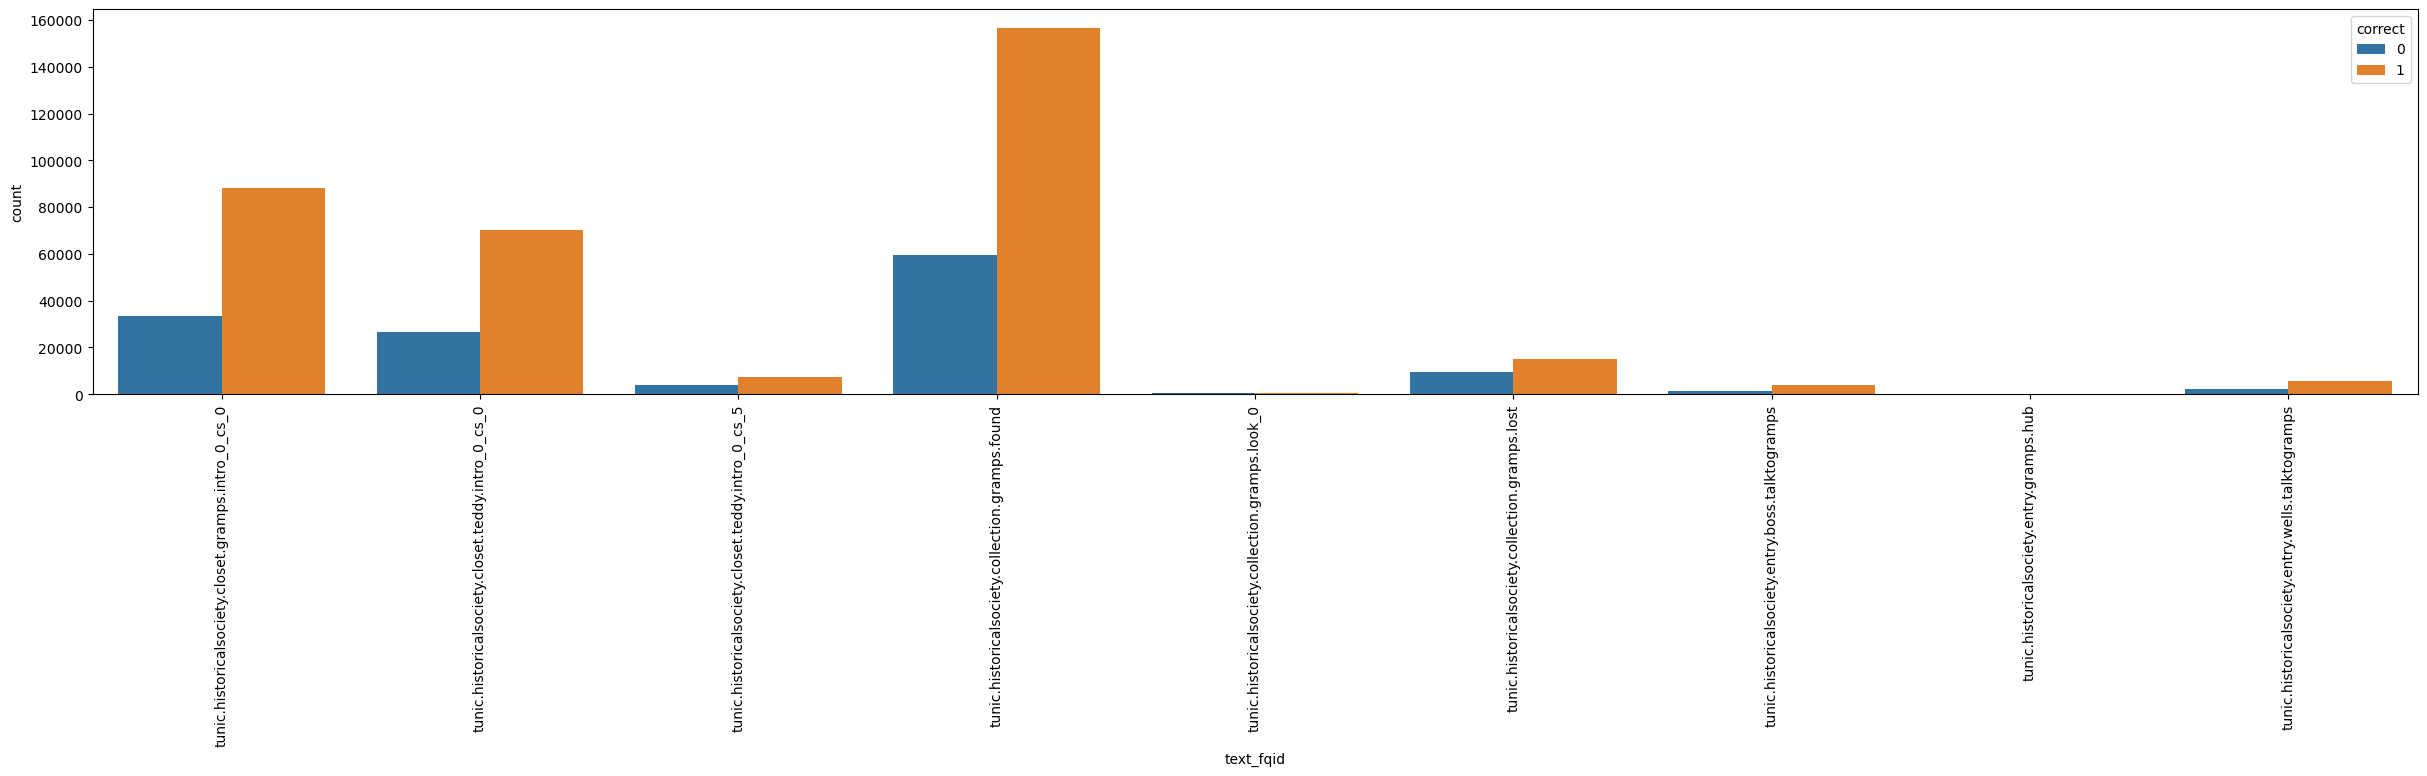

In [103]:
cat_fields_list = ["text", "fqid", "room_fqid", "text_fqid"]

for col_name in cat_fields_list:
    fig, ax = plt.subplots(figsize=(30, 5))
    sns.countplot(data=df__person_click, x=col_name, hue="correct", ax=ax)
    
    plt.xticks(rotation=90)
    plt.show()

#### Category Pairs

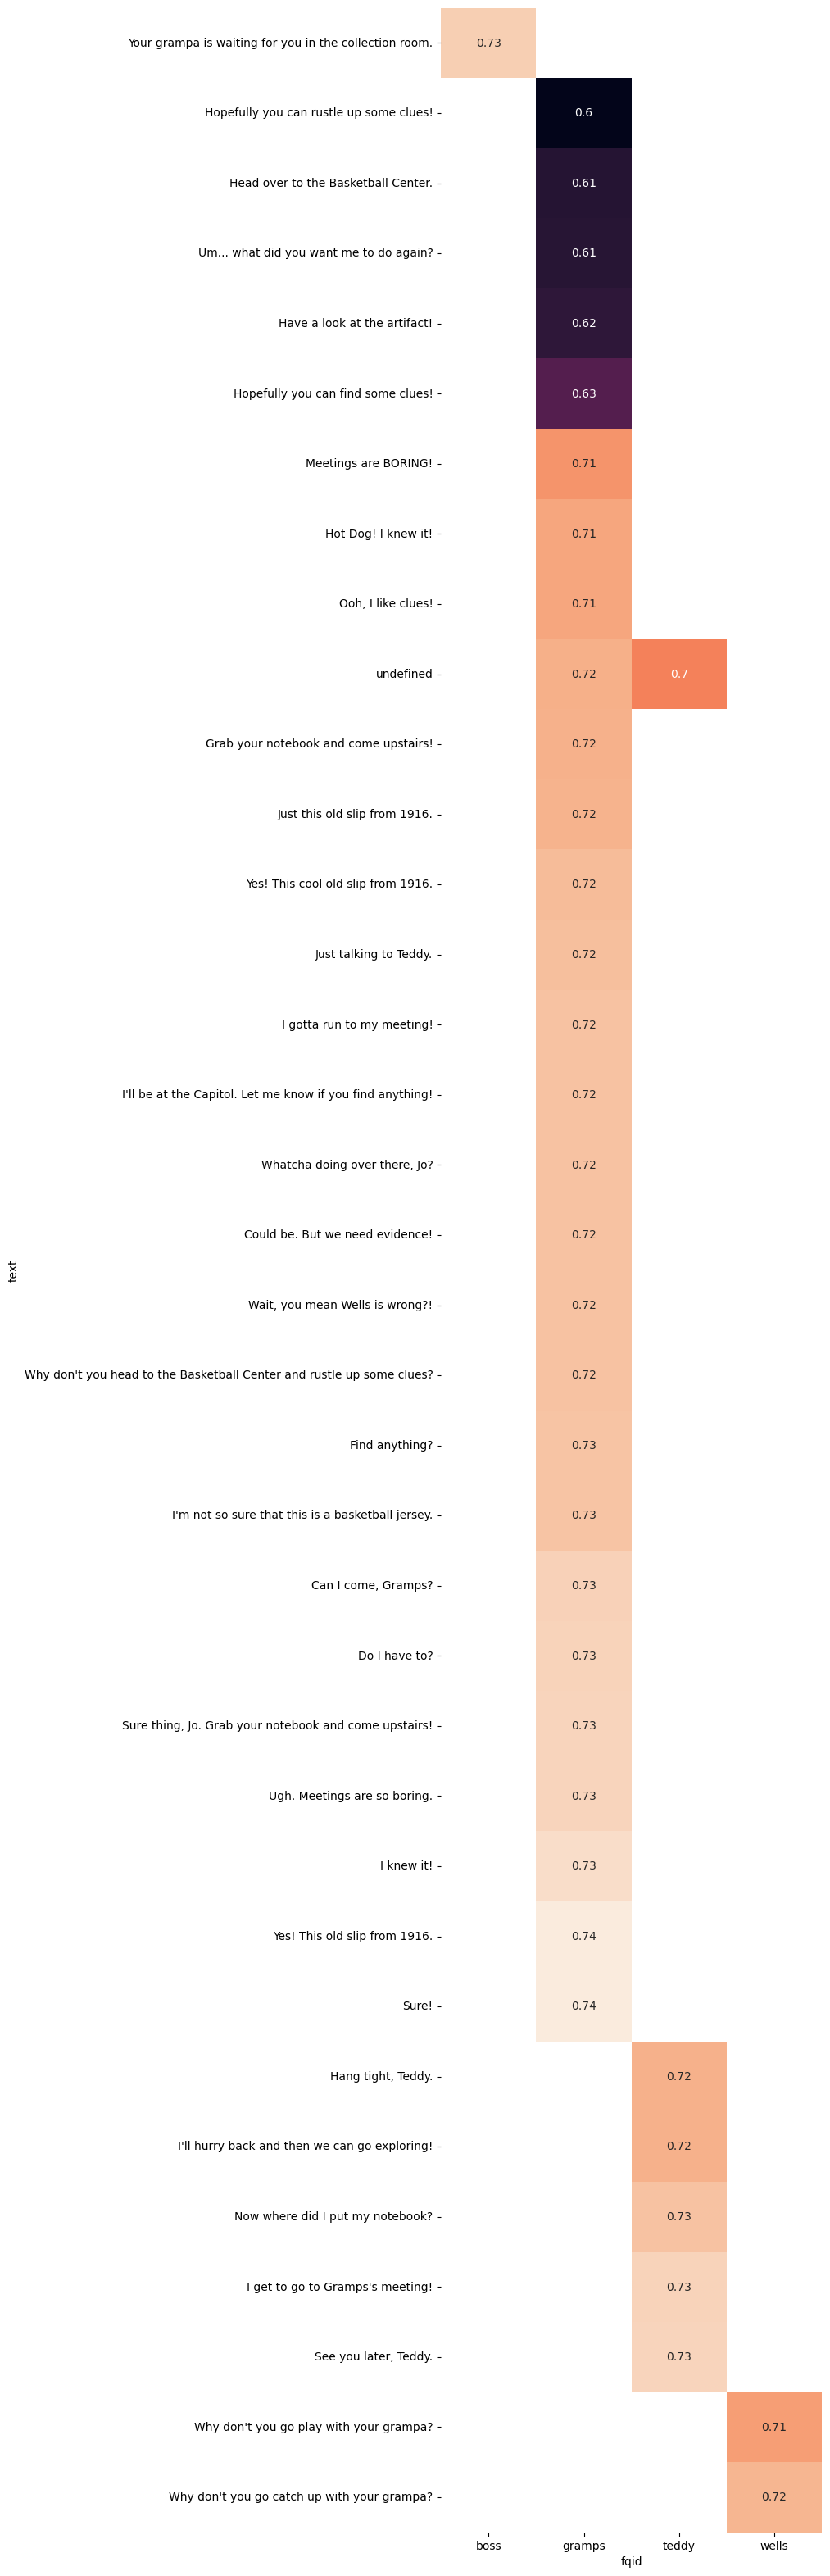

In [104]:
col_pair = ["text", "fqid"]
plot_heatmap(get_heatmap_values(df__person_click, col_pair), figsize=(6, 40))

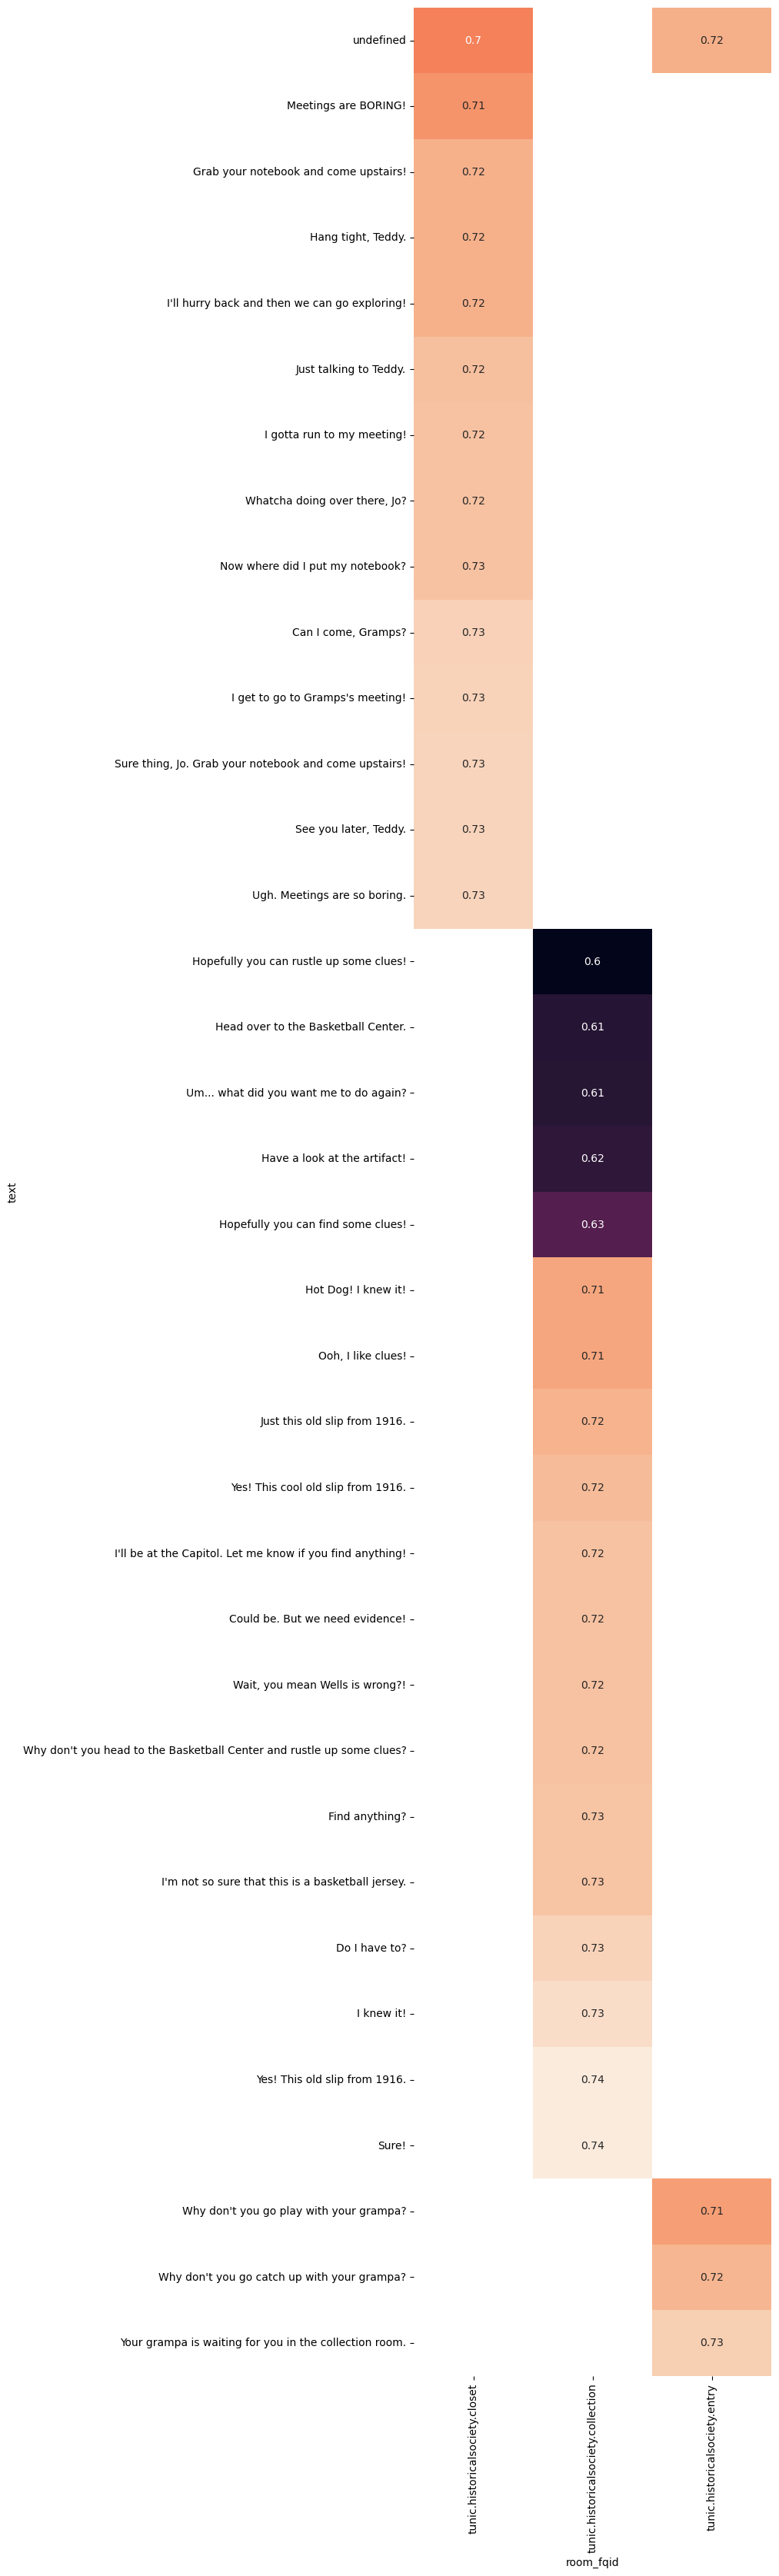

In [105]:
col_pair = ["text", "room_fqid"]
plot_heatmap(get_heatmap_values(df__person_click, col_pair), figsize=(6, 40))

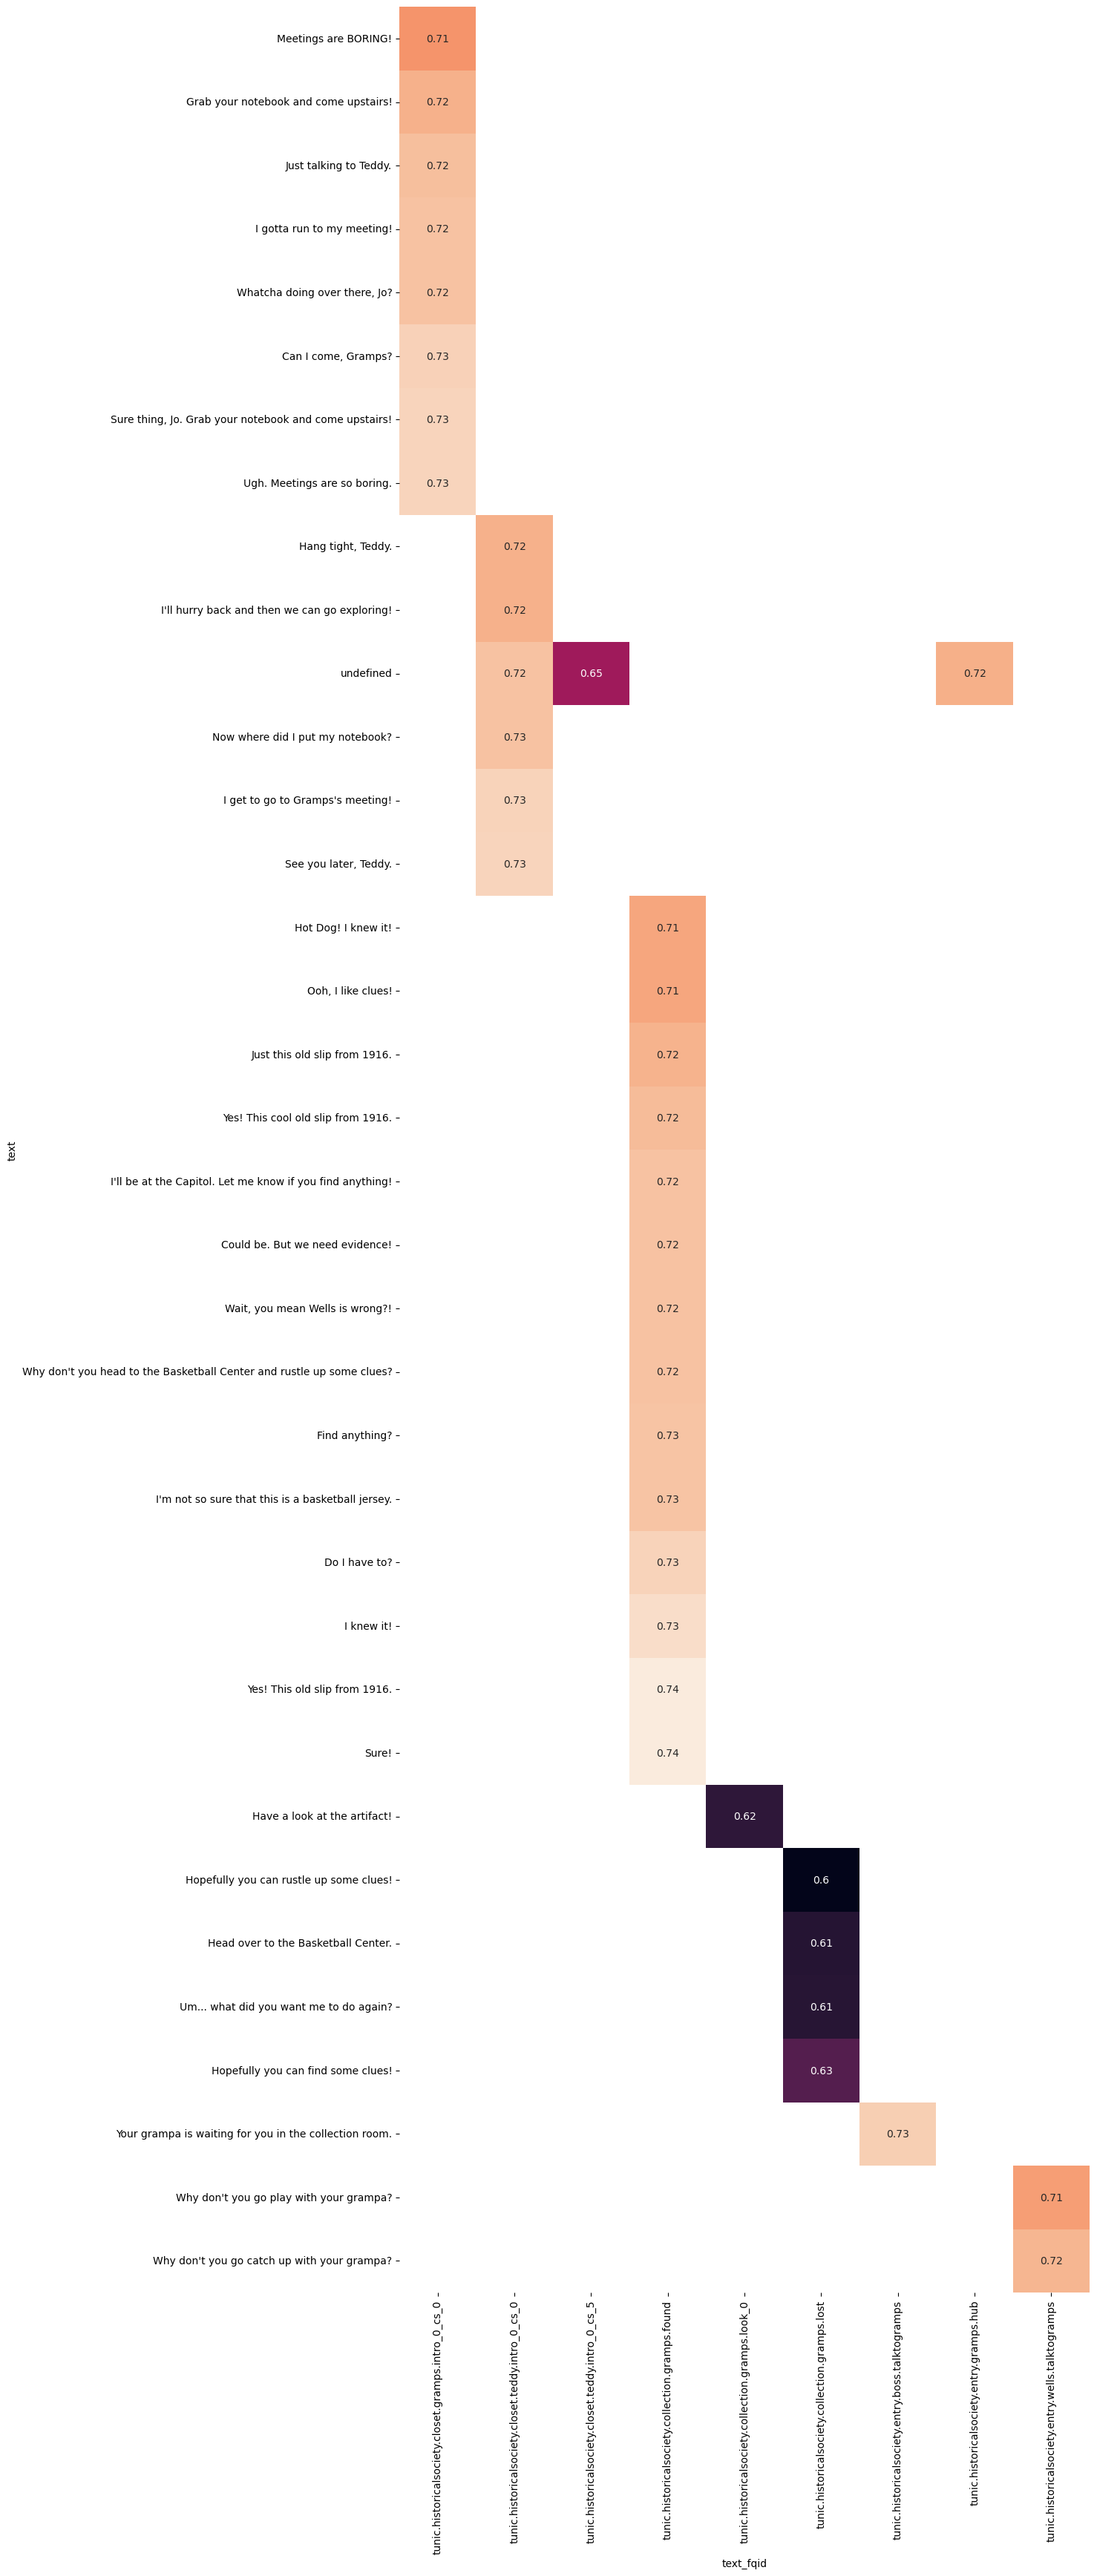

In [106]:
col_pair = ["text", "text_fqid"]
plot_heatmap(get_heatmap_values(df__person_click, col_pair), figsize=(12, 40))

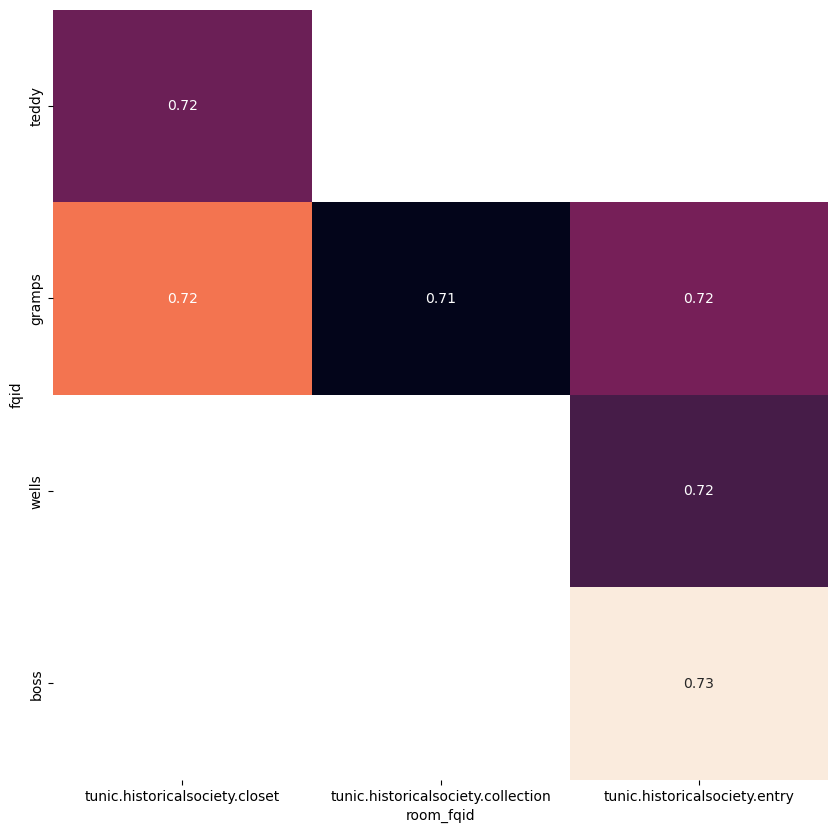

In [107]:
col_pair = ["fqid", "room_fqid"]
plot_heatmap(get_heatmap_values(df__person_click, col_pair), figsize=(10, 10))

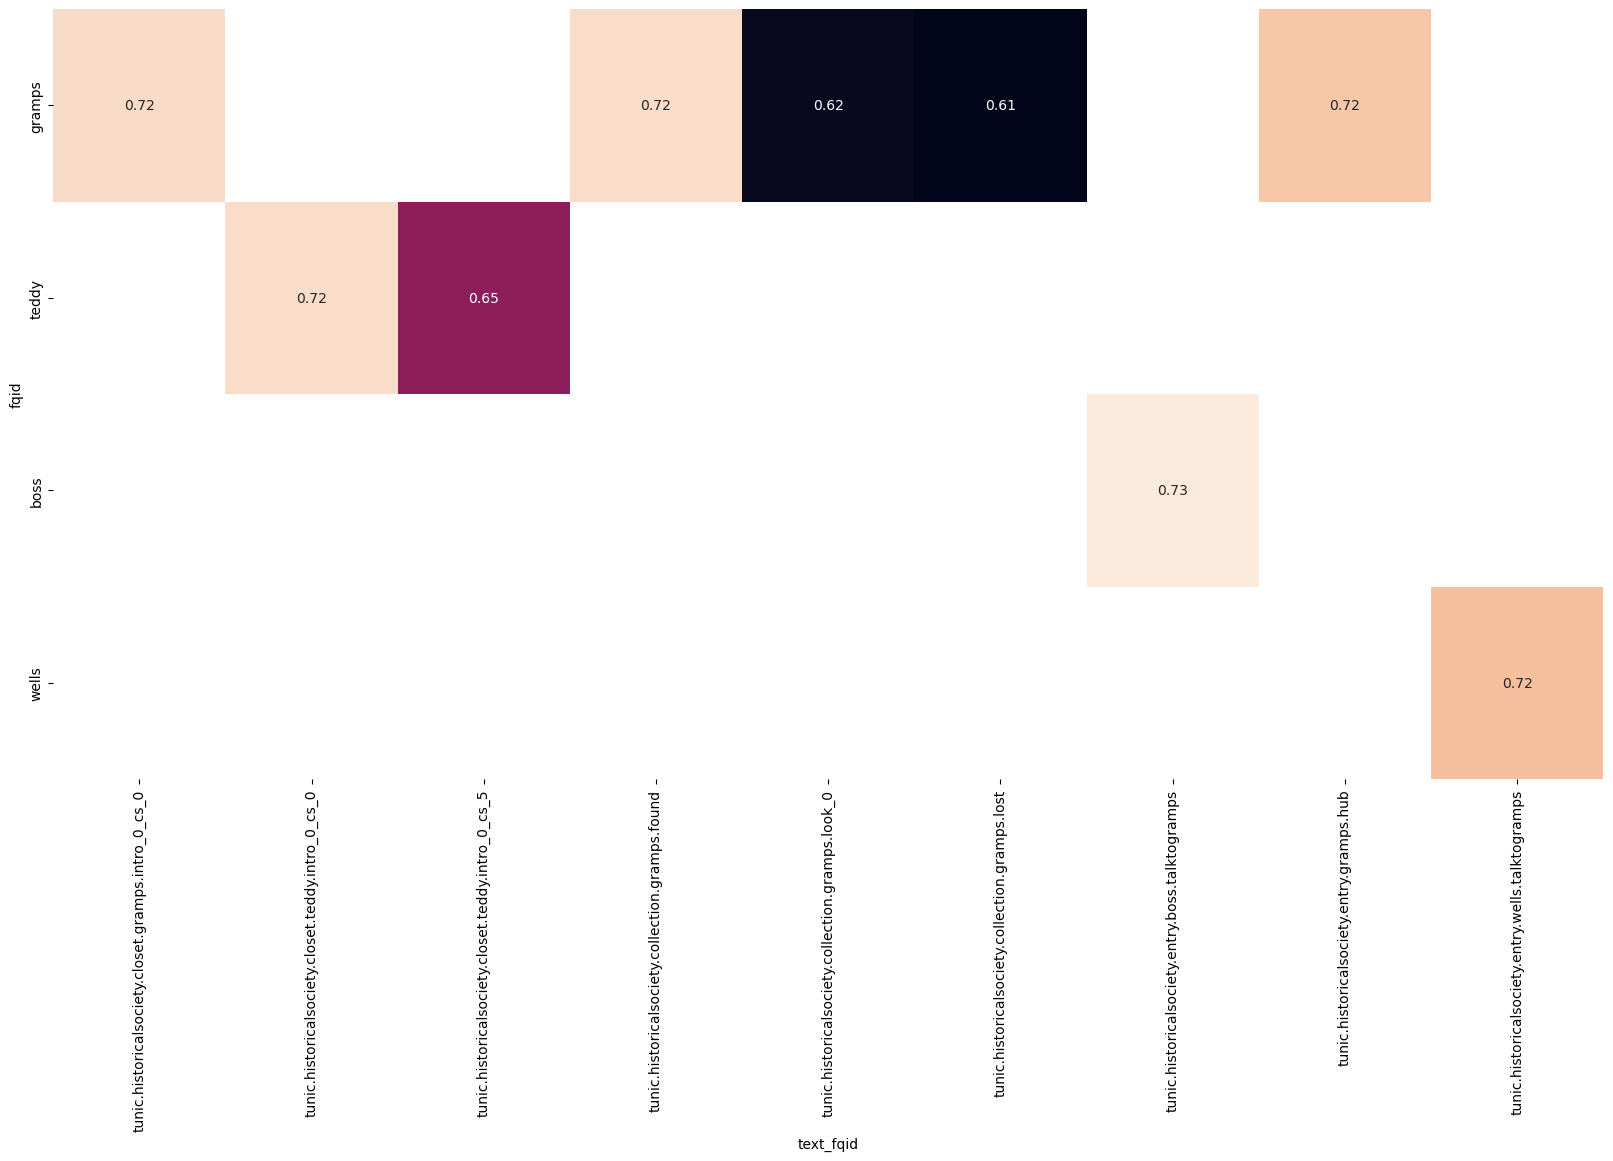

In [108]:
col_pair = ["fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__person_click, col_pair), figsize=(20, 10))

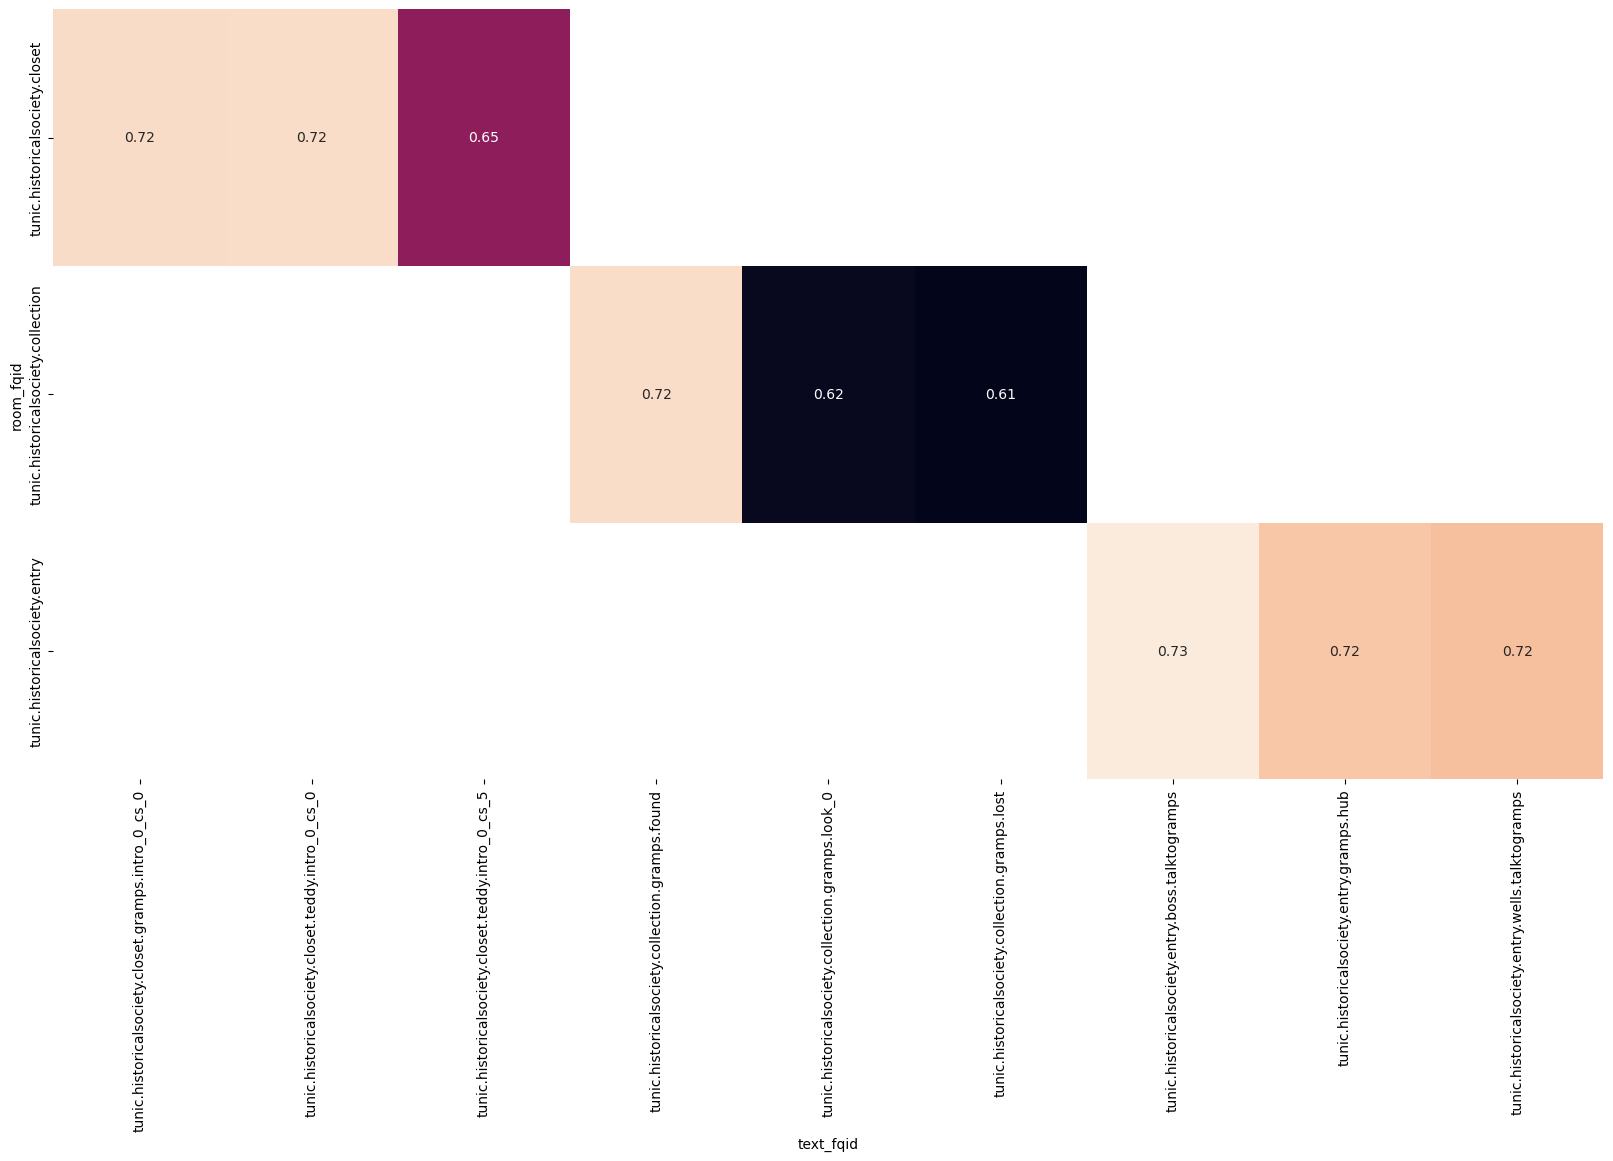

In [109]:
col_pair = ["room_fqid", "text_fqid"]
plot_heatmap(get_heatmap_values(df__person_click, col_pair), figsize=(20, 10))